### Materials and Methods


#### 3.1. Materials

Data for the seven metrics was accumulated from various open-source databases as listed in Fig 1. below.

In [1]:
# I'm working in a Python Virtual Environment, install the following packages into yours.

#!pip install missingno
#!pip install -U scikit-learn
#!pip install scipy
#!pip install seaborn
#!pip install pandas
#!pip install matplotlib
#!pip install statsmodels
#!pip install fancyimpute
#!pip install nbconvert[qtpdf]


# Specifically for Jupyter Notebooks

# !python3 -m pip install cite2c
# !python3 -m cite2c.install

In [2]:
# # Importing the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
# from scipy import stats
from fancyimpute import KNN
from fancyimpute import IterativeImputer
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import skew

In [3]:
# The table of indicators
the_metrics = [
    ['Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Ecosystem Stability', 'Ecosystem Stability', 'Ecosystem Stability', 'Ecosystem Stability', 'Ecosystem Stability', 'Food Affordability & Availability', 'Food Affordability & Availability', 'Food Affordability & Availability', 'Food Affordability & Availability', 'Socialcultural Wellbeing', 'Socialcultural Wellbeing', 'Socialcultural Wellbeing', 'Socialcultural Wellbeing', 'Resilience', 'Resilience', 'Food Safety', 'Food Safety', 'Waste & Loss Reduction'],
    ['Non-Staple Food Energy', 'Shannon Diversity', 'Modified Functional Attribute Diversity', 'Nutrient Density Score', 'Population Share With Adequate Nutrients', 'Ecosystem Status', 'GHG Emissions', 'Net FreshWater Withdrawals', 'Energy Use', 'Land Use', 'Income Equality', 'Poverty Index', 'GFSI Food Availability Score', 'Food Affordability', 'Animal Health & Welfare', 'Community Rights', ' Child Labor', 'Gender Equity', 'Food Production Diversity', 'ND-GAIN Country Index', 'GFSI Safety Score', 'Foodborne Disease Burden', 'Pre & Post-Consumer Food Loss'],
    ['Nutrients From Non-Staple Food', 'Nutrient Diversity in The Food System', 'Nutrient Diversity in The Food System', 'Nutrient Diversity in The Food System', 'Proportion of Population With Adequate Nutrients', 'Ecosystem Status', 'Eco-Efficiency', 'Eco-Efficiency', 'Eco-Efficiency', 'Eco-Efficiency', 'Food Availability & Affordability', 'Food Availability & Affordability', 'Food Availability & Affordability', 'Food Availability & Affordability', 'Gender Equality', 'Extent of Child Labor', 'Respect for Community Rights', 'Animal Health & Welfare', "Nation's Vulnerability to Climate Change", "Shares of Agricultural Food Production in The Country", "Food Borne Disease Burden", "GFSI Food Safety", "Later"]
]

sources = [['FAOs Food Balance Sheets'], ['FAOs Food Balance Sheets'], ['FAOs Food Balance Sheets'],['FAOs Food Balance Sheets'], ['FAOSTATS'], ['Yale Center for Environmental Law and Policy'], ['United Nations Framework Convention on Climate Change'], ['Data Collections, NASA'], ['Data Collections, NASA'], ['Data Collections, NASA'], ['Global Food Security Index (GFSI)'], ['Global Food Security Index (GFSI)'], ['United Nations, 2021'], ['United Nations, 2021'], ['Global Gender Gap Report 2020'], ['ILO, 2020'], ['Environmental Democracy Index'], ['Not Measured (Insufficient Data)'], ["Notre Dame Global Adaptation Initiative"], ["FAOSTAT"], ["World Health Organisation (WHO)"], ["Global Food Security Index (GFSI)"], ["Later"]]


the_table = pd.DataFrame(sources,
                         index= the_metrics,
                         columns = ["Sources"]
                        )

the_table.index = the_table.index.rename(['The Metric', 'Indicators', 'What They Measure'])

the_table.style

#the_table.to_csv('The Metrics.csv')

In [4]:
# Building a data scaler for some of the indicators

def scaler(df, column) :
    """Scales the dataset to a 0-100 scale"""

    median_values = df[column].median()

    scaled_values = list()

    for i, val in df[[column]].iterrows():
        scaler = 100 * np.exp(np.log(0.5) * (val/median_values))

        scaled_values.append(scaler.values[0])

    df["Scaled Values"] = scaled_values

    return df

In [5]:
# Building the sampling function that will be used in all datasets

# Setting the seed for sampling function

np.random.seed(10)

## Metric 1: Food Nutrient Adequacy

### Indicator 1: Non-Staple Food Energy

In [6]:
# 1. Loading the 'Country_Groups' Data Set
size_of_economy = pd.read_csv('Country_Groups.csv', sep = ",", \
                  header = 0, usecols = ["Country","Income group", \
                  "Region"]).set_index('Country')

display(size_of_economy.head())

,Income group,Region
Country,,
Aruba,High income,Latin America & Caribbean
Afghanistan,Low income,South Asia
Angola,Lower middle income,Sub-Saharan Africa
Albania,Upper middle income,Europe & Central Asia
Andorra,High income,Europe & Central Asia


In [7]:
# 2. Displaying the count of countries in each country group.

counts = pd.DataFrame(size_of_economy['Income group'].value_counts())

counts.loc['Total'] = counts['count'].sum()

display(counts)

,count
Income group,
High income,79
Lower middle income,55
Upper middle income,55
Low income,27
Total,216


In [8]:
# 3. Loading the Dietary Intake Dataset

dietary_intake = pd.read_csv("Daily_Energy_Intake.csv", 
                		sep= ',', 
                		header= None,
                        skiprows= [0],
                        names= ['Country', 'Food', 'Value'],
                        usecols= [0, 1, 2],
                            )

display(dietary_intake.head(10))

,Country,Food,Value
0,Afghanistan,Wheat and products,1362
1,Afghanistan,Rice and products,140
2,Afghanistan,Barley and products,1
3,Afghanistan,Maize and products,30
4,Afghanistan,Oats,0
5,Afghanistan,Millet and products,1
6,Afghanistan,"Cereals, Other",0
7,Afghanistan,Cassava and products,0
8,Afghanistan,Potatoes and products,53
9,Afghanistan,"Roots, Other",0


In [9]:
# 4. Transposing the 2nd column to work with the data easily.
dietary_intake_transposed = dietary_intake.pivot_table(
	index= 'Country',
    columns= 'Food',
    values = 'Value'
)
    
display(dietary_intake_transposed.head())

Food,Apples and products,"Aquatic Animals, Others",Aquatic Plants,Bananas,Barley and products,Beans,Beer,"Beverages, Alcoholic","Beverages, Fermented",Bovine Meat,...,Sunflower seed,Sunflowerseed Oil,Sweet potatoes,"Sweeteners, Other",Tea (including mate),Tomatoes and products,"Vegetables, other",Wheat and products,Wine,Yams
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4.0,NaN,NaN,5.0,1.0,NaN,0.0,0.0,0.0,16.0,...,NaN,31.0,NaN,1.0,2.0,0.0,30.0,1362.0,0.0,NaN
Albania,44.0,0.0,0.0,14.0,1.0,46.0,44.0,6.0,0.0,59.0,...,NaN,114.0,0.0,33.0,0.0,39.0,137.0,969.0,4.0,NaN
Algeria,16.0,0.0,0.0,7.0,107.0,14.0,5.0,1.0,0.0,24.0,...,NaN,30.0,0.0,10.0,0.0,20.0,100.0,1398.0,0.0,NaN
Angola,0.0,0.0,0.0,72.0,0.0,67.0,44.0,9.0,23.0,21.0,...,NaN,6.0,104.0,10.0,0.0,1.0,13.0,193.0,2.0,NaN
Antigua and Barbuda,7.0,NaN,0.0,29.0,0.0,10.0,42.0,65.0,1.0,36.0,...,0.0,2.0,6.0,31.0,1.0,5.0,40.0,585.0,19.0,3.0


In [10]:
# 5. Checking the data type and Column Names

display(dietary_intake_transposed.info())

display(dietary_intake_transposed.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, Afghanistan to Zimbabwe
Data columns (total 97 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Apples and products              186 non-null    float64
 1   Aquatic Animals, Others          167 non-null    float64
 2   Aquatic Plants                   179 non-null    float64
 3   Bananas                          182 non-null    float64
 4   Barley and products              179 non-null    float64
 5   Beans                            179 non-null    float64
 6   Beer                             184 non-null    float64
 7   Beverages, Alcoholic             185 non-null    float64
 8   Beverages, Fermented             179 non-null    float64
 9   Bovine Meat                      186 non-null    float64
 10  Butter, Ghee                     186 non-null    float64
 11  Cassava and products             147 non-null    float64
 12  Cephalopods 

None

Index(['Apples and products', 'Aquatic Animals, Others', 'Aquatic Plants',
       'Bananas', 'Barley and products', 'Beans', 'Beer',
       'Beverages, Alcoholic', 'Beverages, Fermented', 'Bovine Meat',
       'Butter, Ghee', 'Cassava and products', 'Cephalopods', 'Cereals, Other',
       'Citrus, Other', 'Cloves', 'Cocoa Beans and products', 'Coconut Oil',
       'Coconuts - Incl Copra', 'Coffee and products', 'Cottonseed',
       'Cottonseed Oil', 'Cream', 'Crustaceans', 'Dates', 'Demersal Fish',
       'Eggs', 'Fats, Animals, Raw', 'Fish, Body Oil', 'Fish, Liver Oil',
       'Freshwater Fish', 'Fruits, other', 'Grapefruit and products',
       'Grapes and products (excl wine)', 'Groundnut Oil', 'Groundnuts',
       'Honey', 'Infant food', 'Lemons, Limes and products', 'Maize Germ Oil',
       'Maize and products', 'Marine Fish, Other', 'Meat, Aquatic Mammals',
       'Meat, Other', 'Milk - Excluding Butter', 'Millet and products',
       'Miscellaneous', 'Molluscs, Other', 'Mutton &

In [11]:
# 6. Merging countries and their sizes of economies:  
size_and_dietary_intake = pd.merge(size_of_economy,
                                        dietary_intake_transposed,
                                        left_index=True,
                                        right_index= True)

display(size_and_dietary_intake.head())

# size_and_dietary_intake.info()

,Income group,Region,Apples and products,"Aquatic Animals, Others",Aquatic Plants,Bananas,Barley and products,Beans,Beer,"Beverages, Alcoholic",...,Sunflower seed,Sunflowerseed Oil,Sweet potatoes,"Sweeteners, Other",Tea (including mate),Tomatoes and products,"Vegetables, other",Wheat and products,Wine,Yams
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Low income,South Asia,4.0,NaN,NaN,5.0,1.0,NaN,0.0,0.0,...,NaN,31.0,NaN,1.0,2.0,0.0,30.0,1362.0,0.0,NaN
Angola,Lower middle income,Sub-Saharan Africa,0.0,0.0,0.0,72.0,0.0,67.0,44.0,9.0,...,NaN,6.0,104.0,10.0,0.0,1.0,13.0,193.0,2.0,NaN
Albania,Upper middle income,Europe & Central Asia,44.0,0.0,0.0,14.0,1.0,46.0,44.0,6.0,...,NaN,114.0,0.0,33.0,0.0,39.0,137.0,969.0,4.0,NaN
United Arab Emirates,High income,Middle East & North Africa,10.0,0.0,0.0,14.0,NaN,21.0,NaN,NaN,...,2.0,19.0,1.0,13.0,0.0,2.0,32.0,829.0,NaN,1.0
Argentina,Upper middle income,Latin America & Caribbean,7.0,0.0,0.0,22.0,NaN,19.0,42.0,13.0,...,NaN,270.0,6.0,68.0,26.0,13.0,29.0,927.0,42.0,NaN


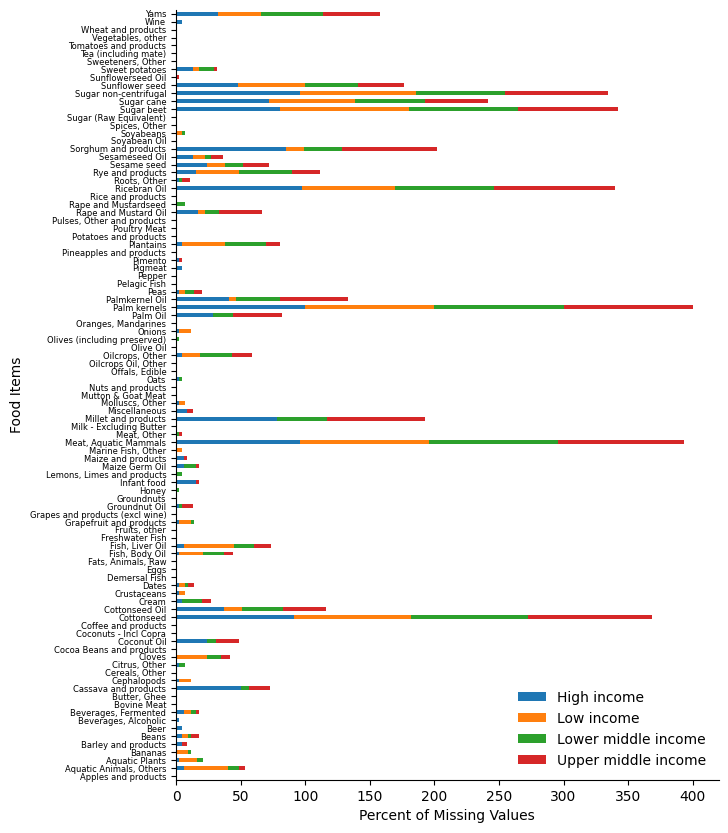

In [12]:
# 7. Checking the Type and Extent of Missing Data

## Splitting the data such that income groups and other fields are separate:
income_groups = size_and_dietary_intake[['Income group']]
# display(income_groups)


data = size_and_dietary_intake.iloc[:, 2:]
# display(data)


dietary_intake_nullity = data.isnull()
# display(dietary_intake_nullity)


## Merging it so that one can group missing values by income groups
dietary_nullity_income_grouped = pd.merge(income_groups,
                                          dietary_intake_nullity,
                                          left_index=True,
                                          right_index=True).groupby('Income group')

percentage_of_nullity = (dietary_nullity_income_grouped.sum() / dietary_nullity_income_grouped.count()) * 100
# display(percentage_of_nullity)



# Visualizing Nullity
percentage_of_nullity_dietary_intake_transposed = percentage_of_nullity.T

ax = percentage_of_nullity_dietary_intake_transposed.plot(kind='barh',
                                                          stacked=True)

ax.figure.set_size_inches(7, 10)
ax.set(xlabel='Percent of Missing Values',
       ylabel='Food Items')
ax.legend(loc='lower right', frameon=False)
#ax.invert_yaxis()
for spine in ['top', 'right'] :
    ax.spines[spine].set_visible(False)
# ax.set_title('Percentage of Missing Values For Each Food Item in Each Income Group', fontdict={'fontsize' : 10})
ax.tick_params(axis='y', which= 'major', labelsize=6)

#plt.set_size_inches(9, 7)
#plt.savefig('Percent_of_Nullity_1st_indicator.png')
plt.show()

In [13]:
# 9. Cleaning the dataset
# 9.1. Replacing 'NaN's with 0's
size_and_dietary_intake_imputed = size_and_dietary_intake.fillna(0.1) 	#print(the_sheet.head())


# 9.2. Grouping the foods into 7 groups : "Cereals", "Roots & Tubers", "Meat, Milk and Products, Eggs", "Vegetables", "Fruits and Plantains", "Seeds, Nuts and Oils", "Starch and Sugars"

daily_intake_aggregated = {
    'Country' : size_and_dietary_intake_imputed.index,
    'Income group' : size_and_dietary_intake_imputed['Income group'].values,
    #'Region' : size_and_dietary_intake_imputed['Region'].values,
    'Cereals' : 0,
    'Roots & Tubers' : 0,
    'Meat, Milk and products & Eggs' : 0,
    'Seeds, Nuts, and Oils' : 0,
    'Starchs & Sugars' : 0
}

daily_intake_aggregated['Cereals'] = \
    	size_and_dietary_intake_imputed['Barley and products']+ \
    	size_and_dietary_intake_imputed['Cereals, Other']+ \
        size_and_dietary_intake_imputed['Maize and products']+ \
        size_and_dietary_intake_imputed['Millet and products']+ \
        size_and_dietary_intake_imputed['Oats']+ \
        size_and_dietary_intake_imputed['Rice and products']+ \
        size_and_dietary_intake_imputed['Rye and products']+ \
        size_and_dietary_intake_imputed['Sorghum and products'] + \
        size_and_dietary_intake_imputed['Wheat and products']
        
daily_intake_aggregated['Roots & Tubers'] = \
    	size_and_dietary_intake_imputed['Cassava and products']+ \
        size_and_dietary_intake_imputed['Potatoes and products']+ \
        size_and_dietary_intake_imputed['Roots, Other']+ \
        size_and_dietary_intake_imputed['Sweet potatoes']+ \
    	size_and_dietary_intake_imputed['Yams'] + \
    	size_and_dietary_intake_imputed['Sugar cane'] + \
        size_and_dietary_intake_imputed['Sugar beet']

daily_intake_aggregated["Dairy & Egg Products"] = \
    size_and_dietary_intake_imputed['Butter, Ghee']+ \
    size_and_dietary_intake_imputed['Cream']+ \
    size_and_dietary_intake_imputed['Eggs'] + \
    size_and_dietary_intake_imputed['Milk - Excluding Butter']

daily_intake_aggregated["Finfish / Shellfish Products"] = \
	size_and_dietary_intake_imputed['Cephalopods']+ \
	size_and_dietary_intake_imputed['Crustaceans']+ \
    size_and_dietary_intake_imputed['Demersal Fish'] + \
    size_and_dietary_intake_imputed['Fish, Body Oil'] + \
    size_and_dietary_intake_imputed['Fish, Liver Oil'] + \
    size_and_dietary_intake_imputed['Freshwater Fish'] + \
    size_and_dietary_intake_imputed['Marine Fish, Other'] + \
    size_and_dietary_intake_imputed['Molluscs, Other']+ \
    size_and_dietary_intake_imputed['Pelagic Fish'] + \
    size_and_dietary_intake_imputed['Aquatic Animals, Others']


daily_intake_aggregated["Poultry"] = \
    size_and_dietary_intake_imputed['Poultry Meat']

daily_intake_aggregated["Pork"] = \
    size_and_dietary_intake_imputed['Pigmeat']


daily_intake_aggregated['Beef Products'] = \
    	size_and_dietary_intake_imputed['Bovine Meat']+ \
        size_and_dietary_intake_imputed['Offals, Edible'] + \
        size_and_dietary_intake_imputed['Fats, Animals, Raw'] + \
        size_and_dietary_intake_imputed['Meat, Other'] + \
        size_and_dietary_intake_imputed['Meat, Aquatic Mammals'] + \
    	size_and_dietary_intake_imputed['Mutton & Goat Meat']
        
daily_intake_aggregated["Spices & Herbs"] = \
    size_and_dietary_intake_imputed['Spices, Other'] + \
    size_and_dietary_intake_imputed['Tea (including mate)'] + \
    size_and_dietary_intake_imputed['Cloves']

daily_intake_aggregated["Legumes & Products"] = \
    size_and_dietary_intake_imputed['Pulses, Other and products']+ \
    size_and_dietary_intake_imputed['Beans']+ \
    size_and_dietary_intake_imputed['Soyabeans']+ \
    size_and_dietary_intake_imputed['Peas']

daily_intake_aggregated['Vegetables'] = \
    size_and_dietary_intake_imputed['Pimento'] + \
    size_and_dietary_intake_imputed['Pepper'] + \
	size_and_dietary_intake_imputed['Onions']+ \
    size_and_dietary_intake_imputed['Vegetables, other'] + \
	size_and_dietary_intake_imputed['Tomatoes and products'] + \
    size_and_dietary_intake_imputed['Aquatic Plants']
    
daily_intake_aggregated['Fruits & Plantains'] = \
    	size_and_dietary_intake_imputed['Bananas']+ \
    	size_and_dietary_intake_imputed['Coconuts - Incl Copra']+ \
    	size_and_dietary_intake_imputed['Dates']+ \
    	size_and_dietary_intake_imputed['Fruits, other']+ \
    	size_and_dietary_intake_imputed['Grapefruit and products'] + \
    	size_and_dietary_intake_imputed['Grapes and products (excl wine)'] + \
    	size_and_dietary_intake_imputed['Lemons, Limes and products'] + \
    	size_and_dietary_intake_imputed['Oranges, Mandarines'] + \
    	size_and_dietary_intake_imputed['Pineapples and products'] + \
    	size_and_dietary_intake_imputed['Plantains'] + \
    	size_and_dietary_intake_imputed['Apples and products'] + \
        size_and_dietary_intake_imputed['Citrus, Other']
    
daily_intake_aggregated['Seeds, Nuts, and Oils'] = \
    	size_and_dietary_intake_imputed['Cocoa Beans and products'] + \
        size_and_dietary_intake_imputed['Maize Germ Oil'] + \
        size_and_dietary_intake_imputed['Nuts and products'] + \
    	size_and_dietary_intake_imputed['Coconut Oil'] + \
        size_and_dietary_intake_imputed['Coconuts - Incl Copra'] + \
    	size_and_dietary_intake_imputed['Coffee and products'] + \
    	size_and_dietary_intake_imputed['Cottonseed Oil'] + \
    	size_and_dietary_intake_imputed['Cottonseed'] + \
        size_and_dietary_intake_imputed['Ricebran Oil'] + \
    	size_and_dietary_intake_imputed['Groundnut Oil'] + \
        size_and_dietary_intake_imputed['Oilcrops Oil, Other'] + \
    	size_and_dietary_intake_imputed['Groundnuts'] + \
        size_and_dietary_intake_imputed['Olive Oil'] + \
        size_and_dietary_intake_imputed['Olives (including preserved)'] + \
    	size_and_dietary_intake_imputed['Oilcrops, Other'] + \
    	size_and_dietary_intake_imputed['Palmkernel Oil'] + \
    	size_and_dietary_intake_imputed['Palm Oil'] + \
    	size_and_dietary_intake_imputed['Palm kernels'] + \
    	size_and_dietary_intake_imputed['Rape and Mustard Oil'] + \
    	size_and_dietary_intake_imputed['Rape and Mustardseed'] + \
    	size_and_dietary_intake_imputed['Sesame seed'] + \
    	size_and_dietary_intake_imputed['Sesameseed Oil'] + \
    	size_and_dietary_intake_imputed['Soyabean Oil'] + \
    	size_and_dietary_intake_imputed['Sunflower seed'] + \
    	size_and_dietary_intake_imputed['Sunflowerseed Oil']
    	#the_sheet_transposed['Nuts and products [2551]'] + \
    
daily_intake_aggregated['Starchs & Sugars'] = \
    	size_and_dietary_intake_imputed['Honey'] + \
    	size_and_dietary_intake_imputed['Sugar (Raw Equivalent)'] + \
    	size_and_dietary_intake_imputed['Sugar non-centrifugal'] + \
    	size_and_dietary_intake_imputed['Sweeteners, Other'] + \
    	size_and_dietary_intake_imputed['Beverages, Fermented']

daily_intake_aggregated['Infant food'] = \
        size_and_dietary_intake_imputed['Infant food']


daily_dietary_intake = pd.DataFrame(daily_intake_aggregated).set_index('Country')


# Removing the "Meat, Milk and products & Eggs column"
daily_dietary_intake = daily_dietary_intake.drop("Meat, Milk and products & Eggs", axis=1)


display(daily_dietary_intake.info())
# daily_dietary_intake.to_csv('Daily Dietary Energy Intake.csv', index=True)

# daily_dietary_intake.head()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, Afghanistan to Zimbabwe
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Income group                  156 non-null    object 
 1   Cereals                       156 non-null    float64
 2   Roots & Tubers                156 non-null    float64
 3   Seeds, Nuts, and Oils         156 non-null    float64
 4   Starchs & Sugars              156 non-null    float64
 5   Dairy & Egg Products          156 non-null    float64
 6   Finfish / Shellfish Products  156 non-null    float64
 7   Poultry                       156 non-null    float64
 8   Pork                          156 non-null    float64
 9   Beef Products                 156 non-null    float64
 10  Spices & Herbs                156 non-null    float64
 11  Legumes & Products            156 non-null    float64
 12  Vegetables                    156 non-null    float64


None

In [14]:
# Checking how good is the sample size

daily_dietary_intake[["Income group","Cereals"]].groupby("Income group").count()

,Cereals
Income group,
High income,46
Low income,21
Lower middle income,44
Upper middle income,45


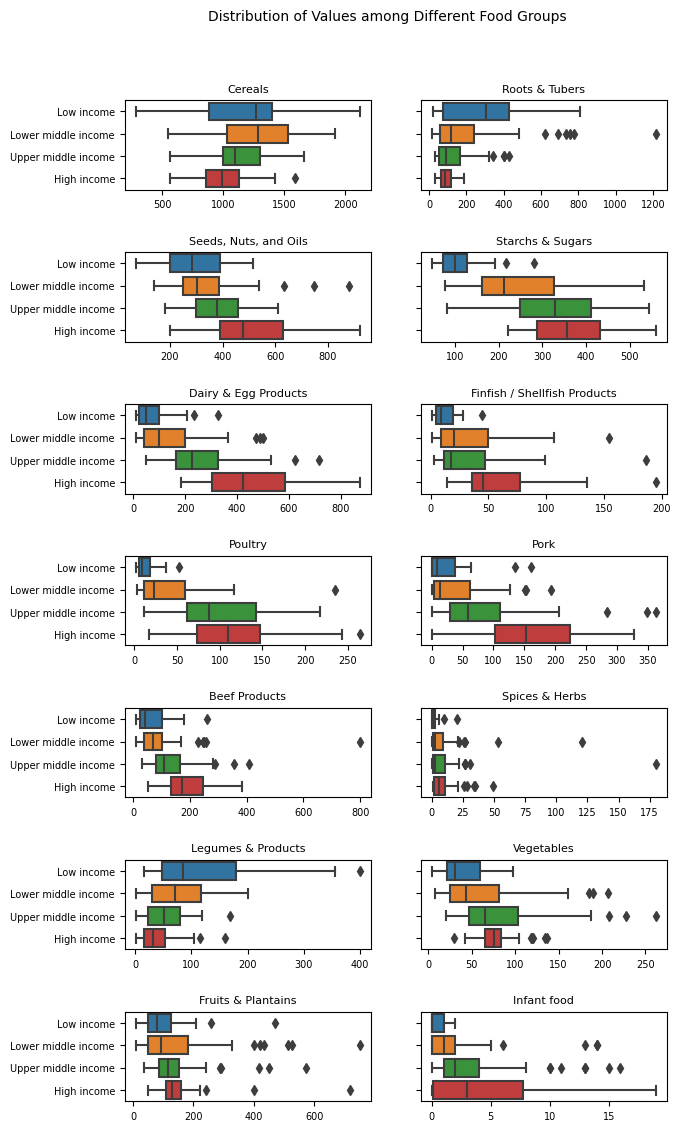

In [15]:
# Checking the distributions and Extreme Values: 1. The Box Plots

fig, ((ax1, ax2), 
      (ax3, ax4), 
      (ax5, ax6), 
      (ax7, ax8), 
      (ax9, ax10), 
      (ax11, ax12), 
      (ax13, ax14)) = plt.subplots(7, 2, sharey=True, sharex=False, figsize=(7, 13))

def distributions(df, x, y, ax) :
    
    """Plots Boxplots for income groups"""
    
    g = sns.boxplot(data=df,
                    ax= ax,
                    x=x,
                    palette='tab10',
                    y=y).set(xlabel='',
                             ylabel='',
                             title=x)
    
    ax.set_title(x, fontsize=8)
    
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    return g

distributions(df=daily_dietary_intake, x="Cereals", y="Income group", ax=ax1)
distributions(df=daily_dietary_intake, x="Roots & Tubers", y="Income group", ax=ax2)
distributions(df=daily_dietary_intake, x="Seeds, Nuts, and Oils", y="Income group", ax=ax3)
distributions(df=daily_dietary_intake, x="Starchs & Sugars", y="Income group", ax=ax4)
distributions(df=daily_dietary_intake, x="Dairy & Egg Products", y="Income group", ax=ax5)
distributions(df=daily_dietary_intake, x="Finfish / Shellfish Products", y="Income group", ax=ax6)
distributions(df=daily_dietary_intake, x="Poultry", y="Income group", ax=ax7)
distributions(df=daily_dietary_intake, x="Pork", y="Income group", ax=ax8)
distributions(df=daily_dietary_intake, x="Beef Products", y="Income group", ax=ax9)
distributions(df=daily_dietary_intake, x="Spices & Herbs", y="Income group", ax=ax10)
distributions(df=daily_dietary_intake, x="Legumes & Products", y="Income group", ax=ax11)
distributions(df=daily_dietary_intake, x="Vegetables", y="Income group", ax=ax12)
distributions(df=daily_dietary_intake, x="Fruits & Plantains", y="Income group", ax=ax13)
distributions(df=daily_dietary_intake, x="Infant food", y="Income group", ax=ax14)

plt.suptitle('Distribution of Values among Different Food Groups', y= 0.95, fontsize=10)
plt.subplots_adjust(hspace= 0.7)
#plt.savefig('Distribution_of_Daily_Kcal_Intakes.png')


# Refer to this code for finer customizations of Seaborn plots.

In [16]:
# Removing Extreme Values

## 9.3. Separating country groups into different datasets.
def income_group_separator(df, col, cat) :

    """Separates a respective income group's data"""
    
    new_df = df[df[col] == cat]
    
    return new_df

low_inc_values = income_group_separator(daily_dietary_intake, 'Income group', 'Low income')

lower_middle_values = income_group_separator(daily_dietary_intake,'Income group', 'Lower middle income')

upper_middle_values = income_group_separator(daily_dietary_intake,'Income group', 'Upper middle income')

high_inc_values = income_group_separator(daily_dietary_intake, 'Income group', 'High income')

In [17]:
# Transforming the data

low_inc_values_transformed = np.log(low_inc_values.iloc[:, 1:])

lower_middle_values_transformed = np.log(lower_middle_values.iloc[:, 1:])

upper_middle_values_transformed = np.log(upper_middle_values.iloc[:, 1:])

high_inc_values_transformed = np.log(high_inc_values.iloc[:, 1:])


transformed_all_groups = pd.concat([low_inc_values_transformed,
                                    lower_middle_values_transformed,
                                    upper_middle_values_transformed,
                                    high_inc_values_transformed])

transformed_data_economized = pd.merge(size_of_economy,
                                       transformed_all_groups,
                                       left_index=True,
                                       right_index=True).drop("Region", axis=1)

transformed_data_economized.head()

c:\Users\David\Desktop\Dev\thesis\.venv\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,Income group,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Starchs & Sugars,Dairy & Egg Products,Finfish / Shellfish Products,Poultry,Pork,Beef Products,Spices & Herbs,Legumes & Products,Vegetables,Fruits & Plantains,Infant food
Country,,,,,,,,,,,,,,,
Afghanistan,Low income,7.335764,3.977811,5.344724,5.004617,4.787492,0.530628,1.791759,-inf,3.914021,1.098612,2.844909,3.529297,4.079231,0.000000
Angola,Lower middle income,6.634765,6.597555,5.772998,5.069533,2.639057,3.182212,3.496508,4.343805,3.666122,-inf,4.345103,2.708050,4.635699,0.000000
Albania,Upper middle income,6.971856,4.492001,5.804834,5.318610,6.573680,2.708050,4.127134,4.077537,5.100476,-2.302585,3.912023,5.337538,5.666773,0.000000
United Arab Emirates,High income,6.984161,3.666122,6.698638,5.847017,5.389072,3.737670,4.709530,-2.302585,4.745801,2.302585,5.075174,4.007333,4.691348,1.609438
Argentina,Upper middle income,6.955974,4.434382,6.002404,6.080162,5.693732,2.397895,5.267858,4.718499,6.011512,3.295837,4.007333,3.988984,4.394449,-2.302585


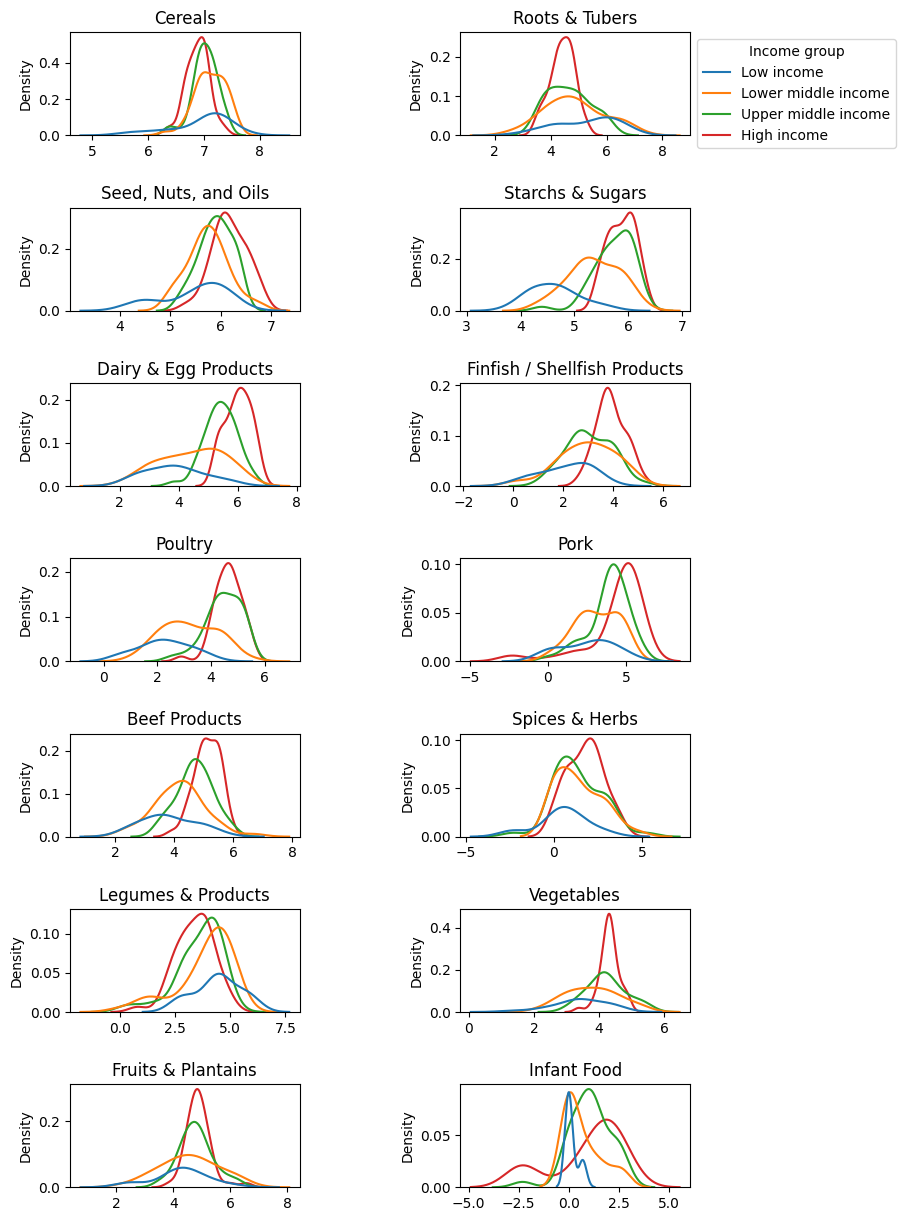

In [18]:
# Visualizing distributions of the transformed data

fig, ((ax1, ax2), 
      (ax3, ax4), 
      (ax5, ax6), 
      (ax7, ax8), 
      (ax9, ax10), 
      (ax11, ax12), 
      (ax13, ax14)) = plt.subplots(7, 2, sharey=False, sharex=False, figsize=(8, 15))

sns.kdeplot(data=transformed_data_economized, x="Cereals", hue="Income group", ax=ax1, legend=False).set(xlabel="", title="Cereals")
sns.kdeplot(data=transformed_data_economized, x="Roots & Tubers", hue="Income group", ax=ax2).set(xlabel="", title="Roots & Tubers")
sns.kdeplot(data=transformed_data_economized, x="Seeds, Nuts, and Oils", hue="Income group", ax=ax3, legend=False).set(xlabel="", title="Seed, Nuts, and Oils")
sns.kdeplot(data=transformed_data_economized, x="Starchs & Sugars", hue="Income group", ax=ax4, legend=False).set(xlabel="", title="Starchs & Sugars")
sns.kdeplot(data=transformed_data_economized, x="Dairy & Egg Products", hue="Income group", ax=ax5, legend=False).set(xlabel="", title="Dairy & Egg Products")
sns.kdeplot(data=transformed_data_economized, x="Finfish / Shellfish Products", hue="Income group", ax=ax6, legend=False).set(xlabel="", title="Finfish / Shellfish Products")
sns.kdeplot(data=transformed_data_economized, x="Poultry", hue="Income group", ax=ax7, legend=False).set(xlabel="", title="Poultry")
sns.kdeplot(data=transformed_data_economized, x="Pork", hue="Income group", ax=ax8, legend=False).set(xlabel="", title="Pork")
sns.kdeplot(data=transformed_data_economized, x="Beef Products", hue="Income group", ax=ax9, legend=False).set(xlabel="", title="Beef Products")
sns.kdeplot(data=transformed_data_economized, x="Spices & Herbs", hue="Income group", ax=ax10, legend=False).set(xlabel="", title="Spices & Herbs")
sns.kdeplot(data=transformed_data_economized, x="Legumes & Products", hue="Income group", ax=ax11, legend=False).set(xlabel="", title="Legumes & Products")
sns.kdeplot(data=transformed_data_economized, x="Vegetables", hue="Income group", ax=ax12, legend=False).set(xlabel="", title="Vegetables")
sns.kdeplot(data=transformed_data_economized, x="Fruits & Plantains", hue="Income group", ax=ax13, legend=False).set(xlabel="", title="Fruits & Plantains")
sns.kdeplot(data=transformed_data_economized, x="Infant food", hue="Income group", ax=ax14, legend=False).set(xlabel="", title="Infant Food")

plt.subplots_adjust(hspace=0.7, wspace= 0.7)

sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1), frameon=True)

In [19]:
# Non-normality prevails in three variables: Pork, Spices & Herbs, Infant food. Removing the three variables

transformed_data_cleaned = transformed_data_economized.drop(["Pork", "Spices & Herbs", "Infant food"], axis=1)

transformed_data_cleaned.head(2)

,Income group,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Starchs & Sugars,Dairy & Egg Products,Finfish / Shellfish Products,Poultry,Beef Products,Legumes & Products,Vegetables,Fruits & Plantains
Country,,,,,,,,,,,,
Afghanistan,Low income,7.335764,3.977811,5.344724,5.004617,4.787492,0.530628,1.791759,3.914021,2.844909,3.529297,4.079231
Angola,Lower middle income,6.634765,6.597555,5.772998,5.069533,2.639057,3.182212,3.496508,3.666122,4.345103,2.708050,4.635699


In [20]:
# Renaming the columns so that one can work with the data easily

transformed_data_cleaned.columns = ["income_group",
                                    "cereals",
                                    "roots_and_tubers",
                                    "seeds_nuts_and_oils",
                                    "starches_and_sugars",
                                    "dairy_and_egg_products",
                                    "finfish_and_shellfish_products",
                                    "poultry",
                                    "beef_products",
                                    "legumes_and_products",
                                    "vegetables",
                                    "fruits_and_plantains"]

transformed_data_cleaned.head()

,income_group,cereals,roots_and_tubers,seeds_nuts_and_oils,starches_and_sugars,dairy_and_egg_products,finfish_and_shellfish_products,poultry,beef_products,legumes_and_products,vegetables,fruits_and_plantains
Country,,,,,,,,,,,,
Afghanistan,Low income,7.335764,3.977811,5.344724,5.004617,4.787492,0.530628,1.791759,3.914021,2.844909,3.529297,4.079231
Angola,Lower middle income,6.634765,6.597555,5.772998,5.069533,2.639057,3.182212,3.496508,3.666122,4.345103,2.708050,4.635699
Albania,Upper middle income,6.971856,4.492001,5.804834,5.318610,6.573680,2.708050,4.127134,5.100476,3.912023,5.337538,5.666773
United Arab Emirates,High income,6.984161,3.666122,6.698638,5.847017,5.389072,3.737670,4.709530,4.745801,5.075174,4.007333,4.691348
Argentina,Upper middle income,6.955974,4.434382,6.002404,6.080162,5.693732,2.397895,5.267858,6.011512,4.007333,3.988984,4.394449


In [21]:
# Running MANOVA

fit = MANOVA.from_formula("cereals + roots_and_tubers + seeds_nuts_and_oils + starches_and_sugars + dairy_and_egg_products + finfish_and_shellfish_products + poultry + beef_products + legumes_and_products + vegetables + fruits_and_plantains ~ income_group", data=transformed_data_cleaned)

print(fit.mv_test())

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept         Value    Num DF  Den DF   F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda   0.0016 11.0000 142.0000 8033.2113 0.0000
         Pillai's trace   0.9984 11.0000 142.0000 8033.2113 0.0000
 Hotelling-Lawley trace 622.2910 11.0000 142.0000 8033.2113 0.0000
    Roy's greatest root 622.2910 11.0000 142.0000 8033.2113 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
          income_group      Value   Num DF  Den DF  F Value Pr > F
------------------------------------------------------------------
              Wilks' lambda 0.1530 33.0000 419.0621 11.3196 0.0000
             Pil

In [22]:
# After transforming the data; to assess group performance, median was used as a measure of central tendency. This was done in order to retain the robustness that could be obtained by using a full dataset. One can rightly attempt to filter-out the dataset and remove extreme values, but since the result of this would probably still favor the usage of median, it was deemed unnecessary to do that particular data cleaning exercise.

In [23]:
# Although means and medians came considerably close, the presence of extreme values in some food groups compells us to take median as the measure of central tendency.

median_kilo_cal_transposed = daily_dietary_intake.groupby("Income group").median().T

median_kilo_cal_transposed

Income group,High income,Low income,Lower middle income,Upper middle income
Cereals,988.30,1266.1,1281.70,1099.2
Roots & Tubers,86.60,307.1,116.55,89.3
"Seeds, Nuts, and Oils",476.55,285.4,301.75,377.4
Starchs & Sugars,357.10,99.1,211.05,329.1
Dairy & Egg Products,421.00,47.0,100.10,225.0
Finfish / Shellfish Products,45.00,9.0,20.00,18.0
Poultry,109.50,9.0,23.50,88.0
Pork,152.00,9.0,13.50,59.0
Beef Products,172.60,41.1,71.15,107.1
Spices & Herbs,6.00,1.0,2.55,3.0


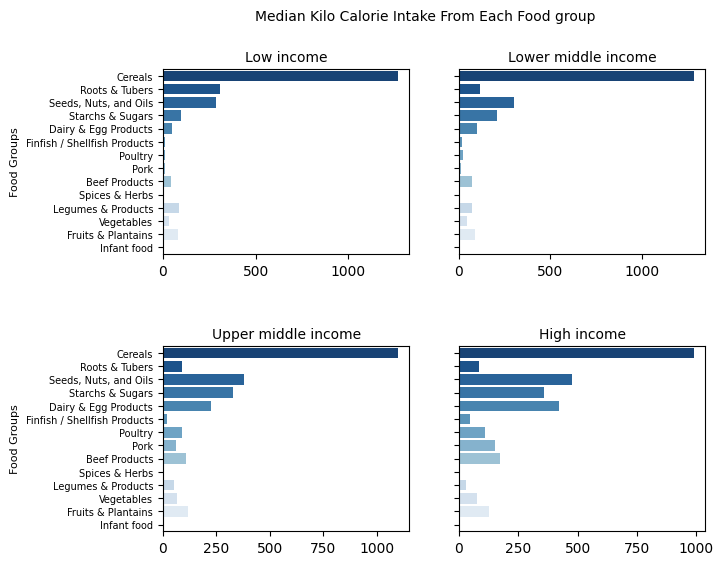

In [24]:
## 10.2. Visualizing median kilo calories from each income group.

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=True)
fig.set_size_inches(7, 6)


def bar_plotter(df, x, y, ax, xlabel=None, ylabel=None, palette=None, title=None) :
    
    """Creates bar plots for Income groups"""
    
    g = sns.barplot(x=x,
                    y=y,
                    data= df,
                    ax= ax,
                    palette=palette).set(xlabel='')


    ax.tick_params(axis= 'y', which='major', labelsize=7)
    ax.set_ylabel(ylabel, fontdict={"fontsize" : 8})
    ax.set_xlabel(xlabel, fontdict={'fontsize' : 8})
    ax.set_title(label=x, fontsize=10)
    plt.subplots_adjust(hspace=0.5)



df = median_kilo_cal_transposed

y = median_kilo_cal_transposed.index

yl = 'Food Groups'


bar_plotter(df, x='Low income', y=y, ax=ax1, ylabel=yl, palette="Blues_r")

bar_plotter(df, x='Lower middle income', ax=ax2, y=y, palette="Blues_r")

bar_plotter(df, x='Upper middle income', ax=ax3, y=y, ylabel=yl, palette="Blues_r")

bar_plotter(df, x='High income', y=y, ax=ax4, palette="Blues_r")


plt.suptitle('Median Kilo Calorie Intake From Each Food group', fontsize=10)
plt.savefig('Median Daily_Intake_Kcal.png')
plt.show()

In [25]:
median_kcal_high_income = median_kilo_cal_transposed[['High income']].sort_values('High income', ascending=False)

median_kcal_low_income = median_kilo_cal_transposed[['Low income']].sort_values('Low income' , ascending=False)

median_kcal_lower_middle_income = median_kilo_cal_transposed[['Lower middle income']].sort_values('Lower middle income', ascending=False)

median_kcal_upper_middle_income = median_kilo_cal_transposed[['Upper middle income']].sort_values('Upper middle income', ascending=False)


def percentage_cal(df) :
    
    """Calculates Percentage For Each Food Group"""

    df.loc['Total'] = df.iloc[:, 0].sum()

    numerator = df.iloc[:, 0].values

    denominator = df.loc['Total'].values

    df['Percent'] = np.round(((numerator / denominator) * 100), 1)
    
    return df




food_group_kcal_percent_high_income = percentage_cal(median_kcal_high_income)

food_group_kcal_percent_low_income = percentage_cal(median_kcal_low_income)

food_group_kcal_percent_lower_middle = percentage_cal(median_kcal_lower_middle_income)

food_group_kcal_percent_upper_middle = percentage_cal(median_kcal_upper_middle_income)


display(food_group_kcal_percent_high_income.T)
display(food_group_kcal_percent_low_income.T)
display(food_group_kcal_percent_lower_middle.T)
display(food_group_kcal_percent_upper_middle.T)


,Cereals,"Seeds, Nuts, and Oils",Dairy & Egg Products,Starchs & Sugars,Beef Products,Pork,Fruits & Plantains,Poultry,Roots & Tubers,Vegetables,Finfish / Shellfish Products,Legumes & Products,Spices & Herbs,Infant food,Total
Income group,,,,,,,,,,,,,,,
High income,988.3,476.55,421.0,357.1,172.6,152.0,127.5,109.5,86.6,76.0,45.0,32.0,6.0,3.0,3053.15
Percent,32.4,15.60,13.8,11.7,5.7,5.0,4.2,3.6,2.8,2.5,1.5,1.0,0.2,0.1,100.00


,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Starchs & Sugars,Legumes & Products,Fruits & Plantains,Dairy & Egg Products,Beef Products,Vegetables,Finfish / Shellfish Products,Poultry,Pork,Spices & Herbs,Infant food,Total
Income group,,,,,,,,,,,,,,,
Low income,1266.1,307.1,285.4,99.1,85.0,80.0,47.0,41.1,31.0,9.0,9.0,9.0,1.0,0.0,2269.8
Percent,55.8,13.5,12.6,4.4,3.7,3.5,2.1,1.8,1.4,0.4,0.4,0.4,0.0,0.0,100.0


,Cereals,"Seeds, Nuts, and Oils",Starchs & Sugars,Roots & Tubers,Dairy & Egg Products,Fruits & Plantains,Beef Products,Legumes & Products,Vegetables,Poultry,Finfish / Shellfish Products,Pork,Spices & Herbs,Infant food,Total
Income group,,,,,,,,,,,,,,,
Lower middle income,1281.7,301.75,211.05,116.55,100.1,91.0,71.15,71.05,43.0,23.5,20.0,13.5,2.55,1.0,2347.9
Percent,54.6,12.90,9.00,5.00,4.3,3.9,3.00,3.00,1.8,1.0,0.9,0.6,0.10,0.0,100.0


,Cereals,"Seeds, Nuts, and Oils",Starchs & Sugars,Dairy & Egg Products,Fruits & Plantains,Beef Products,Roots & Tubers,Poultry,Vegetables,Pork,Legumes & Products,Finfish / Shellfish Products,Spices & Herbs,Infant food,Total
Income group,,,,,,,,,,,,,,,
Upper middle income,1099.2,377.4,329.1,225.0,116.0,107.1,89.3,88.0,65.0,59.0,51.0,18.0,3.0,2.0,2629.1
Percent,41.8,14.4,12.5,8.6,4.4,4.1,3.4,3.3,2.5,2.2,1.9,0.7,0.1,0.1,100.0


In [26]:

# 11. Extracting median daily calory intake from staple & non-staple food from each income group

daily_calories_non_staples_low_income = food_group_kcal_percent_low_income[food_group_kcal_percent_low_income['Percent'] < 12.5]

staples_low_income = food_group_kcal_percent_low_income[food_group_kcal_percent_low_income['Percent'] >= 12.5]


daily_calories_non_staples_high_income = food_group_kcal_percent_high_income[food_group_kcal_percent_high_income['Percent'] < 12.5]

staples_high_income = food_group_kcal_percent_high_income[food_group_kcal_percent_high_income['Percent'] >= 12.5]


daily_calories_non_staples_lower_middle = food_group_kcal_percent_lower_middle[food_group_kcal_percent_lower_middle['Percent'] < 12.5]

staples_lower_middle = food_group_kcal_percent_lower_middle[food_group_kcal_percent_lower_middle['Percent'] >= 12.5]


daily_calories_non_staples_upper_middle = food_group_kcal_percent_upper_middle[food_group_kcal_percent_upper_middle['Percent'] < 12.5]

staples_upper_middle = food_group_kcal_percent_upper_middle[food_group_kcal_percent_upper_middle['Percent'] >= 12.5]



display(daily_calories_non_staples_low_income.T)
display(staples_low_income.T)

display(daily_calories_non_staples_lower_middle.T)
display(staples_lower_middle.T)

display(daily_calories_non_staples_upper_middle.T)
display(staples_upper_middle.T)

display(daily_calories_non_staples_high_income.T)
display(staples_high_income.T)


,Starchs & Sugars,Legumes & Products,Fruits & Plantains,Dairy & Egg Products,Beef Products,Vegetables,Finfish / Shellfish Products,Poultry,Pork,Spices & Herbs,Infant food
Income group,,,,,,,,,,,
Low income,99.1,85.0,80.0,47.0,41.1,31.0,9.0,9.0,9.0,1.0,0.0
Percent,4.4,3.7,3.5,2.1,1.8,1.4,0.4,0.4,0.4,0.0,0.0


,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Total
Income group,,,,
Low income,1266.1,307.1,285.4,2269.8
Percent,55.8,13.5,12.6,100.0


,Starchs & Sugars,Roots & Tubers,Dairy & Egg Products,Fruits & Plantains,Beef Products,Legumes & Products,Vegetables,Poultry,Finfish / Shellfish Products,Pork,Spices & Herbs,Infant food
Income group,,,,,,,,,,,,
Lower middle income,211.05,116.55,100.1,91.0,71.15,71.05,43.0,23.5,20.0,13.5,2.55,1.0
Percent,9.00,5.00,4.3,3.9,3.00,3.00,1.8,1.0,0.9,0.6,0.10,0.0


,Cereals,"Seeds, Nuts, and Oils",Total
Income group,,,
Lower middle income,1281.7,301.75,2347.9
Percent,54.6,12.90,100.0


,Dairy & Egg Products,Fruits & Plantains,Beef Products,Roots & Tubers,Poultry,Vegetables,Pork,Legumes & Products,Finfish / Shellfish Products,Spices & Herbs,Infant food
Income group,,,,,,,,,,,
Upper middle income,225.0,116.0,107.1,89.3,88.0,65.0,59.0,51.0,18.0,3.0,2.0
Percent,8.6,4.4,4.1,3.4,3.3,2.5,2.2,1.9,0.7,0.1,0.1


,Cereals,"Seeds, Nuts, and Oils",Starchs & Sugars,Total
Income group,,,,
Upper middle income,1099.2,377.4,329.1,2629.1
Percent,41.8,14.4,12.5,100.0


,Starchs & Sugars,Beef Products,Pork,Fruits & Plantains,Poultry,Roots & Tubers,Vegetables,Finfish / Shellfish Products,Legumes & Products,Spices & Herbs,Infant food
Income group,,,,,,,,,,,
High income,357.1,172.6,152.0,127.5,109.5,86.6,76.0,45.0,32.0,6.0,3.0
Percent,11.7,5.7,5.0,4.2,3.6,2.8,2.5,1.5,1.0,0.2,0.1


,Cereals,"Seeds, Nuts, and Oils",Dairy & Egg Products,Total
Income group,,,,
High income,988.3,476.55,421.0,3053.15
Percent,32.4,15.60,13.8,100.00


In [27]:
# Storing results in a single table:

intake_percent_table_index = [
    ['Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income'],
    ['Cereals',
     'Cereals', 'Cereals', 'Cereals', 'Roots & Tubers', 'Roots & Tubers', 'Roots & Tubers', 'Roots & Tubers', "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", 'Starchs & Sugars', 'Starchs & Sugars', 'Starchs & Sugars', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Seeds, Nuts, and Oils', 'Seeds, Nuts, and Oils','Seeds, Nuts, and Oils', "Dairy & Egg Products", "Dairy & Egg Products", "Dairy & Egg Products"],
    ['55.8', '55.8', '55.8', '55.8', '13.5', '13.5', '13.5', '13.5', '12.6', '12.6', '12.6', '54.6', '54.6', '54.6', '54.6', '54.6', '54.6', '12.8', '12.8', '12.8', '12.8', '12.8', '12.8', '41.8', '41.8', '41.8', '41.8', '41.8', "14.3", "14.3", "14.3", "12.5", "12.5", "12.5", "32.4", "32.4", "32.4", "32.4", "32.4", "15.6", "15.6", "15.6", "13.8", "13.8", "13.8"],
    ['Starchs & Sugars', 'Legumes & Products', 'Fruits & Plantains', 'Dairy & Egg Products', 'Beef Products', 'Vegetables', 'Finfish / Shellfish Products', "Poultry", "Pork", "Spices & Herbs", "Infant Foods", 'Starchs & Sugars', 'Roots & Tubers', 'Dairy & Egg Products', 'Fruits & Plantains', 'Beef Products', "Legumes & Products", 'Vegetables', 'Poultry', 'Finfish / Shellfish Products', 'Pork', 'Spices & Herbs', 'Infant Food', 'Dairy & Egg Products', 'Fruits & Plantains', 'Beef Products', 'Roots & Tubers', 'Poultry', "Vegetables", "Pork", "Legumes & Products", "Finfish / Shellfish Products", "Spices & Herbs", "Infant food", "Starchs & Sugars", "Beef Products", "Pork", "Fruits & Plantains", "Poultry", "Roots & Tubers", "Vegetables", "Finfish / Shellfish Products", "Legumes & Products", "Spices & Herbs", "Infant Food"],
]


intake_percent_table_column = ["4.4", "3.7", '3.5', '2.1', '1.8', '1.4', '0.4', '0.4', '0.4', '0.0', '0.0', '9.0', '5.0', '4.3', '3.9', '3.0', '3.0', '1.8', '1.0', '0.9', '0.6', '0.1', '0.0', '8.6', '4.4', '4.1', '3.4', '3.3', "2.5", "2.2", "1.9", "0.7", "0.1", "0.1", "11.7", "5.7", "5.0", "4.2", "3.6", "2.8", "2.5", "1.5", "1.0", "0.2", "0.1"]

# # display(len(intake_percent_table_column))


intake_percent_table = pd.DataFrame(intake_percent_table_column,
                                    index=intake_percent_table_index,
                                    columns=['Percent of Median Calorie Intake'])

intake_percent_table.index = intake_percent_table.index.rename(['Income group', 'Staple Foods', 'Percent of Median Daily Calorie Intake', 'Non-Staple Foods'])

display(intake_percent_table.style)

# intake_percent_table.to_csv('Daily_Median_Percent_Intakes.csv', index=True)

In [28]:
# Exploratory Data Analysis: Which countries consume more calories from non-staple foods?

# Converting the last column into numerical values

intake_percent_table["Percent of Median Calorie Intake"] = intake_percent_table["Percent of Median Calorie Intake"].astype("float")

assert intake_percent_table["Percent of Median Calorie Intake"].dtype == "float"

intake_percent_table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 45 entries, ('Low Income', 'Cereals', '55.8', 'Starchs & Sugars') to ('High Income', 'Dairy & Egg Products', '13.8', 'Infant Food')
Data columns (total 1 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Percent of Median Calorie Intake  45 non-null     float64
dtypes: float64(1)
memory usage: 2.2+ KB


In [29]:
# Adding the median values from each group

calories_from_non_staples = pd.DataFrame([daily_calories_non_staples_low_income.T.iloc[1].sum(),
                                          daily_calories_non_staples_lower_middle.T.iloc[1].sum(),
                                          daily_calories_non_staples_upper_middle.T.iloc[1].sum(),
                                          daily_calories_non_staples_high_income.T.iloc[1].sum()],
                                          index=["Low income", 
                                                 "Lower middle income",
                                                 "Upper middle income",
                                                 "High income"],
                                          columns= ["Percent of kcal from non-staple foods"]).sort_values("Percent of kcal from non-staple foods", ascending=False)

calories_from_non_staples

,Percent of kcal from non-staple foods
High income,38.3
Lower middle income,32.6
Upper middle income,31.3
Low income,18.1


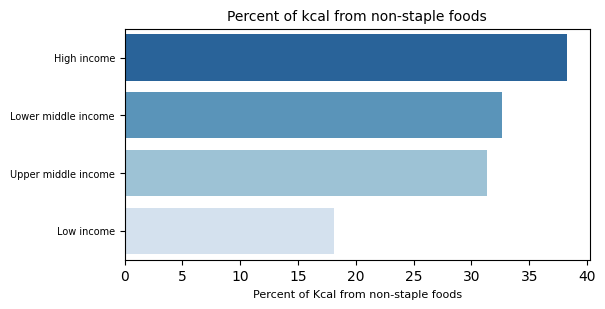

In [30]:
# Plotting the above information

fig, ax = plt.subplots()
fig.set_size_inches(6, 3)

df = calories_from_non_staples

bar_plotter(x="Percent of kcal from non-staple foods",
            y=df.index,
            df=df,
            ax=ax,
            xlabel="Percent of Kcal from non-staple foods",
            #ylabel="Income groups",
            palette="Blues_r")

plt.show()

In [31]:
# Number of countries from each group in this indicator:

daily_dietary_intake.groupby("Income group").count()

,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Starchs & Sugars,Dairy & Egg Products,Finfish / Shellfish Products,Poultry,Pork,Beef Products,Spices & Herbs,Legumes & Products,Vegetables,Fruits & Plantains,Infant food
Income group,,,,,,,,,,,,,,
High income,46,46,46,46,46,46,46,46,46,46,46,46,46,46
Low income,21,21,21,21,21,21,21,21,21,21,21,21,21,21
Lower middle income,44,44,44,44,44,44,44,44,44,44,44,44,44,44
Upper middle income,45,45,45,45,45,45,45,45,45,45,45,45,45,45


### Indicator 2: Shannon Diversity

In [32]:
# 1. Reading-in the dataset from FAO

food_supply = pd.read_csv('Food Quantity Data.csv',
                          sep= ',',
                          names= ['Country', 'Item', 'Value'])

#display(food_supply.head(30))

copy_food_supply = food_supply.copy(deep= True).drop(0)

display(copy_food_supply.head(10))

,Country,Item,Value
1,Afghanistan,Wheat and products,158.95
2,Afghanistan,Rice and products,17.21
3,Afghanistan,Barley and products,0.07
4,Afghanistan,Maize and products,3.53
5,Afghanistan,Rye and products,0
6,Afghanistan,Oats,0
7,Afghanistan,Millet and products,0.16
8,Afghanistan,"Cereals, Other",0
9,Afghanistan,Cassava and products,0.01
10,Afghanistan,Potatoes and products,26.49


In [33]:
# 2. Transposing the Data so that each country is represented as a one row:
transposed_copy_of_food_supply = copy_food_supply.pivot(
    index= 'Country',
    columns= 'Item',
    values= 'Value'
)

display(transposed_copy_of_food_supply.head())
#display(transposed_copy_of_food_supply.info())

Item,Apples and products,"Aquatic Animals, Others",Aquatic Plants,Bananas,Barley and products,Beans,Bovine Meat,"Butter, Ghee",Cassava and products,Cephalopods,...,Sugar non-centrifugal,Sunflower seed,Sunflowerseed Oil,Sweet potatoes,"Sweeteners, Other",Tea (including mate),Tomatoes and products,"Vegetables, other",Wheat and products,Yams
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2.95,NaN,NaN,3.11,0.07,0,2.73,0.97,0.01,NaN,...,NaN,NaN,1.27,0,0.54,2,0.89,55.39,158.95,NaN
Albania,32.66,0,0,8.26,0.2,5.03,13.2,1.52,0,0.72,...,NaN,NaN,4.72,0.01,24.22,0.15,77.88,217.39,124.68,NaN
Algeria,12.38,0,0,4.32,15.01,1.54,4.85,0.4,0,0.03,...,NaN,NaN,1.26,0,2.81,0.36,34.52,137.39,181.92,NaN
Angola,0.38,0,0,37.32,0,7.24,4.17,0.04,226.1,0,...,NaN,NaN,0.27,39.53,9.23,0.03,2.12,20.49,27.17,NaN
Antigua and Barbuda,5.47,NaN,0,17.87,0,1.03,6.74,1.26,0.78,0.25,...,NaN,0.04,0.09,2.33,28.34,0.73,5.82,44.71,68.7,1.35


In [34]:
# 3. Changing the data type. Data in all columns was as objects, not numbers.
transposed_copy_copy = transposed_copy_of_food_supply.copy(deep= True)#.fillna(0)

transposed_copy_cleaned = transposed_copy_copy.loc[:,:].astype('float')

#assert transposed_copy_cleaned.loc[:,:].dtype == 'float'

display(transposed_copy_cleaned.head())

Item,Apples and products,"Aquatic Animals, Others",Aquatic Plants,Bananas,Barley and products,Beans,Bovine Meat,"Butter, Ghee",Cassava and products,Cephalopods,...,Sugar non-centrifugal,Sunflower seed,Sunflowerseed Oil,Sweet potatoes,"Sweeteners, Other",Tea (including mate),Tomatoes and products,"Vegetables, other",Wheat and products,Yams
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2.95,NaN,NaN,3.11,0.07,0.00,2.73,0.97,0.01,NaN,...,NaN,NaN,1.27,0.00,0.54,2.00,0.89,55.39,158.95,NaN
Albania,32.66,0.0,0.0,8.26,0.20,5.03,13.20,1.52,0.00,0.72,...,NaN,NaN,4.72,0.01,24.22,0.15,77.88,217.39,124.68,NaN
Algeria,12.38,0.0,0.0,4.32,15.01,1.54,4.85,0.40,0.00,0.03,...,NaN,NaN,1.26,0.00,2.81,0.36,34.52,137.39,181.92,NaN
Angola,0.38,0.0,0.0,37.32,0.00,7.24,4.17,0.04,226.10,0.00,...,NaN,NaN,0.27,39.53,9.23,0.03,2.12,20.49,27.17,NaN
Antigua and Barbuda,5.47,NaN,0.0,17.87,0.00,1.03,6.74,1.26,0.78,0.25,...,NaN,0.04,0.09,2.33,28.34,0.73,5.82,44.71,68.70,1.35


In [35]:
# 4. Attaching countries' regions and sizes of economy
transposed_copy_with_size_and_region = pd.merge(size_of_economy,
                                                transposed_copy_cleaned,
                                                left_index=True,
                                                right_index=True
                                               )

display(transposed_copy_with_size_and_region.head())

,Income group,Region,Apples and products,"Aquatic Animals, Others",Aquatic Plants,Bananas,Barley and products,Beans,Bovine Meat,"Butter, Ghee",...,Sugar non-centrifugal,Sunflower seed,Sunflowerseed Oil,Sweet potatoes,"Sweeteners, Other",Tea (including mate),Tomatoes and products,"Vegetables, other",Wheat and products,Yams
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Low income,South Asia,2.95,NaN,NaN,3.11,0.07,0.00,2.73,0.97,...,NaN,NaN,1.27,0.00,0.54,2.00,0.89,55.39,158.95,NaN
Angola,Lower middle income,Sub-Saharan Africa,0.38,0.0,0.0,37.32,0.00,7.24,4.17,0.04,...,NaN,NaN,0.27,39.53,9.23,0.03,2.12,20.49,27.17,NaN
Albania,Upper middle income,Europe & Central Asia,32.66,0.0,0.0,8.26,0.20,5.03,13.20,1.52,...,NaN,NaN,4.72,0.01,24.22,0.15,77.88,217.39,124.68,NaN
United Arab Emirates,High income,Middle East & North Africa,6.75,0.0,0.0,8.55,NaN,2.30,6.59,1.29,...,NaN,0.26,0.80,0.46,1.91,0.12,5.23,45.76,91.81,0.3
Argentina,Upper middle income,Latin America & Caribbean,5.39,0.0,0.0,12.66,NaN,2.11,47.98,0.48,...,NaN,NaN,11.17,2.56,8.34,24.14,22.87,37.86,117.84,NaN


In [36]:
# 5. Dealing with Missing Data: Determining the type.

## 5.1. Checking to see if there is any relationship between income group and missing data on a specific food item:

transposed_copy_nullity = transposed_copy_cleaned.isnull()

# display(transposed_copy_nullity)

transposed_copy_nullity_with_regions = pd.merge(size_of_economy,
                                                transposed_copy_nullity,
                                                left_index=True,
                                                right_index=True
                                               )
#display(transposed_copy_nullity_with_regions.head())

country_count_each_inc_group = pd.DataFrame(transposed_copy_with_size_and_region['Income group'].value_counts())

country_count_each_inc_group.columns = ['Total Count']

display(country_count_each_inc_group)

,Total Count
Income group,
High income,46
Upper middle income,45
Lower middle income,44
Low income,21


In [37]:
## 5.2. Percentage of missing values for each food group in each income group
nullity_by_income_group = transposed_copy_nullity_with_regions.groupby('Income group').sum().iloc[:, 1:]

count_of_countries = transposed_copy_nullity_with_regions.groupby('Income group').count().iloc[:, 1:]

percentage_of_nullity_of_food_groups = nullity_by_income_group.div(count_of_countries) * 100

display(percentage_of_nullity_of_food_groups)


,Apples and products,"Aquatic Animals, Others",Aquatic Plants,Bananas,Barley and products,Beans,Bovine Meat,"Butter, Ghee",Cassava and products,Cephalopods,...,Sugar non-centrifugal,Sunflower seed,Sunflowerseed Oil,Sweet potatoes,"Sweeteners, Other",Tea (including mate),Tomatoes and products,"Vegetables, other",Wheat and products,Yams
Income group,,,,,,,,,,,,,,,,,,,,,
High income,0.0,6.521739,2.173913,0.000000,4.347826,4.347826,0.0,0.0,50.000000,2.173913,...,95.652174,47.826087,0.000000,13.043478,0.0,0.0,0.0,0.0,0.0,32.608696
Low income,0.0,33.333333,14.285714,4.761905,0.000000,0.000000,0.0,0.0,0.000000,9.523810,...,90.476190,52.380952,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,33.333333
Lower middle income,0.0,9.090909,4.545455,2.272727,0.000000,2.272727,0.0,0.0,6.818182,0.000000,...,68.181818,40.909091,0.000000,9.090909,0.0,0.0,0.0,0.0,0.0,50.000000
Upper middle income,0.0,4.444444,0.000000,0.000000,4.444444,6.666667,0.0,0.0,15.555556,0.000000,...,80.000000,35.555556,2.222222,2.222222,0.0,0.0,0.0,0.0,0.0,44.444444


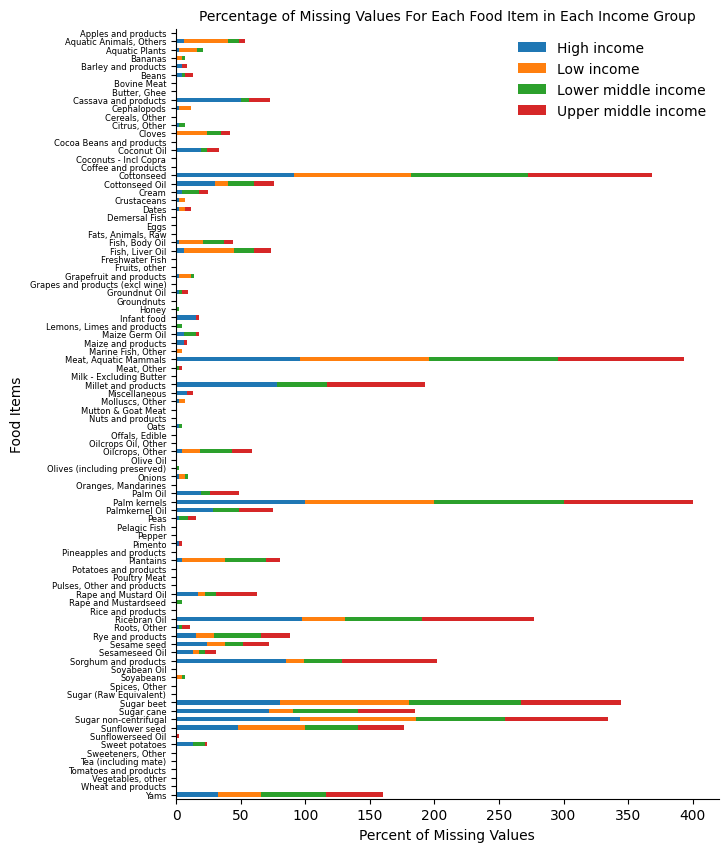

In [38]:
percentage_of_nullity_of_food_groups_pivoted = percentage_of_nullity_of_food_groups.T

#display(percentage_of_nullity_of_food_groups_pivoted)



## 5.3. Visualizing Missingness

#fig = plt.figure()
#fig.set_size_inches(10, 7)

ax = percentage_of_nullity_of_food_groups_pivoted.plot(kind= 'barh',
                                  stacked=True)

ax.figure.set_size_inches(7, 10)
ax.set(xlabel='Percent of Missing Values',
       ylabel='Food Items')
ax.legend(loc='upper right', frameon=False)
for spine in ['top', 'right'] :
    ax.spines[spine].set_visible(False)
ax.set_title('Percentage of Missing Values For Each Food Item in Each Income Group', fontdict={'fontsize' :10})
ax.tick_params(axis='y', which= 'major', labelsize=6)
ax.invert_yaxis()


# plt.savefig("missing_values_shannon.png")

In [39]:
## 5.4. Encoding the categorical values of Region and Size of Economy:  

### 5.4.1. Making sure there aren't any missing values

regions_nullity = transposed_copy_with_size_and_region['Region'].isnull()

size_of_economy_nullity = transposed_copy_with_size_and_region['Income group'].isnull()

print("Region nullity: {}".format(regions_nullity.sum()))

print("Nullity in Size of Economy: {}".format(size_of_economy_nullity.sum()))


Region nullity: 0
Nullity in Size of Economy: 0


In [40]:
## There was one un-classified country in-terms of size-of-economy: Venezuela. Up to the time you're reading this, it is no longer in the dataset. So run the block as it is.

size_of_economy_missing_val = size_of_economy_nullity[size_of_economy_nullity == True]

display(size_of_economy_missing_val)


# Removing Venezuela
#adjusted_transposed_copy = transposed_copy_with_size_and_region.drop('Venezuela, RB', axis=0)

adjusted_transposed_copy = transposed_copy_with_size_and_region

size_of_economy_nullity_updated = adjusted_transposed_copy['Income group'].isnull().sum()

#print("Updated Number of Nullity at Size of Economy / Income group: {}".format(size_of_economy_nullity_updated))


Series([], Name: Income group, dtype: bool)

In [41]:
# Encoding
encoder = OrdinalEncoder()

regions = adjusted_transposed_copy['Region']

income_groups = adjusted_transposed_copy['Income group']

display(pd.DataFrame(regions.unique()))
display(pd.DataFrame(income_groups.unique()))


,0
0,South Asia
1,Sub-Saharan Africa
2,Europe & Central Asia
3,Middle East & North Africa
4,Latin America & Caribbean
5,East Asia & Pacific
6,North America


,0
0,Low income
1,Lower middle income
2,Upper middle income
3,High income


In [42]:
reshaped_regions = regions.values.reshape(-1, 1)

reshaped_income_groups = income_groups.values.reshape(-1, 1)

#display(reshaped_regions)

encoded_regions = encoder.fit_transform(reshaped_regions)

encoded_income_groups = encoder.fit_transform(reshaped_income_groups)
adjusted_transposed_copy_for_encoding = adjusted_transposed_copy.copy(deep=True)

adjusted_transposed_copy_for_encoding[adjusted_transposed_copy_for_encoding.columns[1]] = np.squeeze(encoded_regions)
#adjusted_transposed_copy_for_encoding.loc[:, 'Region'] = np.squeeze(encoded_regions) ---> A clearer code, but results into a FutureWarning Error

adjusted_transposed_copy_for_encoding[adjusted_transposed_copy_for_encoding.columns[0]] = np.squeeze(encoded_income_groups)
#adjusted_transposed_copy_for_encoding.loc[:, 'Income group'] = np.squeeze(encoded_income_groups)

display(adjusted_transposed_copy_for_encoding.head(10))


,Income group,Region,Apples and products,"Aquatic Animals, Others",Aquatic Plants,Bananas,Barley and products,Beans,Bovine Meat,"Butter, Ghee",...,Sugar non-centrifugal,Sunflower seed,Sunflowerseed Oil,Sweet potatoes,"Sweeteners, Other",Tea (including mate),Tomatoes and products,"Vegetables, other",Wheat and products,Yams
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.0,5.0,2.95,NaN,NaN,3.11,0.07,0.00,2.73,0.97,...,NaN,NaN,1.27,0.00,0.54,2.00,0.89,55.39,158.95,NaN
Angola,2.0,6.0,0.38,0.00,0.0,37.32,0.00,7.24,4.17,0.04,...,NaN,NaN,0.27,39.53,9.23,0.03,2.12,20.49,27.17,NaN
Albania,3.0,1.0,32.66,0.00,0.0,8.26,0.20,5.03,13.20,1.52,...,NaN,NaN,4.72,0.01,24.22,0.15,77.88,217.39,124.68,NaN
United Arab Emirates,0.0,3.0,6.75,0.00,0.0,8.55,NaN,2.30,6.59,1.29,...,NaN,0.26,0.80,0.46,1.91,0.12,5.23,45.76,91.81,0.30
Argentina,3.0,2.0,5.39,0.00,0.0,12.66,NaN,2.11,47.98,0.48,...,NaN,NaN,11.17,2.56,8.34,24.14,22.87,37.86,117.84,NaN
Armenia,3.0,1.0,10.58,0.00,0.0,7.17,3.89,1.08,24.31,1.34,...,NaN,NaN,6.79,0.00,28.19,0.14,44.05,159.06,125.79,NaN
Antigua and Barbuda,0.0,2.0,5.47,NaN,0.0,17.87,0.00,1.03,6.74,1.26,...,NaN,0.04,0.09,2.33,28.34,0.73,5.82,44.71,68.70,1.35
Australia,0.0,0.0,11.03,0.07,0.0,11.07,0.00,1.79,26.12,3.81,...,NaN,NaN,0.58,2.52,7.43,0.53,15.82,61.31,76.62,0.02
Austria,0.0,1.0,20.77,0.02,0.0,13.60,0.91,0.16,16.08,5.20,...,NaN,0.95,5.79,0.24,3.58,0.34,13.83,75.84,76.33,0.00


In [43]:
## 5.5. Preparing Data For Imputation

excessive_missing_values = percentage_of_nullity_of_food_groups_pivoted[percentage_of_nullity_of_food_groups_pivoted.iloc[:, :] > 40]

display(excessive_missing_values.info())


<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, Apples and products to Yams
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   High income          11 non-null     float64
 1   Low income           6 non-null      float64
 2   Lower middle income  9 non-null      float64
 3   Upper middle income  10 non-null     float64
dtypes: float64(4)
memory usage: 5.6+ KB


None

In [44]:
items_without_excessive_missingness = percentage_of_nullity_of_food_groups_pivoted[percentage_of_nullity_of_food_groups_pivoted.iloc[:, :] < 40].dropna()

#display(items_without_excessive_missingness.info())

items_without_excessive_missingness_transposed = items_without_excessive_missingness.T

food_item_list = list(items_without_excessive_missingness_transposed.columns)

#display(food_item_list)


raw_data_for_imputation = adjusted_transposed_copy_for_encoding[food_item_list]

complete_data_for_imputation = pd.merge(adjusted_transposed_copy_for_encoding.iloc[:, 0:2],
                                        raw_data_for_imputation,
                                        left_index=True,
                                        right_index=True)

#display(complete_data_for_imputation.info())



## 5.6.1. Imputing by KNN

knn_imputer = KNN()

imputed_by_knn = pd.DataFrame(knn_imputer.fit_transform(complete_data_for_imputation),
                              columns=complete_data_for_imputation.columns)


## 5.6.2. Imputing by MICE

mice = IterativeImputer()

imputed_by_mice = np.round(pd.DataFrame(mice.fit_transform(complete_data_for_imputation),
                                        index=complete_data_for_imputation.index,
                                        columns=complete_data_for_imputation.columns), 1)


## 5.6.3. Evaluating accuracy of the two methods

# Checking the R-Statistic

# KNN_imputed:

Xknn = sm.add_constant(imputed_by_knn.iloc[:, :-1])
yknn = imputed_by_knn.iloc[:, -1]
lm_knn = sm.OLS(yknn, Xknn).fit()


# MICE_imputed:
Xmice = sm.add_constant(imputed_by_mice.iloc[:, :-1])
ymice = imputed_by_mice.iloc[:, -1]
lm_mice = sm.OLS(ymice, Xmice).fit()



r_squares = pd.DataFrame(dict(KNN_Imputed = lm_knn.rsquared,
                              MICE_Imputed = lm_mice.rsquared), 
                         index= ['Adj. Rsquared'])

coefficients = pd.DataFrame(dict(KNN_Imputed = lm_knn.params,
                                 MICE_Imputed = lm_mice.params))

coefficients_combined = pd.concat((r_squares, coefficients), axis= 0)

display(coefficients_combined.head(2))

#coefficients_combined.to_csv('MICE_vs_KNN_2nd_indicator.csv')

Imputing row 1/156 with 10 missing, elapsed time: 0.040
Imputing row 101/156 with 4 missing, elapsed time: 0.058


,KNN_Imputed,MICE_Imputed
Adj. Rsquared,0.882185,0.890507
const,116.161064,115.261280


In [45]:
#display(imputed_by_mice.info())

# Creating a list of Food Items. Use this as a reference when aggregating food items into food groups.
food_items = pd.DataFrame(list(imputed_by_mice.columns),
                          columns= ['Food Items'])
#food_items.to_csv('Food_Items_mod.csv', index=False)



# Combining Foods into Food Groups:
aggregated_food_supplies = {
    'Cereals' : 0,
    'Roots & Tubers' : 0,
    'Vegetables' : 0,
    'Fruits & Plantains' : 0,
    'Seeds, Nuts, and Oils' : 0,
    'Starch and Sugars' : 0,
    'Infant Food' : 0
}


#aggregated_food_supplies['Income group'] = imputed_by_mice['Income group'].values.reshape(-1, 1)

aggregated_food_supplies['Cereals'] = \
        imputed_by_mice['Barley and products'] + \
        imputed_by_mice['Wheat and products'] + \
        imputed_by_mice['Cereals, Other'] + \
        imputed_by_mice['Maize and products'] + \
        imputed_by_mice['Oats'] + \
        imputed_by_mice['Rice and products'] + \
        imputed_by_mice['Rye and products']


aggregated_food_supplies['Roots & Tubers'] = \
        imputed_by_mice['Potatoes and products'] + \
        imputed_by_mice['Roots, Other'] + \
        imputed_by_mice['Sweet potatoes']


aggregated_food_supplies["Dairy and Egg Products"] = \
        imputed_by_mice['Butter, Ghee'] + \
        imputed_by_mice['Cream'] + \
        imputed_by_mice['Eggs'] + \
        imputed_by_mice['Milk - Excluding Butter']


aggregated_food_supplies["Finfish / Shellfish Products"] = \
        imputed_by_mice['Cephalopods'] + \
        imputed_by_mice['Crustaceans'] + \
        imputed_by_mice['Demersal Fish'] + \
        imputed_by_mice['Freshwater Fish'] + \
        imputed_by_mice['Marine Fish, Other'] + \
        imputed_by_mice['Molluscs, Other'] + \
        imputed_by_mice['Pelagic Fish']

aggregated_food_supplies['Beef Products'] = \
        imputed_by_mice['Aquatic Animals, Others'] + \
        imputed_by_mice['Bovine Meat'] + \
        imputed_by_mice['Fats, Animals, Raw'] + \
        imputed_by_mice['Meat, Other'] + \
        imputed_by_mice['Mutton & Goat Meat'] + \
        imputed_by_mice['Offals, Edible']

aggregated_food_supplies["Poultry"] = \
        imputed_by_mice['Poultry Meat']
    
aggregated_food_supplies['Starch and Sugars'] = \
        imputed_by_mice['Honey'] + \
        imputed_by_mice['Sweeteners, Other'] + \
        imputed_by_mice['Sugar (Raw Equivalent)']
        

aggregated_food_supplies["Legume and Legume Products"] = \
        imputed_by_mice['Beans'] + \
        imputed_by_mice['Peas'] + \
        imputed_by_mice['Soyabeans'] + \
        imputed_by_mice['Pulses, Other and products']


aggregated_food_supplies["Spices & Herbs"] = \
        imputed_by_mice['Cloves'] + \
        imputed_by_mice['Spices, Other'] + \
        imputed_by_mice['Tea (including mate)']

aggregated_food_supplies['Vegetables'] = \
        imputed_by_mice['Aquatic Plants'] + \
        imputed_by_mice['Onions'] + \
        imputed_by_mice['Pepper'] + \
        imputed_by_mice['Pimento'] + \
        imputed_by_mice['Vegetables, other'] + \
        imputed_by_mice['Tomatoes and products']
        
    
aggregated_food_supplies['Fruits & Plantains'] = \
        imputed_by_mice['Apples and products'] + \
        imputed_by_mice['Bananas'] + \
        imputed_by_mice['Citrus, Other'] + \
        imputed_by_mice['Oranges, Mandarines'] + \
        imputed_by_mice['Dates'] + \
        imputed_by_mice['Fruits, other'] + \
        imputed_by_mice['Grapefruit and products'] + \
        imputed_by_mice['Grapes and products (excl wine)'] + \
        imputed_by_mice['Lemons, Limes and products'] + \
        imputed_by_mice['Olives (including preserved)'] + \
        imputed_by_mice['Pineapples and products'] + \
        imputed_by_mice['Plantains']
    
    
aggregated_food_supplies['Seeds, Nuts, and Oils'] = \
        imputed_by_mice['Cocoa Beans and products'] + \
        imputed_by_mice['Coconut Oil'] + \
        imputed_by_mice['Coconuts - Incl Copra'] + \
        imputed_by_mice['Coffee and products'] + \
        imputed_by_mice['Cottonseed Oil'] + \
        imputed_by_mice['Fish, Body Oil'] + \
        imputed_by_mice['Fish, Liver Oil'] + \
        imputed_by_mice['Groundnut Oil'] + \
        imputed_by_mice['Groundnuts'] + \
        imputed_by_mice['Nuts and products'] + \
        imputed_by_mice['Maize Germ Oil'] + \
        imputed_by_mice['Oilcrops Oil, Other'] + \
        imputed_by_mice['Oilcrops, Other'] + \
        imputed_by_mice['Olive Oil'] + \
        imputed_by_mice['Palm Oil'] + \
        imputed_by_mice['Palmkernel Oil'] + \
        imputed_by_mice['Rape and Mustard Oil'] + \
        imputed_by_mice['Rape and Mustardseed'] + \
        imputed_by_mice['Sesame seed'] + \
        imputed_by_mice['Sesameseed Oil'] + \
        imputed_by_mice['Sunflowerseed Oil'] + \
        imputed_by_mice['Soyabean Oil']
    
    
aggregated_food_supplies['Infant Food'] = \
        imputed_by_mice['Infant food']



df_aggregated_food_supplies = pd.merge(adjusted_transposed_copy[['Income group', 'Region']],
                                       pd.DataFrame(aggregated_food_supplies, index=imputed_by_mice.index),
                                       left_index=True,
                                       right_index=True).sort_values('Income group')

display(df_aggregated_food_supplies.head(5))

# df_aggregated_food_supplies.to_csv('1_Aggregated_Food_Supplies.csv', index=True) 

,Income group,Region,Cereals,Roots & Tubers,Vegetables,Fruits & Plantains,"Seeds, Nuts, and Oils",Starch and Sugars,Infant Food,Dairy and Egg Products,Finfish / Shellfish Products,Beef Products,Poultry,Legume and Legume Products,Spices & Herbs
Country,,,,,,,,,,,,,,,
Spain,High income,Europe & Central Asia,113.1,60.3,120.2,93.7,48.5,32.5,0.4,182.0,40.8,21.8,33.3,5.8,0.4
Chile,High income,Latin America & Caribbean,153.3,57.9,71.9,59.9,10.8,41.2,0.0,94.1,14.0,26.8,38.7,3.9,1.5
Iceland,High income,Europe & Central Asia,84.4,35.6,77.2,89.1,28.0,80.6,0.3,232.1,91.2,42.8,31.4,1.1,1.6
Sweden,High income,Europe & Central Asia,115.0,53.9,85.1,60.9,21.8,46.5,0.3,234.7,32.3,32.8,16.3,2.5,1.1
Slovenia,High income,Europe & Central Asia,140.1,38.1,99.5,104.7,16.6,44.7,0.0,192.0,13.2,20.9,29.1,1.4,0.3


In [46]:
# Creating a function for calculating Shannon_diversity

def Shannon_diversity(dataframe) :
    """Calculates Shannon Diversity from the DataFrame"""

    # Creating the "Total Column"
    dataframe.loc[:, "Total"] = dataframe.sum(axis=1)


    # Removing zeroes and NaNs (Dividing columns with these values to the total will bring something nobody wants.)
    some_list = list()
    
    for i, val in dataframe.iterrows():
        j = dataframe.loc[[i]].dropna(axis=1)

        j = j.loc[:, (j != 0).any(axis=0)]

        some_list.append(j)

    
    # The Shannon Diversity Index
    container_1 = list()

    for i in range(len(some_list)):
        frame = some_list[i]

        container_2 = list()

        for col in frame :
            if col != "Total":
                d_index = abs(frame[col] / frame["Total"] * np.log(frame[col] / frame["Total"]))

                container_2.append(d_index)
            else:
                continue

            index_array = np.array(container_2).sum()


        container_1.append(index_array)


    dataframe.loc[:, "Production Diversity Indeces"] = container_1

    return pd.DataFrame(dataframe.loc[:, "Production Diversity Indeces"])

In [47]:
# Calculating Shannon Diversity Indeces for countries in the food supply table

food_supply_diversity_shannon = Shannon_diversity(df_aggregated_food_supplies.iloc[:, 2:])

food_supply_diversity_shannon

,Production Diversity Indeces
Country,
Spain,2.138885
Chile,2.105233
Iceland,2.115612
Sweden,2.019177
Slovenia,1.987958
...,...
Mexico,2.034659
Ecuador,1.950009
Dominican Republic,1.849328


In [48]:
# Attaching the Shannon data with sizes of economy

food_supply_diversity_economized = pd.merge(size_of_economy,
                                            food_supply_diversity_shannon,
                                            left_index=True,
                                            right_index=True).drop("Region", axis=1)

food_supply_diversity_economized

,Income group,Production Diversity Indeces
Country,,
Afghanistan,Low income,1.698129
Angola,Lower middle income,1.966925
Albania,Upper middle income,1.792816
United Arab Emirates,High income,2.225301
Argentina,Upper middle income,2.158191
...,...,...
Vanuatu,Lower middle income,1.939273
Samoa,Lower middle income,2.091022
South Africa,Upper middle income,2.011364


In [49]:
# Separating Income groups and scaling them

scaled_shannon_low_income = scaler(food_supply_diversity_economized[food_supply_diversity_economized["Income group"] == "Low income"], column= "Production Diversity Indeces")

scaled_shannon_lower_middle = scaler(food_supply_diversity_economized[food_supply_diversity_economized["Income group"] == "Lower middle income"], column="Production Diversity Indeces")

scaled_shannon_upper_middle = scaler(food_supply_diversity_economized[food_supply_diversity_economized["Income group"] == "Upper middle income"], column="Production Diversity Indeces")

scaled_shannon_high_income = scaler(food_supply_diversity_economized[food_supply_diversity_economized["Income group"] == "High income"], column="Production Diversity Indeces")


scaled_total = pd.concat([scaled_shannon_low_income,
                          scaled_shannon_lower_middle,
                          scaled_shannon_upper_middle,
                          scaled_shannon_high_income])

scaled_total.head()

C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scaled Values"] = scaled_values
C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scaled Values"] = scaled_values
C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,Income group,Production Diversity Indeces,Scaled Values
Country,,,
Afghanistan,Low income,1.698129,51.523755
Burundi,Low income,1.712999,51.225450
Burkina Faso,Low income,2.037007,45.137343
Central African Republic,Low income,2.168598,42.876461
Ethiopia,Low income,1.715936,51.166725


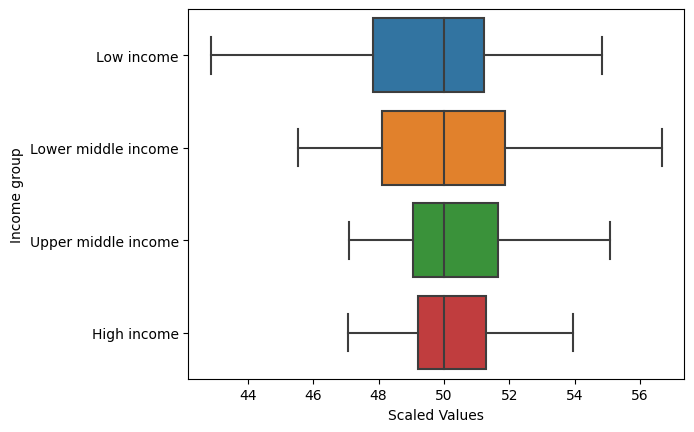

In [50]:
# Plotting the Box plots to check for extreme values

fig, ax = plt.subplots()

sns.boxplot(data=scaled_total, x="Scaled Values", y="Income group")

plt.show()

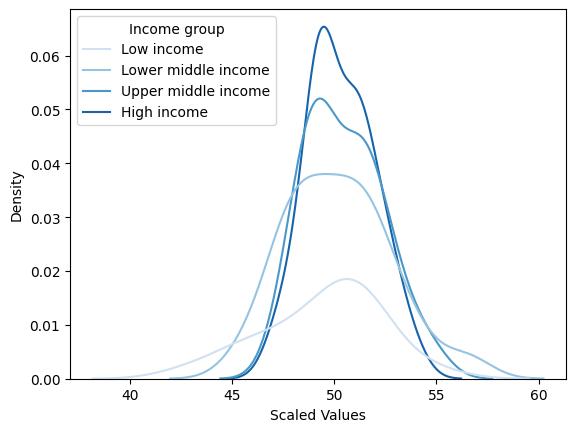

In [51]:
# Plotting the Distribution curve to see normality

fig, ax = plt.subplots()

sns.kdeplot(data=scaled_total, x="Scaled Values", hue="Income group", palette="Blues")

plt.show()

In [52]:
# Normality and Heteroskedasticity are good. Moving on to EDA and ANOVA

# Renaming the columns so that they can be able to be processed by the ANOVA model

scaled_total.columns = ["income_group", "diversity_indeces", "scaled_diversity_indeces"]

scaled_total.head()

,income_group,diversity_indeces,scaled_diversity_indeces
Country,,,
Afghanistan,Low income,1.698129,51.523755
Burundi,Low income,1.712999,51.225450
Burkina Faso,Low income,2.037007,45.137343
Central African Republic,Low income,2.168598,42.876461
Ethiopia,Low income,1.715936,51.166725


In [53]:
# Exploratory Data Analysis: Whlich country group has higher diversity

food_diversity_grouped_by_mean = scaled_total.groupby("income_group").mean()

display(food_diversity_grouped_by_mean)

food_diversity_grouped_by_median = scaled_total.groupby("income_group").median()

display(food_diversity_grouped_by_median)

,diversity_indeces,scaled_diversity_indeces
income_group,,
High income,2.071434,50.315560
Low income,1.808516,49.431993
Lower middle income,1.848279,50.187124
Upper middle income,1.986051,50.452815


,diversity_indeces,scaled_diversity_indeces
income_group,,
High income,2.088878,50.000023
Low income,1.775004,50.000000
Lower middle income,1.854956,50.000141
Upper middle income,2.010195,50.000000


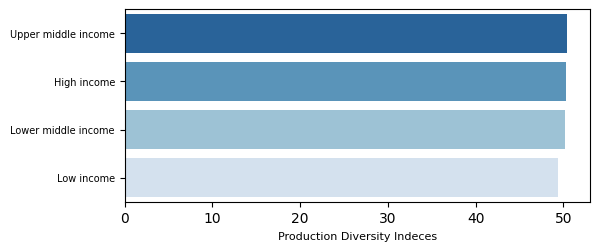

In [54]:
# Plotting the information above

fig, ax = plt.subplots()
fig.set_size_inches(6, 2.5)

df = food_diversity_grouped_by_mean.sort_values("scaled_diversity_indeces", ascending=False)

bar_plotter(x="scaled_diversity_indeces",
            y= df.index,
            df=df,
            ax=ax,
            xlabel="Production Diversity Indeces",
            palette="Blues_r")

ax.set_title("")

plt.show()

In [55]:
# ANOVA

# Creating and fitting the linear model
model = ols("scaled_diversity_indeces ~ C(income_group)", data=scaled_total).fit()

# Accessing ANOVA coefficients
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table



,sum_sq,df,F,PR(>F)
C(income_group),15.884308,3.0,1.115425,0.344756
Residual,721.522861,152.0,NaN,NaN


In [56]:
# Number of countries from each group in this indicator

df_aggregated_food_supplies.groupby("Income group").count().iloc[:, 0]

Income group
High income            46
Low income             21
Lower middle income    44
Upper middle income    45
Name: Region, dtype: int64

### Indicator 3: Modified Functional Attibutite Diversity

In [57]:
#1. Merging the Food Supply Data from FAO and the Food Composition table.

# 1.1 Taking a glimpse of the food supply data to see the names of the foods used there.

display(imputed_by_mice.head(3))

,Income group,Region,Apples and products,"Aquatic Animals, Others",Aquatic Plants,Bananas,Barley and products,Beans,Bovine Meat,"Butter, Ghee",...,Soyabeans,"Spices, Other",Sugar (Raw Equivalent),Sunflowerseed Oil,Sweet potatoes,"Sweeteners, Other",Tea (including mate),Tomatoes and products,"Vegetables, other",Wheat and products
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.0,5.0,3.0,0.1,-0.0,3.1,0.1,0.0,2.7,1.0,...,0.0,0.1,15.2,1.3,0.0,0.5,2.0,0.9,55.4,159.0
Angola,2.0,6.0,0.4,0.0,0.0,37.3,0.0,7.2,4.2,0.0,...,0.4,0.0,12.5,0.3,39.5,9.2,0.0,2.1,20.5,27.2
Albania,3.0,1.0,32.7,0.0,0.0,8.3,0.2,5.0,13.2,1.5,...,0.0,0.0,16.6,4.7,0.0,24.2,0.2,77.9,217.4,124.7


In [58]:
# 1.2 Importing the Food Composition Data

# food_composition_table = pd.read_csv('food_composition_data.csv')

# display(food_composition_table.head())


# food_composition_table.pivot_table(index= ["food_name", "food_group"],
#                                    columns="nutr_name",
#                                    values="nutr_value").iloc[60:80]

In [59]:
# DO NOT RUN THIS PIECE OF CODE. ITS OUTPUT HAS ALREADY BEEN SAVED AND USED IN THE FOLLOWING CODE SNIPPETS.


## 1.5 Condensing food items such that we've a median value of nutrient values of each nutrient from each food type.

### I. Take a peek of your data

#display(food_composition_transposed.head())


### II. The initial columns' names are confusing. Taking them to the back

# food_compos_modified = food_composition_transposed[food_composition_transposed.columns.sort_values(ascending=False)]

#display(food_compos_modified.head())



### III. We don't want an index name for the columns. Removing it, and resetting row indexes to be food codes.

# better_food_compos_table = food_compos_modified.rename_axis(None, axis=1).reset_index()

# better_food_compos_table_1 = better_food_compos_table.set_index('food_code')

#display(better_food_compos_table_1.head())



### IV. Beginning condensing the foods: Writting a program that will do just that

# condensed_foods = pd.DataFrame()

# food_compos_aft_reduction = pd.DataFrame


def food_condenser() :    
    """ Condenses similar food types of a similar food group from the food_composition table """
    
    
    # Designing a better user experience btn the 1st iteration and the subsequent ones
    first_iter = 0
    
    new_iter = 0
    
    
    # Iteration starts
    while new_iter == first_iter :
        
        new_iter = 1 + first_iter
        
        start = input('Welcome. Should I start condensing? [Y/n]: ').upper()
        
        while start == 'Y' :
    
            print("""
            This is a preview of the food composition table as it is now. \n
            Please choose any word from the "food_name" column and the "food_group" column \n
            and then enter them in the prompts that follow..\n
            DO NOT WRITE the whole string for the food name, just the main food type (eg. butter, cheese, etc,)
            For the Food Group name, write the whole name. \n
            
            ATTENTION: Names in the "food_group" column are case sensitive.
            """.upper())
        
            display(better_food_compos_table_1.head(4))
            
            
            # Taking the group name
            food_group = input('Please write the food_group name: ')
            
            
            # Filtering the main_compos table for the aforementioned food_group
            group = better_food_compos_table_1[better_food_compos_table_1['food_group'].str.contains(food_group)]
            
            
            # Cutting of the desired food_group from the main-compos table
            remaining_groups = better_food_compos_table_1[ ~better_food_compos_table_1['food_group'] \
                                                         .isin(group['food_group'])
                                                        ]
            
            
            # Updating the food_compos table such that we only have food that haven't been condensed:
            food_compos_aft_reduction = remaining_groups
            
            
            # Getting the medium values for all nutrients in the desired food_and_food_group table
            median_vals = pd.DataFrame(data=group.iloc[:, 2:].aggregate('median', axis=0)).T
            
            
            # Attaching the food_name and food_group_name to the median values
            food_name = pd.DataFrame(data=[food_group], columns=['food_group'])

            compressed_values = pd.concat([food_name, median_vals], axis=1)
            
            
            # Attaching this to the "Condensed_foods" table
            
            global condensed_foods
            
            condensed_foods = pd.concat([condensed_foods, compressed_values], axis=0)
            
            display(condensed_foods)
            
            start = 'n'

    
    # For Subsequent iterations
    continuation = input('Do you want to repeat this process? [Y/n]: ').upper()
    
    
    while continuation == 'Y' :
            
        count = new_iter + 1
            
        print("""The names in the "food_group" column are case sensitive, remember that.\n
        This is the preview of the table as it is now.""".upper())
            
        display(food_compos_aft_reduction.head(4))
            
            
        # Taking the name of the food
        #name = input('Please write the food name: ').upper()
            
            
        # Taking the group name
        food_group = input('Please write the food_group name: ')
            
            
        # Filtering the main_compos table for the aforementioned food
        group = food_compos_aft_reduction[food_compos_aft_reduction['food_group'].str.contains(food_group)]
            
            
        # Cutting of the desired food from the main-compos table
        remaining_groups = food_compos_aft_reduction[ ~food_compos_aft_reduction['food_name'] \
                                                         .isin(group['food_name'])
                                                        ]
            
            
        # Updating the food_compos table such that we only have food that haven't been condensed:
        food_compos_aft_reduction = remaining_groups
            
            
        # Getting the medium values for all nutrients in the desired food_and_food_group table
        median_vals = pd.DataFrame(data=group.iloc[:, 2:].aggregate('median', axis=0)).T
            
            
        # Attaching the food_name and food_group_name to the median values
        food_name = pd.DataFrame(data=[food_group], columns=['food_group'])

        compressed_values = pd.concat([food_name, median_vals], axis=1)
            
            
        # Attaching this to the "Condensed_foods" table
        condensed_foods = pd.concat([condensed_foods, compressed_values], axis=0)
        
        
        # displaying the new "condensed_foods" table
        display(condensed_foods)
                
        # Re-running the procedure
        continuation = input('Do you want to repeat this process? [Y/n]: ').upper()
        
        
    return condensed_foods


# Condensing: Iteration 1:
#food_condenser()

#display(condensed_foods)

##### Notes for the food condenser

I took the median value for each food group to make the process of condensing the foods easier and straightforward.  

There were too many foods, and their names were formatted differently. The way I've done it is the easiest way to be able to generalize the nutrition value for each food group.

In [60]:
# Saving the output table to a variable and resetting the index
#condensed_food_compos = condensed_foods.reset_index()

#display(condensed_food_compos)


# Removing the first "index" column:
#condensed_food_compos_table = condensed_food_compos.drop("index", axis=1)

#display(condensed_food_compos_table)


# Saving the output to csv:
#condensed_food_compos_table.to_csv("Condensed_Food_Composition_Table.csv", index=True)

In [61]:
# UPLOADING THE TABLE ABOVE AGAIN AFTER SOME TIME

nutritional_content_table = pd.read_csv("01. Clean Datasets/Metric_1/Indicator_3/1_Condensed_Food_Composition_Table.csv")

display(nutritional_content_table.head())

,Unnamed: 0,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
0,0,Dairy and Egg Products,0.825,63.550,0.6,0.0,0.18,0.5,0.0,0.5,...,0.0335,0.1210,1.9930,0.0,0.020,0.016,0.297,0.0000,0.093,0.076
1,1,Spices and Herbs,2.840,9.310,24.6,0.0,1.69,NaN,NaN,0.0,...,0.0000,0.0080,0.5740,0.0,0.000,0.000,0.020,0.0000,0.002,0.000
2,2,Baby Foods,0.490,83.200,5.1,0.0,0.56,0.1,0.0,0.0,...,0.0000,0.0010,0.4260,0.0,0.000,0.000,0.031,0.0000,0.007,0.001
3,3,Fats and Oils,0.000,0.070,42.2,0.0,5.00,0.7,0.0,0.0,...,0.0000,0.0685,7.9895,0.0,0.014,0.000,0.095,0.0005,0.000,0.000
4,4,Poultry Products,2.020,66.505,0.0,0.0,0.22,0.2,NaN,0.2,...,0.0040,0.1970,1.5200,0.0,0.006,0.008,0.056,NaN,0.010,0.000


In [62]:
# Removing the column "Unnamed" and the last row that is empty:
nutrition_table = nutritional_content_table.iloc[:17, 1:].set_index("food_group")

#display(nutrition_table)

groups_nutrition_table = nutrition_table.index

#display(groups_nutrition_table)



# Combining the groups such that one has groups equal to the ones in the intake tables.
nutrition_table

nutrition_table.loc["Beef Products"] = nutrition_table.loc["Beef Products"] + \
                                       nutrition_table.loc["Sausages and Luncheon Meats"]

nutrition_table.loc["Seeds, Nuts, and Oils"] = nutrition_table.loc["Nut and Seed Products"] + \
                                    nutrition_table.loc["Fats and Oils"]

nutrition_table.loc["Breakfast Cereals"] = nutrition_table.loc["Breakfast Cereals"] + \
                                           nutrition_table.loc["Soups, Sauces, and Gravies"] + \
                                           nutrition_table.loc["Snacks"]

nutrition_table = nutrition_table.drop(["Sausages and Luncheon Meats", 
                                        "Fats and Oils", 
                                        "Soups, Sauces, and Gravies", 
                                        "Snacks",
                                        "Nut and Seed Products"])

nutrition_table

,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),Vitamin D,"Vitamin C, total ascorbic acid",...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
food_group,,,,,,,,,,,,,,,,,,,,,
Dairy and Egg Products,0.825,63.550,0.60,0.0,0.180,0.50,0.00,0.50,20.0,0.0,...,0.0335,0.1210,1.9930,0.0,0.020,0.0160,0.2970,0.0000,0.0930,0.0760
Spices and Herbs,2.840,9.310,24.60,0.0,1.690,NaN,NaN,0.00,0.0,15.2,...,0.0000,0.0080,0.5740,0.0,0.000,0.0000,0.0200,0.0000,0.0020,0.0000
Baby Foods,0.490,83.200,5.10,0.0,0.560,0.10,0.00,0.00,2.0,7.9,...,0.0000,0.0010,0.4260,0.0,0.000,0.0000,0.0310,0.0000,0.0070,0.0010
Poultry Products,2.020,66.505,0.00,0.0,0.220,0.20,NaN,0.20,7.0,0.0,...,0.0040,0.1970,1.5200,0.0,0.006,0.0080,0.0560,NaN,0.0100,0.0000
Breakfast Cereals,4.310,97.495,4.55,0.0,2.430,NaN,NaN,3.55,141.0,9.0,...,NaN,NaN,2.6180,NaN,NaN,NaN,0.5175,NaN,1.3630,0.1230
Fruits and Fruit Juices,0.090,84.010,1.55,0.0,0.180,0.50,NaN,0.00,0.0,8.0,...,0.0000,0.0040,0.0160,0.0,0.001,0.0000,0.0000,NaN,0.0000,0.0000
Pork Products,2.275,65.125,0.00,0.0,0.220,0.70,0.00,0.70,27.0,0.0,...,0.0010,0.1080,1.8020,0.0,0.000,0.0000,0.1050,NaN,0.0050,0.0060
Vegetables and Vegetable Products,0.330,89.180,9.50,0.0,0.295,0.00,0.40,0.00,0.0,11.0,...,0.0000,0.0030,0.0420,0.0,0.000,0.0000,0.0010,0.0000,0.0000,0.0000
Beef Products,6.990,118.575,2.00,0.0,0.540,0.70,NaN,0.80,31.5,0.0,...,0.0350,0.9430,6.9660,0.0,0.057,0.0615,0.5695,NaN,0.0275,0.0285


In [63]:
# Checking the modified functional diversity of the groups above before we combine them to make the seven groups we've been using since the beginning.

# Writing the MFAD function
def MFAD(df):
    """Calculates the MFAD value for a given df"""


    # Giving the user the picture of their dataset
    display("""Below is the dataframe as it is now:""")

    display(df)

    proceed = input("Do you want to proceed [y/n]: ").upper()


    # Calculating the MFAD
    
    MFAD_values = list()

    # defining the starting and ending points of the summation symbols.
    n = range(1, df.index.__len__()+1)
    
    while proceed == "Y" :
        species = int(input("Put the index of the item you want to use as your 'i': "))

        for j, val in df.iterrows():
            if j == df.iloc[[species]].index :
                continue
            else :
                distance = np.sqrt(((df.iloc[species] - val)**2).sum()) # Calculates the Eucledian distance.

                mfad = (distance / df.columns.__len__()) / 10000 # Completes the MFAD formula

                i = df.iloc[[species]].index.item() # Extracts the index for the i

                MFAD_values.append({f"{i} - {j}" : mfad})

        proceed = input("Do you have more food items for eucledian distance? [y/n]:").upper()

    
    MFAD_values = pd.DataFrame(MFAD_values).T#.rename_axis("eucledian(i - j)").T


    # Creating a program that names columns according to the number of items in the dataset.
    frame = pd.DataFrame()

    some_list = list()
    
    # Removing NAN's from each row in the dataset
    for i, val in MFAD_values.iterrows():
        j = MFAD_values.loc[[i]].dropna(axis=1)

        some_list.append(j)

        
    for i in range(0, len(some_list)) :
        some_list[i].columns = ["mfad_values"]

        frame = pd.concat([frame, some_list[i]], axis=0, ignore_index=False)

    # Removing duplicate values
    clean_frame = frame.drop_duplicates()


    # # Normalizing the MFAD values
    # clean_frame.loc[:, "Normalized_MFAD"] = (clean_frame["mfad_values"] - clean_frame["mfad_values"].mean()) /\
    #                                           (clean_frame["mfad_values"].max() - clean_frame["mfad_values"].min())


    # # Summing the mfad values from each iteration of i/j up to n
    clean_frame.loc["Total"] = clean_frame["mfad_values"].sum()

    return clean_frame

In [64]:
# Loading the food supply table

df_aggregated_food_supplies.head()

,Income group,Region,Cereals,Roots & Tubers,Vegetables,Fruits & Plantains,"Seeds, Nuts, and Oils",Starch and Sugars,Infant Food,Dairy and Egg Products,Finfish / Shellfish Products,Beef Products,Poultry,Legume and Legume Products,Spices & Herbs
Country,,,,,,,,,,,,,,,
Spain,High income,Europe & Central Asia,113.1,60.3,120.2,93.7,48.5,32.5,0.4,182.0,40.8,21.8,33.3,5.8,0.4
Chile,High income,Latin America & Caribbean,153.3,57.9,71.9,59.9,10.8,41.2,0.0,94.1,14.0,26.8,38.7,3.9,1.5
Iceland,High income,Europe & Central Asia,84.4,35.6,77.2,89.1,28.0,80.6,0.3,232.1,91.2,42.8,31.4,1.1,1.6
Sweden,High income,Europe & Central Asia,115.0,53.9,85.1,60.9,21.8,46.5,0.3,234.7,32.3,32.8,16.3,2.5,1.1
Slovenia,High income,Europe & Central Asia,140.1,38.1,99.5,104.7,16.6,44.7,0.0,192.0,13.2,20.9,29.1,1.4,0.3


In [65]:
# Grouping the data according to "Income group"

food_supplies_grouped = df_aggregated_food_supplies.drop("Region", axis=1).groupby("Income group")

median_food_supplies = food_supplies_grouped.median()

mean_food_supplies = food_supplies_grouped.mean()

# display(median_food_supplies)
# display(mean_food_supplies)

In [66]:
# The median_food_supplies table was taken for data robustness

## Multiplying the values to turn them into grams. Multiplied by ten because the values in the composition table are expressed in-terms of 100 grams.

median_food_supplies_in_grams = np.round(mean_food_supplies * 10)

median_food_supplies_in_grams

,Cereals,Roots & Tubers,Vegetables,Fruits & Plantains,"Seeds, Nuts, and Oils",Starch and Sugars,Infant Food,Dairy and Egg Products,Finfish / Shellfish Products,Beef Products,Poultry,Legume and Legume Products,Spices & Herbs
Income group,,,,,,,,,,,,,
High income,1244.0,463.0,1002.0,834.0,298.0,531.0,5.0,1591.0,287.0,250.0,316.0,46.0,16.0
Low income,1111.0,331.0,512.0,719.0,161.0,116.0,1.0,346.0,69.0,125.0,39.0,139.0,5.0
Lower middle income,1610.0,437.0,728.0,748.0,298.0,290.0,2.0,492.0,164.0,164.0,115.0,84.0,14.0
Upper middle income,1472.0,482.0,1135.0,1034.0,222.0,471.0,4.0,1116.0,159.0,200.0,281.0,57.0,24.0


In [67]:
# Checking the food group names in the composition table

nutrition_table

,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),Vitamin D,"Vitamin C, total ascorbic acid",...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
food_group,,,,,,,,,,,,,,,,,,,,,
Dairy and Egg Products,0.825,63.550,0.60,0.0,0.180,0.50,0.00,0.50,20.0,0.0,...,0.0335,0.1210,1.9930,0.0,0.020,0.0160,0.2970,0.0000,0.0930,0.0760
Spices and Herbs,2.840,9.310,24.60,0.0,1.690,NaN,NaN,0.00,0.0,15.2,...,0.0000,0.0080,0.5740,0.0,0.000,0.0000,0.0200,0.0000,0.0020,0.0000
Baby Foods,0.490,83.200,5.10,0.0,0.560,0.10,0.00,0.00,2.0,7.9,...,0.0000,0.0010,0.4260,0.0,0.000,0.0000,0.0310,0.0000,0.0070,0.0010
Poultry Products,2.020,66.505,0.00,0.0,0.220,0.20,NaN,0.20,7.0,0.0,...,0.0040,0.1970,1.5200,0.0,0.006,0.0080,0.0560,NaN,0.0100,0.0000
Breakfast Cereals,4.310,97.495,4.55,0.0,2.430,NaN,NaN,3.55,141.0,9.0,...,NaN,NaN,2.6180,NaN,NaN,NaN,0.5175,NaN,1.3630,0.1230
Fruits and Fruit Juices,0.090,84.010,1.55,0.0,0.180,0.50,NaN,0.00,0.0,8.0,...,0.0000,0.0040,0.0160,0.0,0.001,0.0000,0.0000,NaN,0.0000,0.0000
Pork Products,2.275,65.125,0.00,0.0,0.220,0.70,0.00,0.70,27.0,0.0,...,0.0010,0.1080,1.8020,0.0,0.000,0.0000,0.1050,NaN,0.0050,0.0060
Vegetables and Vegetable Products,0.330,89.180,9.50,0.0,0.295,0.00,0.40,0.00,0.0,11.0,...,0.0000,0.0030,0.0420,0.0,0.000,0.0000,0.0010,0.0000,0.0000,0.0000
Beef Products,6.990,118.575,2.00,0.0,0.540,0.70,NaN,0.80,31.5,0.0,...,0.0350,0.9430,6.9660,0.0,0.057,0.0615,0.5695,NaN,0.0275,0.0285


In [68]:
# Multiplying values from each income group to determine the nutrient supply in the economy

# Creating a function that'll do that
def nutrient_supply(df) :
    """Calculates nutrient supplies for a particular country or country group"""

    column_names = list(nutrition_table.columns.values)

    index_names = list(df.columns.values)

    index_names.remove("Roots & Tubers")

    nutrient_supplies = pd.DataFrame([df["Cereals"].values * nutrition_table.loc["Breakfast Cereals"].values,
                                      df["Vegetables"].values * nutrition_table.loc["Vegetables and Vegetable Products"].values,
                                      df["Fruits & Plantains"].values * nutrition_table.loc["Fruits and Fruit Juices"].values,
                                      df["Seeds, Nuts, and Oils"].values * nutrition_table.loc["Seeds, Nuts, and Oils"].values,
                                      df["Starch and Sugars"].values * nutrition_table.loc["Beverages"].values,
                                      df["Infant Food"].values * nutrition_table.loc["Baby Foods"].values,
                                      df["Dairy and Egg Products"].values * nutrition_table.loc["Dairy and Egg Products"].values,
                                      df["Finfish / Shellfish Products"].values * nutrition_table.loc["Finfish and Shellfish Products"].values,
                                      df["Beef Products"].values * nutrition_table.loc["Beef Products"].values,
                                      df["Poultry"].values * nutrition_table.loc["Poultry Products"].values,
                                      df["Legume and Legume Products"].values * nutrition_table.loc["Legumes and Legume Products"].values,
                                      df["Spices & Herbs"].values * nutrition_table.loc["Spices and Herbs"].values])
    
    nutrient_supplies.columns = column_names

    nutrient_supplies.index = index_names
    
    return nutrient_supplies



nutrient_supply_high_income = nutrient_supply(median_food_supplies_in_grams.loc[["High income"]])

nutrient_supply_upper_middle = nutrient_supply(median_food_supplies_in_grams.loc[["Upper middle income"]])

nutrient_supply_lower_middle = nutrient_supply(median_food_supplies_in_grams.loc[["Lower middle income"]])

nutrient_supply_low_income = nutrient_supply(median_food_supplies_in_grams.loc[["Low income"]])


# Just for checking if everything worked out

display(nutrient_supply_lower_middle)

,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),Vitamin D,"Vitamin C, total ascorbic acid",...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
Cereals,6939.10,156966.950,7325.5,0.0,3912.30,NaN,NaN,5715.5,227010.0,14490.0,...,NaN,NaN,4214.980,NaN,NaN,NaN,833.175,NaN,2194.430,198.030
Vegetables,240.24,64923.040,6916.0,0.0,214.76,0.0,291.2,0.0,0.0,8008.0,...,0.000,2.184,30.576,0.0,0.000,0.000,0.728,0.000,0.000,0.000
Fruits & Plantains,67.32,62839.480,1159.4,0.0,134.64,374.0,NaN,0.0,0.0,5984.0,...,0.000,2.992,11.968,0.0,0.748,0.000,0.000,NaN,0.000,0.000
"Seeds, Nuts, and Oils",986.38,1329.080,13380.2,0.0,2243.94,NaN,NaN,0.0,0.0,238.4,...,0.000,35.313,3365.165,0.0,4.172,0.000,37.250,0.149,0.000,0.000
Starch and Sugars,8.70,25477.950,0.0,0.0,0.00,696.0,290.0,0.0,0.0,87.0,...,0.000,2.320,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
Infant Food,0.98,166.400,10.2,0.0,1.12,0.2,0.0,0.0,4.0,15.8,...,0.000,0.002,0.852,0.0,0.000,0.000,0.062,0.000,0.014,0.002
Dairy and Egg Products,405.90,31266.600,295.2,0.0,88.56,246.0,0.0,246.0,9840.0,0.0,...,16.482,59.532,980.556,0.0,9.840,7.872,146.124,0.000,45.756,37.392
Finfish / Shellfish Products,108.24,11967.080,16.4,0.0,145.96,434.6,0.0,459.2,18532.0,0.0,...,0.492,7.790,72.488,0.0,0.820,0.164,10.496,NaN,0.000,0.000
Beef Products,1146.36,19446.300,328.0,0.0,88.56,114.8,NaN,131.2,5166.0,0.0,...,5.740,154.652,1142.424,0.0,9.348,10.086,93.398,NaN,4.510,4.674
Poultry,232.30,7648.075,0.0,0.0,25.30,23.0,NaN,23.0,805.0,0.0,...,0.460,22.655,174.800,0.0,0.690,0.920,6.440,NaN,1.150,0.000


In [69]:
# Calculating the MFAD values for each nutrient supply table

# mfad_low_income = MFAD(nutrient_supply_low_income)

# mfad_high_income = MFAD(nutrient_supply_high_income)

# mfad_lower_middle = MFAD(nutrient_supply_lower_middle)

# mfad_upper_middle = MFAD(nutrient_supply_upper_middle)


# Just Checking one of the output

# mfad_lower_middle

In [70]:
# Saving the outputs of the tables above so that I don't have to re-run the piece of code above

# mfad_low_income.to_csv("01. Clean Datasets/Metric_1/Indicator_3/3_mfad_low_income.csv")

# mfad_lower_middle.to_csv("01. Clean Datasets/Metric_1/Indicator_3/4_mfad_lower_middle.csv")

# mfad_upper_middle.to_csv("01. Clean Datasets/Metric_1/Indicator_3/5_mfad_upper_middle.csv")

# mfad_high_income.to_csv("01. Clean Datasets/Metric_1/Indicator_3/6_mfad_high_income.csv")

In [71]:
# Loading in the mfad datasets: You have to the set index again as Microsoft re-indexes the frame automatically when you save it in csv 
mfad_low_income = pd.read_csv("01. Clean Datasets/Metric_1/Indicator_3/3_mfad_low_income.csv").set_index("Unnamed: 0")

mfad_lower_middle = pd.read_csv("01. Clean Datasets/Metric_1/Indicator_3/4_mfad_lower_middle.csv").set_index("Unnamed: 0")

mfad_upper_middle = pd.read_csv("01. Clean Datasets/Metric_1/Indicator_3/5_mfad_upper_middle.csv").set_index("Unnamed: 0")

mfad_high_income = pd.read_csv("01. Clean Datasets/Metric_1/Indicator_3/6_mfad_high_income.csv").set_index("Unnamed: 0")

In [72]:
# Checking one of the tables

mfad_upper_middle

,mfad_values
Unnamed: 0,
Cereals - Vegetables,3.095158
Cereals - Fruits & Plantains,3.190665
"Cereals - Seeds, Nuts, and Oils",2.947283
Cereals - Starch and Sugars,3.282160
Cereals - Infant Food,3.310630
...,...
Beef Products - Spices & Herbs,0.225355
Poultry - Legume and Legume Products,0.091188
Poultry - Spices & Herbs,0.091808


In [73]:
# Combining MFAD values of each income group
mfad_all_groups = pd.concat([mfad_low_income,
                             mfad_lower_middle,
                             mfad_upper_middle,
                             mfad_high_income], axis=1)

In [74]:
# Renaming the columns in the table above

mfad_all_groups.columns = ["mfad_low_income", "mfad_lower_middle", "mfad_upper_middle", "mfad_high_income"]

mfad_all_groups.head()

,mfad_low_income,mfad_lower_middle,mfad_upper_middle,mfad_high_income
Unnamed: 0,,,,
Cereals - Vegetables,2.399558,3.479943,3.095158,2.608079
Cereals - Fruits & Plantains,2.415226,3.533978,3.190665,2.701032
"Cereals - Seeds, Nuts, and Oils",2.234282,3.143595,2.947283,2.338134
Cereals - Starch and Sugars,2.492036,3.603758,3.282160,2.765629
Cereals - Infant Food,2.499084,3.621434,3.310630,2.797546


In [75]:
# Running ANOVA of mfad values across income groups

import scipy.stats as stats

df = mfad_all_groups.iloc[:66, :]

fvalue, pvalue = stats.f_oneway(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2], df.iloc[:, 3])

print(fvalue, pvalue)

0.7891399793431733 0.5008927933337695


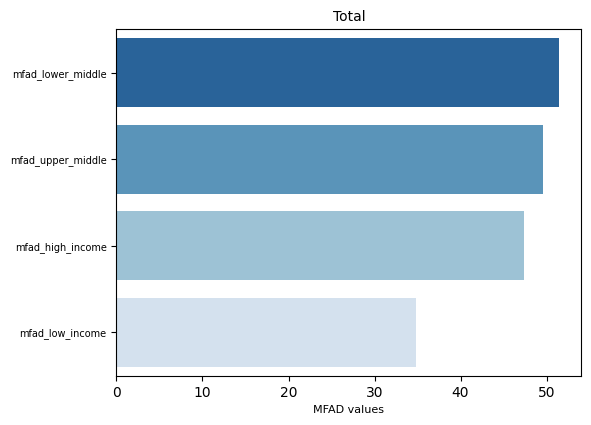

In [76]:
# Plotting this information

df = pd.DataFrame(mfad_all_groups.loc["Total"]).sort_values("Total", ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(6, 4.5)

bar_plotter(x="Total",
            y=df.index,
            ax=ax,
            df=df,
            palette="Blues_r",
            xlabel="MFAD values")

plt.show()

### Indicator 4: Nutrient Balance Score

In [77]:
# Importing the dataset of median age

median_age = pd.read_csv("median-age.csv")

median_age.head()

,Entity,Code,Year,Median age - Sex: all - Age: all - Variant: estimates,Median age - Sex: all - Age: all - Variant: medium
0,Afghanistan,AFG,1950,18.4,NaN
1,Afghanistan,AFG,1951,18.4,NaN
2,Afghanistan,AFG,1952,18.4,NaN
3,Afghanistan,AFG,1953,18.3,NaN
4,Afghanistan,AFG,1954,18.3,NaN


In [78]:
# Filtering the data for year 2019

median_age_2019 = median_age[median_age["Year"] == 2019]

median_age_2019.head()

,Entity,Code,Year,Median age - Sex: all - Age: all - Variant: estimates,Median age - Sex: all - Age: all - Variant: medium
69,Afghanistan,AFG,2019,16.3,NaN
220,Africa (UN),NaN,2019,18.5,NaN
371,Albania,ALB,2019,36.5,NaN
522,Algeria,DZA,2019,27.4,NaN
673,American Samoa,ASM,2019,26.1,NaN


In [79]:
# Filtering only the columns needed and setting index to the column containing countries

median_age_clean = median_age_2019.drop(["Year", "Code", "Median age - Sex: all - Age: all - Variant: medium"], axis=1).set_index("Entity")

median_age_clean.head()

,Median age - Sex: all - Age: all - Variant: estimates
Entity,
Afghanistan,16.3
Africa (UN),18.5
Albania,36.5
Algeria,27.4
American Samoa,26.1


In [80]:
# Combining this dataset and the one that has sizes of economies

median_age_economized = pd.merge(size_of_economy,
                                 median_age_clean,
                                 left_index=True,
                                 right_index=True).drop("Region", axis=1)

median_age_economized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, Aruba to Zimbabwe
Data columns (total 2 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Income group                                           187 non-null    object 
 1   Median age - Sex: all - Age: all - Variant: estimates  187 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.4+ KB


In [81]:
# Grouping the data according to income groups and checking for means and medians.

median_age_mean_values = median_age_economized.groupby("Income group").mean()

display(median_age_mean_values)

median_age_median_values = median_age_economized.groupby("Income group").median()

display(median_age_median_values)

,Median age - Sex: all - Age: all - Variant: estimates
Income group,
High income,38.585075
Low income,16.677273
Lower middle income,22.834783
Upper middle income,30.100000


,Median age - Sex: all - Age: all - Variant: estimates
Income group,
High income,39.30
Low income,16.50
Lower middle income,22.15
Upper middle income,29.35


In [82]:
# Using the data above to import the DRI's (Daily Recommended Intakes) (Source cited at the Thesis Report)

nutrients = ["Energy", "Folate", "Niacin", "Panthothenic Acid", "Riboflavin", "Thiamin", "Vitamin A", "Vitamin B12", "Vitamin B6", "Vitamin C", "Vitamin D", "Vitamin E", "Vitamin K", "Calcium", "Copper", "Iron", "Magnesium", "Manganese", "Phosphorus", "Potassium", "Selenium", "Zinc", "Alpha-Linolenic Acid", "Linoleic Acid", "Choline", "Dietary Fiber", "Protein", "Water"]

units = ["kcal", "micrograms", "milligrams", "milligrams", "milligrams", "milligrams", "micrograms", "micrograms", "milligrams", "milligrams", "micrograms", "milligrams", "micrograms", "milligrams", "micrograms", "milligrams", "millgrams", "milligrams", "milligrams", "grams", "micrograms", "milligrams", "grams", "grams", "milligrams", "grams", "gram", "grams"]

dri_high_income_male = [2900, 400, 16, 5, 1.3, 1.2, 900, 2.4, 1.3, 90, 5, 15, 120, 1000, 900, 8, 420, 2.3, 700, 4.7, 55, 11, 1.6, 17, 550, 38, 56, 3]
dri_high_income_female = [2200, 400, 14, 5, 1.1, 1.1, 700, 2.4, 1.3, 75, 5, 15, 90, 1000, 900, 18, 320, 1.8, 700, 4.7, 55, 8, 1.6, 17, 425, 25, 46, 2.7]


dri_lower_middle_male = [2900, 400, 16, 5, 1.3, 1.2, 900, 2.4, 1.3, 90, 5, 15, 120, 1000, 900, 8, 420, 2.3, 700, 4.7, 55, 11, 1.6, 17, 550, 38, 56, 3]
dri_lower_middle_female = [2200, 400, 14, 5, 1.1, 1.1, 700, 2.4, 1.3, 75, 5, 15, 90, 1000, 900, 18, 320, 1.8, 700, 4.7, 55, 8, 1.6, 17, 425, 25, 46, 2.7]


dri_upper_middle_male = [2900, 400, 16, 5, 1.3, 1.2, 900, 2.4, 1.3, 90, 5, 15, 120, 1000, 900, 8, 420, 2.3, 700, 4.7, 55, 11, 1.6, 17, 550, 38, 56, 3]
dri_upper_middle_female = [2200, 400, 14, 5, 1.1, 1.1, 700, 2.4, 1.3, 75, 5, 15, 90, 1000, 900, 18, 320, 1.8, 700, 4.7, 55, 8, 1.6, 17, 425, 25,46, 2.7]


dri_low_income_males = [3000, 400, 16, 5, 1.3, 1.2, 900, 2.4, 1.3, 75, 5, 15, 120, 1300, 890, 11, 410, 2.2, 1250, 4.7, 55, 11, 1.6, 16, 550, 38, 52, 2.6]
dri_low_income_females = [2200, 400, 14, 5, 1.0, 1.0, 700, 2.4, 1.2, 65, 5, 15, 90, 1300, 890, 15, 360, 1.6, 1250, 4.7, 55, 9, 1.6, 16, 400, 26, 46, 1.8]

columns = pd.MultiIndex.from_product([["dri_low_income", "dri_lower_middle", "dri_upper_middle", "dri_high_income"], ["male", "female"]])

dri = pd.DataFrame([dri_low_income_males, 
                    dri_low_income_females,
                    dri_lower_middle_male, 
                    dri_lower_middle_female,
                    dri_upper_middle_male, 
                    dri_upper_middle_female,
                    dri_high_income_male, 
                    dri_high_income_female]).T

dri.index = list((nutrients, units))

dri.columns = columns

dri.index.names = ["Nutrient", "Unit Per Day"]


dri

dri_low_income         dri_lower_middle   
                                            male  female             male   
Nutrient             Unit Per Day                                           
Energy               kcal                 3000.0  2200.0           2900.0  \
Folate               micrograms            400.0   400.0            400.0   
Niacin               milligrams             16.0    14.0             16.0   
Panthothenic Acid    milligrams              5.0     5.0              5.0   
Riboflavin           milligrams              1.3     1.0              1.3   
Thiamin              milligrams              1.2     1.0              1.2   
Vitamin A            micrograms            900.0   700.0            900.0   
Vitamin B12          micrograms              2.4     2.4              2.4   
Vitamin B6           milligrams              1.3     1.2              1.3   
Vitamin C            milligrams             75.0    65.0             90.0   
Vitamin D            micrograms              5.0     5.0              5.0   
Vitamin E            milligrams             15.0    15.0             15.0   
Vitamin K            micrograms            120.0    90.0            120.0   
Calcium              milligrams           1300.0  1300.0           1000.0   
Copper               micrograms            890.0   890.0            900.0   
Iron                 milligrams             11.0    15.0              8.0   
Magnesium            millgrams             410.0   360.0            420.0   
Manganese            milligrams              2.2     1.6              2.3   
Phosphorus           milligrams           1250.0  1250.0            700.0   
Potassium            grams                   4.7     4.7              4.7   
Selenium             micrograms             55.0    55.0             55.0   
Zinc                 milligrams             11.0     9.0             11.0   
Alpha-Linolenic Acid grams                   1.6     1.6              1.6   
Linoleic Acid        grams                  16.0    16.0             17.0   
Choline              milligrams            550.0   400.0            550.0   
Dietary Fiber        grams                  38.0    26.0             38.0   
Protein              gram                   52.0    46.0             56.0   
Water                grams                   2.6     1.8              3.0   

                                          dri_upper_middle           
                                   female             male  female   
Nutrient             Unit Per Day                                    
Energy               kcal          2200.0           2900.0  2200.0  \
Folate               micrograms     400.0            400.0   400.0   
Niacin               milligrams      14.0             16.0    14.0   
Panthothenic Acid    milligrams       5.0              5.0     5.0   
Riboflavin           milligrams       1.1              1.3     1.1   
Thiamin              milligrams       1.1              1.2     1.1   
Vitamin A            micrograms     700.0            900.0   700.0   
Vitamin B12          micrograms       2.4              2.4     2.4   
Vitamin B6           milligrams       1.3              1.3     1.3   
Vitamin C            milligrams      75.0             90.0    75.0   
Vitamin D            micrograms       5.0              5.0     5.0   
Vitamin E            milligrams      15.0             15.0    15.0   
Vitamin K            micrograms      90.0            120.0    90.0   
Calcium              milligrams    1000.0           1000.0  1000.0   
Copper               micrograms     900.0            900.0   900.0   
Iron                 milligrams      18.0              8.0    18.0   
Magnesium            millgrams      320.0            420.0   320.0   
Manganese            milligrams       1.8              2.3     1.8   
Phosphorus           milligrams     700.0            700.0   700.0   
Potassium            grams            4.7              4.7     4.7   
Selenium             micrograms     

In [83]:
# Importing the gender ratio table 

gender = pd.read_csv("share-population-female.csv")

gender.head()

,Entity,Code,Year,"Population, female (% of total population)"
0,Afghanistan,AFG,1960,48.083054
1,Afghanistan,AFG,1961,48.165000
2,Afghanistan,AFG,1962,48.242370
3,Afghanistan,AFG,1963,48.315890
4,Afghanistan,AFG,1964,48.385273


In [84]:
# Filtering for year 2019

gender_2019 = gender[gender["Year"] == 2019]

gender_2019.head()

,Entity,Code,Year,"Population, female (% of total population)"
59,Afghanistan,AFG,2019,49.455486
121,Albania,ALB,2019,49.939330
183,Algeria,DZA,2019,49.053470
245,American Samoa,ASM,2019,50.265210
307,Andorra,AND,2019,49.123035


In [85]:
# Removing unwanted columns

gender_filtered = gender_2019.drop(["Code", "Year"], axis=1).set_index("Entity")

gender_filtered.head()

,"Population, female (% of total population)"
Entity,
Afghanistan,49.455486
Albania,49.939330
Algeria,49.053470
American Samoa,50.265210
Andorra,49.123035


In [86]:
# Adding to it the population numbers

# Importing the population growth table

pop_growth = pd.read_csv("population-and-demography.csv")

pop_growth.head()

,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
0,Afghanistan,1950,7480464,301735.0,1248282,3068855,4494349,4198587,4411609,3946595,...,757113,1241348,909953,661807,467170,271905,92691,9499,123,0.0
1,Afghanistan,1951,7571542,299368.0,1246857,3105444,4552138,4250002,4466098,3993640,...,768616,1260904,922765,667015,468881,273286,94358,10155,118,0.0
2,Afghanistan,1952,7667534,305393.0,1248220,3145070,4613604,4303436,4522464,4041439,...,781411,1280288,935638,672491,470898,274852,96026,10721,139,0.0
3,Afghanistan,1953,7764549,311574.0,1254725,3186382,4676232,4356242,4578167,4088379,...,794308,1298803,948321,678064,472969,276577,97705,11254,166,0.0
4,Afghanistan,1954,7864289,317584.0,1267817,3231060,4741371,4408474,4633229,4136116,...,806216,1316768,961484,684153,475117,278210,99298,11793,190,0.0


In [87]:
# Filtering for 2019

pop_growth_2019 = pop_growth[pop_growth["Year"] == 2019]

pop_growth_2019.head()

,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
69,Afghanistan,2019,37769496,1313684.0,6262390,16728620,24950588,20127700,21040860,18284280,...,4461340,6738758,4039411,2701018,1653460,914688,431683,95602,4901,14.0
141,Africa (UN),2019,1327701100,42313264.0,201562530,540843400,794207100,741291140,786845200,702767700,...,135980420,220823950,169064340,114105656,75526640,44771480,20495524,5549767,527419,12594.0
213,Albania,2019,2873883,28770.0,150467,481425,914818,1951299,2392240,2274074,...,202065,468425,366904,336485,395103,326711,201536,84182,10829,218.0
285,Algeria,2019,42705372,984232.0,4922011,13013432,18995820,27191522,29691574,27895046,...,2929659,6546221,7171787,5446353,3771832,2339750,1056596,393452,35925,365.0
357,American Samoa,2019,47341,845.0,4460,13674,21713,30770,33667,31176,...,4044,8250,5238,5782,5530,3269,1233,295,26,0.0


In [88]:
# Removing all other columns except "Population" and "Country name"

pop_growth_clean = pop_growth_2019.iloc[:, [0, 2]].set_index("Country name")

pop_growth_clean.head()

,Population
Country name,
Afghanistan,37769496
Africa (UN),1327701100
Albania,2873883
Algeria,42705372
American Samoa,47341


In [89]:
# Attaching the table above with the percentage_of_women table

pop_dynamics = pd.merge(gender_filtered,
                        pop_growth_clean,
                        left_index=True,
                        right_index=True)

pop_dynamics

,"Population, female (% of total population)",Population
Afghanistan,49.455486,37769496
Albania,49.939330,2873883
Algeria,49.053470,42705372
American Samoa,50.265210,47341
Andorra,49.123035,76361
...,...,...
Vietnam,50.626377,95776710
World,49.691880,7764951000
Yemen,49.428680,31546694
Zambia,50.673760,18380478


In [90]:
# Loading the Intakes data from the first metric

daily_dietary_intake.head(2)

,Income group,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Starchs & Sugars,Dairy & Egg Products,Finfish / Shellfish Products,Poultry,Pork,Beef Products,Spices & Herbs,Legumes & Products,Vegetables,Fruits & Plantains,Infant food
Country,,,,,,,,,,,,,,,
Afghanistan,Low income,1534.2,53.4,209.5,149.1,120.0,1.7,6.0,0.0,50.1,3.0,17.2,34.1,59.1,1.0
Angola,Lower middle income,761.1,733.3,321.5,159.1,14.0,24.1,33.0,77.0,39.1,0.0,77.1,15.0,103.1,1.0


In [91]:
# Converting the values above into grams

daily_intakes_in_grams = daily_dietary_intake.iloc[:, 1:] / 7.7162

daily_intakes_in_grams.head()

,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Starchs & Sugars,Dairy & Egg Products,Finfish / Shellfish Products,Poultry,Pork,Beef Products,Spices & Herbs,Legumes & Products,Vegetables,Fruits & Plantains,Infant food
Country,,,,,,,,,,,,,,
Afghanistan,198.828439,6.920505,27.150670,19.322983,15.551696,0.220316,0.777585,0.000000,6.492833,0.388792,2.229076,4.419274,7.659210,0.129597
Angola,98.636635,95.033825,41.665587,20.618958,1.814365,3.123299,4.276717,9.979005,5.067261,0.000000,9.991965,1.943962,13.361499,0.129597
Albania,138.176823,11.573054,43.013400,26.450844,92.791789,1.943962,8.035043,7.646251,21.266945,0.012960,6.479874,26.956274,37.466629,0.129597
United Arab Emirates,139.887509,5.067261,105.142428,44.866644,28.381846,5.443094,14.385319,0.012960,14.916669,1.295975,20.735595,7.127861,14.126124,0.647987
Argentina,135.999585,10.925067,52.409217,56.647054,38.490449,1.425572,25.141909,14.514917,52.888728,3.499132,7.127861,6.998263,10.497395,0.012960


In [92]:
# Putting back the "Income group" column on the table

daily_intakes_in_grams = pd.merge(size_of_economy,
                                 daily_intakes_in_grams,
                                 left_index=True,
                                 right_index=True).drop("Region", axis=1)

daily_intakes_in_grams.head(2)

,Income group,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Starchs & Sugars,Dairy & Egg Products,Finfish / Shellfish Products,Poultry,Pork,Beef Products,Spices & Herbs,Legumes & Products,Vegetables,Fruits & Plantains,Infant food
Country,,,,,,,,,,,,,,,
Afghanistan,Low income,198.828439,6.920505,27.150670,19.322983,15.551696,0.220316,0.777585,0.000000,6.492833,0.388792,2.229076,4.419274,7.659210,0.129597
Angola,Lower middle income,98.636635,95.033825,41.665587,20.618958,1.814365,3.123299,4.276717,9.979005,5.067261,0.000000,9.991965,1.943962,13.361499,0.129597


In [93]:
# Revisiting the Nutrient_composition table

nutrition_table

,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),Vitamin D,"Vitamin C, total ascorbic acid",...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
food_group,,,,,,,,,,,,,,,,,,,,,
Dairy and Egg Products,0.825,63.550,0.60,0.0,0.180,0.50,0.00,0.50,20.0,0.0,...,0.0335,0.1210,1.9930,0.0,0.020,0.0160,0.2970,0.0000,0.0930,0.0760
Spices and Herbs,2.840,9.310,24.60,0.0,1.690,NaN,NaN,0.00,0.0,15.2,...,0.0000,0.0080,0.5740,0.0,0.000,0.0000,0.0200,0.0000,0.0020,0.0000
Baby Foods,0.490,83.200,5.10,0.0,0.560,0.10,0.00,0.00,2.0,7.9,...,0.0000,0.0010,0.4260,0.0,0.000,0.0000,0.0310,0.0000,0.0070,0.0010
Poultry Products,2.020,66.505,0.00,0.0,0.220,0.20,NaN,0.20,7.0,0.0,...,0.0040,0.1970,1.5200,0.0,0.006,0.0080,0.0560,NaN,0.0100,0.0000
Breakfast Cereals,4.310,97.495,4.55,0.0,2.430,NaN,NaN,3.55,141.0,9.0,...,NaN,NaN,2.6180,NaN,NaN,NaN,0.5175,NaN,1.3630,0.1230
Fruits and Fruit Juices,0.090,84.010,1.55,0.0,0.180,0.50,NaN,0.00,0.0,8.0,...,0.0000,0.0040,0.0160,0.0,0.001,0.0000,0.0000,NaN,0.0000,0.0000
Pork Products,2.275,65.125,0.00,0.0,0.220,0.70,0.00,0.70,27.0,0.0,...,0.0010,0.1080,1.8020,0.0,0.000,0.0000,0.1050,NaN,0.0050,0.0060
Vegetables and Vegetable Products,0.330,89.180,9.50,0.0,0.295,0.00,0.40,0.00,0.0,11.0,...,0.0000,0.0030,0.0420,0.0,0.000,0.0000,0.0010,0.0000,0.0000,0.0000
Beef Products,6.990,118.575,2.00,0.0,0.540,0.70,NaN,0.80,31.5,0.0,...,0.0350,0.9430,6.9660,0.0,0.057,0.0615,0.5695,NaN,0.0275,0.0285


In [94]:
# Extracting target nutrients

nutrients_for_balance_score = nutrition_table.loc[:, ["Zinc, Zn", "Water", "Energy",
                                                      "Protein", "Fiber, total dietary", "Calcium, Ca",
                                                      "Iron, Fe", "Magnesium, Mg", "Phosphorus, P",
                                                      "Potassium, K", "Copper, Cu", "Manganese, Mn",
                                                      "Selenium, Se", "Vitamin C, total ascorbic acid",
                                                      "Thiamin", "Riboflavin", "Niacin",
                                                      "Pantothenic acid", "Vitamin B-6", "Folate, total",
                                                      "Choline, total", "Vitamin B-12", "Vitamin D", "18:3 n-3 c,c,c (ALA)",
                                                      "18:3 undifferentiated", "Vitamin A, RAE", "Vitamin E (alpha-tocopherol)",
                                                      "Vitamin K (phylloquinone)"]]

nutrients_for_balance_score.head(6)

,"Zinc, Zn",Water,Energy,Protein,"Fiber, total dietary","Calcium, Ca","Iron, Fe","Magnesium, Mg","Phosphorus, P","Potassium, K",...,Vitamin B-6,"Folate, total","Choline, total",Vitamin B-12,Vitamin D,"18:3 n-3 c,c,c (ALA)",18:3 undifferentiated,"Vitamin A, RAE",Vitamin E (alpha-tocopherol),Vitamin K (phylloquinone)
food_group,,,,,,,,,,,,,,,,,,,,,
Dairy and Egg Products,0.825,63.550,481.00,9.035,0.0,141.5,0.185,16.0,150.5,152.0,...,0.0500,10.0,15.60,0.52,20.0,0.036,0.052,88.0,0.18,0.60
Spices and Herbs,2.840,9.310,735.00,9.350,14.8,383.0,13.935,174.5,173.5,1000.0,...,0.3970,56.0,31.30,0.00,0.0,0.273,0.223,17.0,1.69,24.60
Baby Foods,0.490,83.200,174.00,1.970,0.4,37.0,0.870,9.0,42.0,122.0,...,0.0600,10.0,10.80,0.10,2.0,0.029,0.040,42.5,0.56,5.10
Poultry Products,2.020,66.505,455.25,23.270,0.0,13.0,1.195,22.0,196.5,237.0,...,0.3955,7.0,68.15,0.47,7.0,0.054,0.080,16.0,0.22,0.00
Breakfast Cereals,4.310,97.495,2164.50,17.800,9.0,290.5,19.215,99.5,380.5,602.5,...,1.9840,396.5,51.70,3.76,141.0,NaN,0.116,469.0,2.43,4.55
Fruits and Fruit Juices,0.090,84.010,155.50,0.600,1.6,11.0,0.310,10.0,13.0,136.0,...,0.0470,5.0,5.10,0.00,0.0,0.023,0.009,4.0,0.18,1.55


In [95]:
daily_intakes_in_grams.head(2)

,Income group,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Starchs & Sugars,Dairy & Egg Products,Finfish / Shellfish Products,Poultry,Pork,Beef Products,Spices & Herbs,Legumes & Products,Vegetables,Fruits & Plantains,Infant food
Country,,,,,,,,,,,,,,,
Afghanistan,Low income,198.828439,6.920505,27.150670,19.322983,15.551696,0.220316,0.777585,0.000000,6.492833,0.388792,2.229076,4.419274,7.659210,0.129597
Angola,Lower middle income,98.636635,95.033825,41.665587,20.618958,1.814365,3.123299,4.276717,9.979005,5.067261,0.000000,9.991965,1.943962,13.361499,0.129597


In [96]:
# How many of these nutrients are consumed daily according to the food intakes by grams?


# Calculating nutrient intakes: Modifying the "nutrient_supply" supply

def nutrient_intakes(df) :
    """Calculates nutrient intakes for a particular country or country group"""

    column_names = list(nutrients_for_balance_score.columns.values)

    index_names = list(df.columns.values)

    index_names.remove("Roots & Tubers")

    index_names.remove("Infant food")

    nutrient_intakes = pd.DataFrame([(df["Cereals"].values * nutrients_for_balance_score.loc["Breakfast Cereals"].values) / 100,
                                     (df["Seeds, Nuts, and Oils"].values * nutrients_for_balance_score.loc["Seeds, Nuts, and Oils"].values) / 100,
                                     (df["Starchs & Sugars"].values * nutrients_for_balance_score.loc["Beverages"].values) / 100,
                                     (df["Dairy & Egg Products"].values * nutrients_for_balance_score.loc["Dairy and Egg Products"].values) / 100,
                                     (df["Finfish / Shellfish Products"].values * nutrients_for_balance_score.loc["Finfish and Shellfish Products"].values) / 100,
                                     (df["Poultry"].values * nutrients_for_balance_score.loc["Poultry Products"].values) / 100,
                                     (df["Pork"].values * nutrients_for_balance_score.loc["Pork Products"].values) / 100,
                                     (df["Beef Products"].values * nutrients_for_balance_score.loc["Beef Products"].values) / 100,
                                     (df["Spices & Herbs"].values * nutrients_for_balance_score.loc["Spices and Herbs"].values) / 100,
                                     (df["Legumes & Products"].values * nutrients_for_balance_score.loc["Legumes and Legume Products"].values) / 100,
                                     (df["Vegetables"].values * nutrients_for_balance_score.loc["Vegetables and Vegetable Products"].values) / 100,
                                     (df["Fruits & Plantains"].values * nutrients_for_balance_score.loc["Fruits and Fruit Juices"].values) / 100])
    
    nutrient_intakes.columns = column_names

    nutrient_intakes.index = index_names
    
    return nutrient_intakes

In [97]:
# Calculating nutrient intakes: Taking medians of the daily_intakes_in_grams

median_daily_intakes_in_grams = daily_intakes_in_grams.groupby("Income group").median()

median_daily_intakes_in_grams

,Cereals,Roots & Tubers,"Seeds, Nuts, and Oils",Starchs & Sugars,Dairy & Egg Products,Finfish / Shellfish Products,Poultry,Pork,Beef Products,Spices & Herbs,Legumes & Products,Vegetables,Fruits & Plantains,Infant food
Income group,,,,,,,,,,,,,,
High income,128.081180,11.223141,61.759674,46.279257,54.560535,5.831886,14.190923,19.698815,22.368523,0.777585,4.147119,9.849408,16.523677,0.388792
Low income,164.083357,39.799383,36.987118,12.843109,6.091081,1.166377,1.166377,1.166377,5.326456,0.129597,11.015785,4.017522,10.367798,0.000000
Lower middle income,166.105078,15.104585,39.106037,27.351546,12.972707,2.591949,3.045541,1.749566,9.220860,0.330474,9.207900,5.572691,11.793370,0.129597
Upper middle income,142.453539,11.573054,48.910085,42.650527,29.159431,2.332754,11.404577,7.646251,13.879889,0.388792,6.609471,8.423836,15.033307,0.259195


In [98]:
# Calculating nutrient intakes in grams

nutrient_intakes_low_income = nutrient_intakes(median_daily_intakes_in_grams.loc[["Low income"]])

# nutrient_intakes_lower_middle = nutrient_intakes(median_daily_intakes_in_grams.loc[["Lower middle income"]])

# nutrient_intakes_low_income = nutrient_intakes(median_daily_intakes_in_grams.loc[["Upper middle income"]])

# nutrient_intakes_low_income = nutrient_intakes(median_daily_intakes_in_grams.loc[["High income"]])

In [99]:
# Constructing the Qualifying Index (QI) for each country group for each food

nutrient_intakes_low_income

,"Zinc, Zn",Water,Energy,Protein,"Fiber, total dietary","Calcium, Ca","Iron, Fe","Magnesium, Mg","Phosphorus, P","Potassium, K",...,Vitamin B-6,"Folate, total","Choline, total",Vitamin B-12,Vitamin D,"18:3 n-3 c,c,c (ALA)",18:3 undifferentiated,"Vitamin A, RAE",Vitamin E (alpha-tocopherol),Vitamin K (phylloquinone)
Cereals,7.071993,159.973069,3551.584264,29.206838,14.767502,476.662152,31.528617,163.262940,624.337174,988.602226,...,3.255414,650.590511,84.831096,6.169534,231.357534,NaN,0.190337,769.550945,3.987226,7.465793
"Seeds, Nuts, and Oils",1.224274,1.649625,1397.743190,5.740401,3.088424,25.890983,1.268658,62.138358,164.962546,209.162152,...,0.119468,21.637464,20.712786,0.000000,0.000000,0.754167,0.510422,0.369871,2.785130,16.607216
Starchs & Sugars,0.003853,11.283314,15.925456,0.008990,0.000000,0.513724,0.007706,0.385293,0.642155,3.082346,...,0.001413,0.000000,0.038529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Dairy & Egg Products,0.050251,3.870882,29.298100,0.550329,0.000000,8.618880,0.011269,0.974573,9.167077,9.258443,...,0.003046,0.609108,0.950209,0.031674,1.218216,0.002193,0.003167,5.360151,0.010964,0.036546
Finfish / Shellfish Products,0.007698,0.851105,3.749903,0.235725,0.000000,0.338249,0.008631,0.384904,2.764314,4.093984,...,0.003149,0.116638,0.880032,0.027410,1.318006,0.000175,0.000397,0.314922,0.010381,0.001166
Poultry,0.023561,0.775699,5.309932,0.271416,0.000000,0.151629,0.013938,0.256603,2.291931,2.764314,...,0.004613,0.081646,0.794886,0.005482,0.081646,0.000630,0.000933,0.186620,0.002566,0.000000
Pork,0.026535,0.759603,5.455730,0.257886,0.000000,0.116638,0.010731,0.244939,2.671004,4.000674,...,0.005243,0.011664,0.954097,0.007348,0.314922,0.000338,0.000467,0.023328,0.002566,0.000000
Beef Products,0.372319,6.315845,66.594016,2.159079,0.000000,1.491408,0.190154,1.970789,19.228506,30.227638,...,0.033477,0.639175,8.032296,0.185361,1.677834,0.009881,0.012011,0.000000,0.028763,0.106529
Spices & Herbs,0.003681,0.012066,0.952541,0.012117,0.019180,0.496358,0.018059,0.226148,0.224852,1.295975,...,0.000515,0.072575,0.040564,0.000000,0.000000,0.000354,0.000289,0.022032,0.002190,0.031881
Legumes & Products,0.120072,7.600892,35.140354,0.906599,0.611376,6.939945,0.212054,5.618050,16.743993,39.877142,...,0.014210,9.308338,3.635209,0.000000,0.000000,0.008923,0.009694,0.000000,0.028090,0.330474


## Metric 2: Ecosystem Stability

### 1st Indicator: Ecosystem Status

In [100]:
# Loading the dataset

epi = pd.read_csv("materials_and_methods/Metric_2/indicator_1.csv")

epi.head()

,code,iso,country,region,EPI.new,HLT.new,AIR.new,HAD.new,PMD.new,OZD.new,...,CCH.rnk.old,CDA.rnk.old,CHA.rnk.old,FGA.rnk.old,NDA.rnk.old,BCA.rnk.old,GHN.rnk.old,LCB.rnk.old,GIB.rnk.old,GHP.rnk.old
0,4,AFG,Afghanistan,Southern Asia,43.6,16.0,15.5,7.4,16.0,18.4,...,159,161,164,NaN,141,142,112,12.0,129,1
1,24,AGO,Angola,Sub-Saharan Africa,30.5,20.5,23.1,17.9,24.0,36.8,...,81,29,35,77.0,132,105,119,135.0,1,87
2,8,ALB,Albania,Eastern Europe,47.1,40.0,37.5,34.5,36.7,63.7,...,108,156,26,77.0,70,173,39,37.0,25,67
3,784,ARE,United Arab Emirates,Greater Middle East,52.4,49.4,41.7,100.0,3.4,20.4,...,171,143,112,37.0,163,134,157,162.0,141,173
4,32,ARG,Argentina,Latin America & Caribbean,41.1,56.3,52.0,60.5,48.2,51.8,...,148,99,107,59.0,128,1,160,128.0,93,134


In [101]:
# Removing unwanted columns and resetting the index.

epi_cleaned = epi.iloc[:, [2, 4]].set_index("country")

epi_cleaned.head()

,EPI.new
country,
Afghanistan,43.6
Angola,30.5
Albania,47.1
United Arab Emirates,52.4
Argentina,41.1


In [102]:
# Joining that data with sizes of economy

epi_economized = pd.merge(size_of_economy,
                          epi_cleaned,
                          left_index=True,
                          right_index=True).drop("Region", axis=1)


epi_economized.head()

,Income group,EPI.new
Afghanistan,Low income,43.6
Angola,Lower middle income,30.5
Albania,Upper middle income,47.1
United Arab Emirates,High income,52.4
Argentina,Upper middle income,41.1


In [103]:
# Changing the column names for ANOVA

epi_economized.columns = ["income_group", "epi_new"]

epi_economized.head(2)

,income_group,epi_new
Afghanistan,Low income,43.6
Angola,Lower middle income,30.5


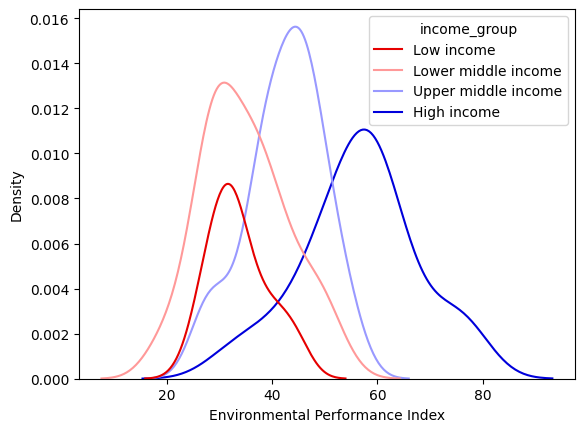

In [104]:
# Checking Normality

fig, ax = plt.subplots()

sns.kdeplot(data=epi_economized,
            x= "epi_new",
            hue= "income_group",
            ax=ax,
            palette="seismic_r").set(xlabel="Environmental Performance Index")

plt.show()

<Axes: xlabel='epi_new', ylabel='income_group'>

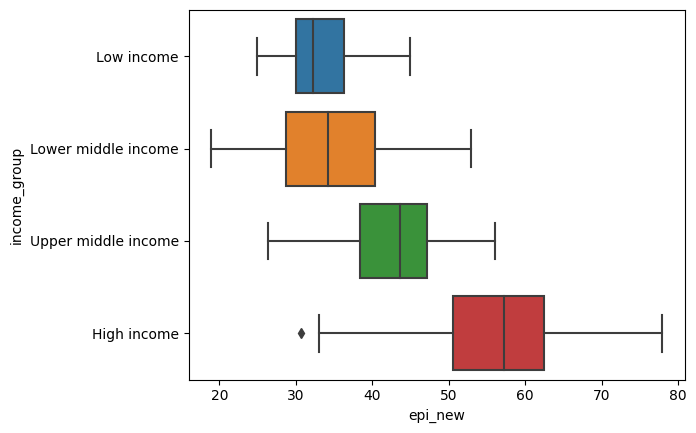

In [105]:
# Checking Homoskedasticity

sns.boxplot(x="epi_new",
            y="income_group",
            data=epi_economized)

In [106]:
# The data has heteroskedasticity. Applying the log and try to remedy that

epi_transformed = pd.concat([epi_economized, np.log(epi_economized["epi_new"])], axis=1)
                            
epi_transformed


epi_transformed.columns = ["income_group", "epi_new", "epi_transformed"]

epi_transformed

,income_group,epi_new,epi_transformed
Afghanistan,Low income,43.6,3.775057
Angola,Lower middle income,30.5,3.417727
Albania,Upper middle income,47.1,3.852273
United Arab Emirates,High income,52.4,3.958907
Argentina,Upper middle income,41.1,3.716008
...,...,...,...
Vanuatu,Lower middle income,36.9,3.608212
Samoa,Lower middle income,36.4,3.594569
South Africa,Upper middle income,37.2,3.616309
Zambia,Lower middle income,38.4,3.648057


<Axes: xlabel='epi_transformed', ylabel='income_group'>

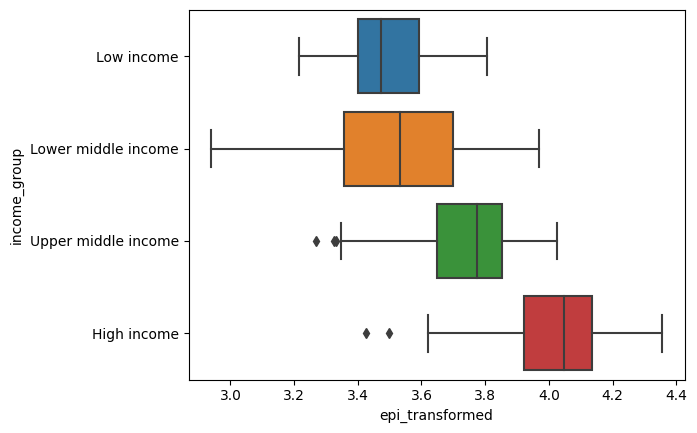

In [107]:
# Plotting the transformed values

sns.boxplot(x="epi_transformed",
            y="income_group",
            data=epi_transformed)

In [108]:
# The transformation didn't bring better results. Resorting to the original dataset

# Removing the outlier in high incomes

outlier = epi_economized[(epi_economized["income_group"] == "High income") & (epi_economized["epi_new"] < 33)]

outlier

epi_wout_outliers = epi_economized[~epi_economized.isin(outlier)]

<Axes: xlabel='epi_new', ylabel='income_group'>

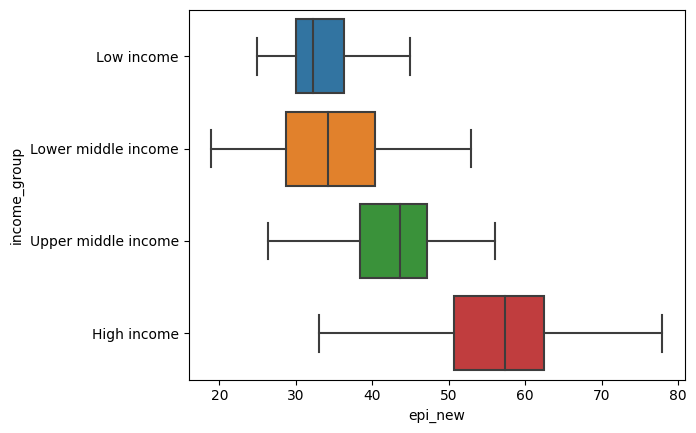

In [109]:
# Plotting the data without outliers

sns.boxplot(x="epi_new",
            y="income_group",
            data= epi_wout_outliers)

In [110]:
# ANOVA

# Creating and fitting the linear model
model = ols("epi_new ~ C(income_group)", data=epi_economized).fit()

# Accessing ANOVA coefficients
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(income_group),13673.480553,3.0,61.680378,1.875609e-26
Residual,11675.295558,158.0,NaN,NaN


In [111]:
# Summarizing the Data

epi_grouped_by_median = epi_economized.groupby("income_group").median().sort_values("epi_new", ascending=False)

epi_grouped_by_mean = epi_economized.groupby("income_group").mean().sort_values("epi_new", ascending=False)

display(epi_grouped_by_median)
display(epi_grouped_by_mean)

,epi_new
income_group,
High income,57.20
Upper middle income,43.60
Lower middle income,34.20
Low income,32.25


,epi_new
income_group,
High income,56.608511
Upper middle income,42.489583
Lower middle income,34.744681
Low income,33.610000


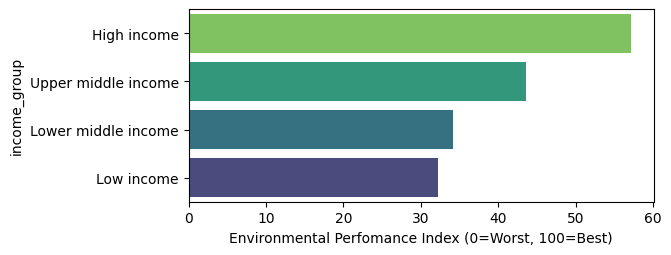

In [112]:
# Visualizing above information in a barplot
fig, ax = plt.subplots()

sns.barplot(data=epi_grouped_by_median,
            x="epi_new",
            y=epi_grouped_by_mean.index,
            ax=ax,
            palette="viridis_r").set_xlabel("Environmental Perfomance Index (0=Worst, 100=Best)")

fig.set_size_inches(6, 2.5)

### 2nd Indicator: Per Capita GHG Emissions

In [113]:
# Loading the dataset

emissions = pd.read_csv("materials_and_methods/Metric_2/indicator_2.csv")

emissions.head()

,Entity,Code,Year,Aviation and shipping (per capita),Land-use change and forestry (per capita),Manufacturing and construction (per capita),Fugitive emissions (per capita),Agriculture (per capita),Buildings (per capita),Electricity and heat (per capita),Industry (per capita),Transport (per capita),Waste (per capita)
0,Afghanistan,AFG,1990,0.001870,-0.223473,0.038336,0.026181,0.754572,0.007480,0.015896,0.004675,0.156151,0.115009
1,Afghanistan,AFG,1991,0.001861,-0.222426,0.037226,0.022336,0.781747,0.006515,0.015821,0.005584,0.144251,0.122846
2,Afghanistan,AFG,1992,0.001659,-0.198218,0.030686,0.016587,0.697495,0.002488,0.013270,0.004976,0.063861,0.116111
3,Afghanistan,AFG,1993,0.001428,-0.170668,0.025707,0.011425,0.606266,0.002142,0.011425,0.004285,0.052843,0.106400
4,Afghanistan,AFG,1994,0.001294,-0.154637,0.021999,0.007764,0.551258,0.001294,0.010352,0.003882,0.045938,0.102229


In [114]:
# Removing unwanted columns
emissions_only_from_agric = emissions.iloc[:, [0, 2, 7]]

emissions_only_from_agric.head()

,Entity,Year,Agriculture (per capita)
0,Afghanistan,1990,0.754572
1,Afghanistan,1991,0.781747
2,Afghanistan,1992,0.697495
3,Afghanistan,1993,0.606266
4,Afghanistan,1994,0.551258


In [115]:
# Removing unwanted rows
agricultural_emissions_2019 = emissions_only_from_agric[emissions_only_from_agric["Year"] == 2019].set_index("Entity")#.drop("index", axis=1)

agricultural_emissions_2019.head()

,Year,Agriculture (per capita)
Entity,,
Afghanistan,2019,0.411443
Africa,2019,0.737244
Albania,2019,0.981251
Algeria,2019,0.291767
Andorra,2019,0.000000


In [116]:
# Filtering Countries to have the same ones as previous tables
emissions_of_sampled_countries = pd.merge(size_of_economy,
                                        agricultural_emissions_2019,
                                        left_index=True,
                                        right_index= True).drop(["Region", "Year"], axis=1)

emissions_of_sampled_countries.head()

,Income group,Agriculture (per capita)
Afghanistan,Low income,0.411443
Angola,Lower middle income,1.119505
Albania,Upper middle income,0.981251
Andorra,High income,0.000000
United Arab Emirates,High income,0.225801


In [117]:
# Checking the number of countries we have in the cleaned dataset
emissions_of_sampled_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, Afghanistan to Zimbabwe
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Income group              168 non-null    object 
 1   Agriculture (per capita)  167 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [118]:
# Dropping the missing value

missing_val = emissions_of_sampled_countries[emissions_of_sampled_countries["Agriculture (per capita)"].isna() == True]

display(missing_val)

emissions_of_sampled_countries = emissions_of_sampled_countries.drop("Liechtenstein")

emissions_of_sampled_countries.info()

,Income group,Agriculture (per capita)
Liechtenstein,High income,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zimbabwe
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Income group              167 non-null    object 
 1   Agriculture (per capita)  167 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


<Axes: xlabel='Agriculture (per capita)', ylabel='Density'>

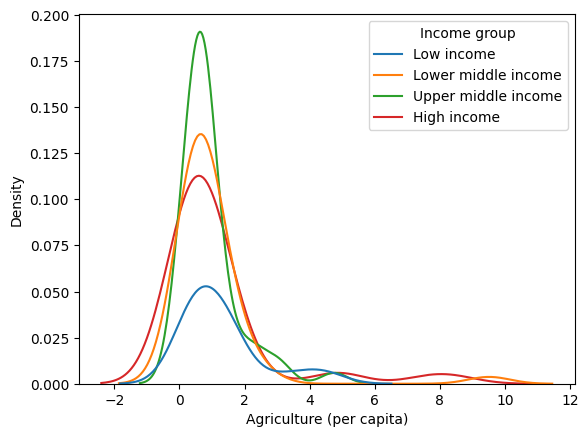

In [119]:
# Visualizing the dataset to see if there is normality

sns.kdeplot(x="Agriculture (per capita)",
            hue="Income group",
            data=emissions_of_sampled_countries)

In [120]:
# It seems there are issues with normality. Trying to apply the natural log and transform it

transformed_emissions = pd.concat([emissions_of_sampled_countries, np.log(emissions_of_sampled_countries["Agriculture (per capita)"])], axis=1)

transformed_emissions.head()

transformed_emissions.columns = ["income_groups", "emissions_normal", "emissions_transformed"]

transformed_emissions.head()

c:\Users\David\Desktop\Dev\thesis\.venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,income_groups,emissions_normal,emissions_transformed
Afghanistan,Low income,0.411443,-0.888084
Angola,Lower middle income,1.119505,0.112886
Albania,Upper middle income,0.981251,-0.018927
Andorra,High income,0.000000,-inf
United Arab Emirates,High income,0.225801,-1.488102


<Axes: xlabel='emissions_transformed', ylabel='Density'>

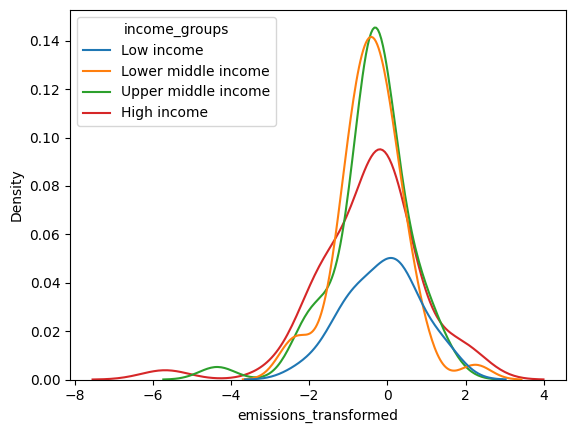

In [121]:
# Plotting this one

sns.kdeplot(x="emissions_transformed",
            hue="income_groups",
            data=transformed_emissions)

<Axes: xlabel='emissions_normal', ylabel='income_groups'>

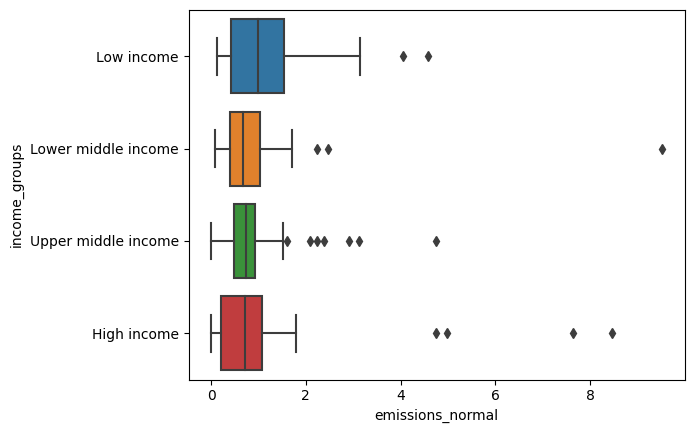

In [122]:
# It still persists. Let's check for outliers

sns.boxplot(x="emissions_normal",
            y="income_groups",
            data=transformed_emissions)

In [123]:
# Removing the outliers: 1. Separating income groups

emissions_high_income = transformed_emissions[emissions_of_sampled_countries["Income group"] == "High income"]

emissions_low_income = transformed_emissions[emissions_of_sampled_countries["Income group"] == "Low income"]

emissions_lower_middle = transformed_emissions[emissions_of_sampled_countries["Income group"] == "Lower middle income"]

emissions_upper_middle = transformed_emissions[emissions_of_sampled_countries["Income group"] == "Upper middle income"]

In [124]:
# Removing the outliers

emissions_high_income = emissions_high_income[emissions_high_income["emissions_normal"] < 4]

emissions_low_income = emissions_low_income[emissions_low_income["emissions_normal"] < 3]

emissions_lower_middle = emissions_lower_middle[emissions_lower_middle["emissions_normal"] < 2]

emissions_upper_middle = emissions_upper_middle[emissions_upper_middle["emissions_normal"] < 1.5]



<Axes: xlabel='emissions_normal', ylabel='income_groups'>

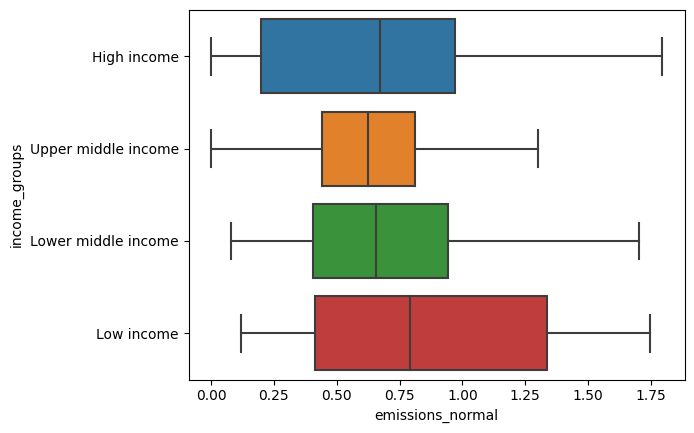

In [125]:
# Combining the new data and visualizing it

emissions_wout_outliers = pd.concat([emissions_high_income,
                                     emissions_upper_middle,
                                     emissions_lower_middle,
                                     emissions_low_income])


sns.boxplot(x="emissions_normal",
            y="income_groups",
            data=emissions_wout_outliers)

<Axes: xlabel='emissions_transformed', ylabel='Density'>

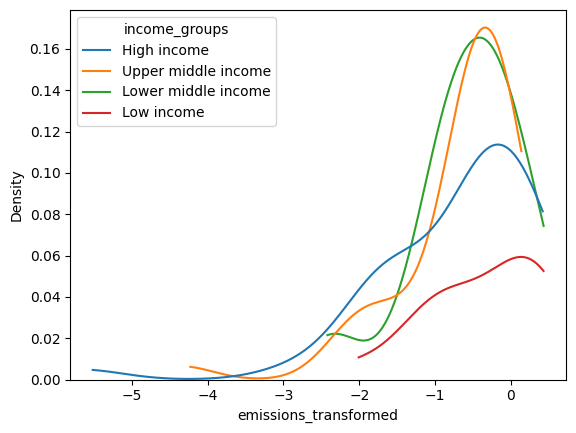

In [126]:
# The distribution is way better. Plotting for normality

sns.kdeplot(x="emissions_transformed",
            hue="income_groups",
            data=emissions_wout_outliers,
            cut=-0.3)

In [127]:
# We dealth with normality to some extent. Running ANOVA: 

# 1. Scaling the dataset
column = "emissions_normal"

scaled_high_income_emissions = scaler(emissions_high_income, column)

scaled_low_income_emissions = scaler(emissions_low_income, column)

scaled_lower_middle_emissions = scaler(emissions_lower_middle, column)

scaled_upper_middle_emissions = scaler(emissions_upper_middle, column)

In [128]:
# Joining the datasets
scaled_emissions_total = pd.concat([scaled_low_income_emissions,
                                    scaled_high_income_emissions,
                                    scaled_lower_middle_emissions,
                                    scaled_upper_middle_emissions], axis=0)

scaled_emissions_total.head()

,income_groups,emissions_normal,emissions_transformed,Scaled Values
Afghanistan,Low income,0.411443,-0.888084,69.684909
Burundi,Low income,0.248424,-1.392617,80.406110
Burkina Faso,Low income,1.135949,0.127469,36.891240
Eritrea,Low income,1.320445,0.277969,31.375074
Ethiopia,Low income,0.995438,-0.004572,41.734254


In [129]:
# Renaming columns
scaled_emissions_total.columns = ["income_groups", "emissions_normal", "emissions_transformed", "scaled_values"]

scaled_emissions_total.head()

,income_groups,emissions_normal,emissions_transformed,scaled_values
Afghanistan,Low income,0.411443,-0.888084,69.684909
Burundi,Low income,0.248424,-1.392617,80.406110
Burkina Faso,Low income,1.135949,0.127469,36.891240
Eritrea,Low income,1.320445,0.277969,31.375074
Ethiopia,Low income,0.995438,-0.004572,41.734254


In [130]:
# ANOVA

# Creating and fitting the linear model
model = ols("emissions_normal ~ C(income_groups)", data=scaled_emissions_total).fit()

# Accessing ANOVA coefficients
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(income_groups),1.025445,3.0,1.744613,0.160503
Residual,28.409265,145.0,NaN,NaN


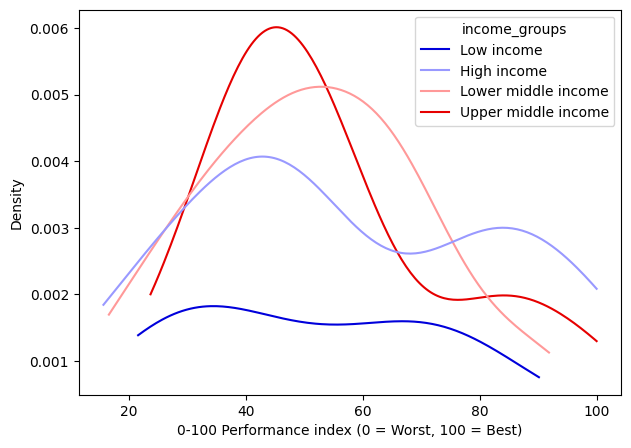

In [131]:
# Visualizing the dataset

# Plotting the data on a KDE 
fig, ax = plt.subplots()
fig.set_size_inches(7,5)

sns.kdeplot(data=scaled_emissions_total,
            x= "scaled_values",
            hue= "income_groups",
            ax=ax,
            cut=0,
            palette="seismic",
            fill=False).set(xlabel="0-100 Performance index (0 = Worst, 100 = Best)")

plt.show()

In [132]:
# Descriptive Statistics for each group

scaled_emissions_median = scaled_emissions_total.groupby("income_groups").median()

display(scaled_emissions_median)

scaled_emissions_mean = scaled_emissions_total.groupby("income_groups").mean().sort_values("scaled_values", ascending=False)

display(scaled_emissions_mean)

scaled_emissions_count = scaled_emissions_total.groupby("income_groups").count()

scaled_emissions_count

,emissions_normal,emissions_transformed,scaled_values
income_groups,,,
High income,0.670559,-0.399643,50.000000
Low income,0.789594,-0.236236,50.000000
Lower middle income,0.656347,-0.421065,50.000000
Upper middle income,0.625922,-0.468596,50.001621


,emissions_normal,emissions_transformed,scaled_values
income_groups,,,
High income,0.655068,NaN,57.493889
Upper middle income,0.602661,NaN,54.908335
Lower middle income,0.703428,-0.551109,51.620708
Low income,0.875132,-0.363289,51.126537


,emissions_normal,emissions_transformed,scaled_values
income_groups,,,
High income,45,45,45
Low income,19,19,19
Lower middle income,43,43,43
Upper middle income,42,42,42


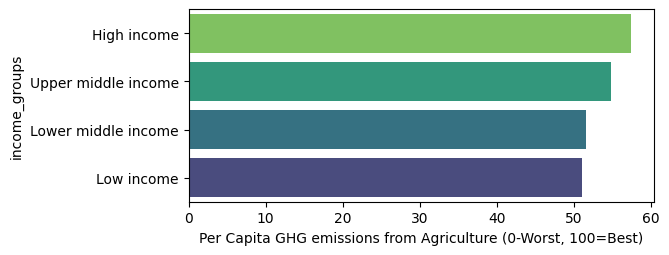

In [133]:
# Visualizing the medians in a bargraph

df = scaled_emissions_mean.sort_values("scaled_values", ascending=False)
fig, ax = plt.subplots()

sns.barplot(data=df,
            x="scaled_values",
            y=df.index,
            palette="viridis_r").set_xlabel("Per Capita GHG emissions from Agriculture (0-Worst, 100=Best)")

fig.set_size_inches(6, 2.5)

### Indicator 3: Per Capita Net Freshwater Withdrawal

In [134]:
# Loading the dataset

water_withdrawals = pd.read_csv("materials_and_methods/Metric_2/indicator_3.csv")

water_withdrawals.head()

,Entity,Code,Year,"Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)"
0,Afghanistan,AFG,1987,99.000046
1,Afghanistan,AFG,1988,98.972824
2,Afghanistan,AFG,1989,98.944450
3,Afghanistan,AFG,1990,98.914856
4,Afghanistan,AFG,1991,98.883950


In [135]:
# Removing unwanted columns

water_withdrawals_cleaned = water_withdrawals.iloc[:, [0, 2, 3]]

water_withdrawals_cleaned.head()

,Entity,Year,"Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)"
0,Afghanistan,1987,99.000046
1,Afghanistan,1988,98.972824
2,Afghanistan,1989,98.944450
3,Afghanistan,1990,98.914856
4,Afghanistan,1991,98.883950


In [136]:
# Removing Unwanted Years

water_withdrawals_filtered = water_withdrawals_cleaned[water_withdrawals_cleaned["Year"] == 2019]

water_withdrawals_filtered.head()

,Entity,Year,"Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)"
32,Afghanistan,2019,98.169624
62,Albania,2019,61.184790
102,Algeria,2019,63.764100
135,Angola,2019,20.784925
165,Antigua and Barbuda,2019,15.652174


In [137]:
# Reseting the index

water_withdrawals_filtered_cleaned = water_withdrawals_filtered.set_index("Entity")

water_withdrawals_filtered_cleaned.head()

,Year,"Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)"
Entity,,
Afghanistan,2019,98.169624
Albania,2019,61.184790
Algeria,2019,63.764100
Angola,2019,20.784925
Antigua and Barbuda,2019,15.652174


In [138]:
# Merging the table above with size_of_economy table

water_withdrawals_economized = pd.merge(size_of_economy,
                                        water_withdrawals_filtered_cleaned,
                                        left_index=True,
                                        right_index= True).drop(["Region", "Year"], axis=1)

water_withdrawals_economized.head()

water_withdrawals_economized.columns = ["income_groups", "agri_percentage"]

water_withdrawals_economized.head()

,income_groups,agri_percentage
Afghanistan,Low income,98.169624
Angola,Lower middle income,20.784925
Albania,Upper middle income,61.184790
United Arab Emirates,High income,48.185406
Argentina,Upper middle income,73.928000


<Axes: xlabel='agri_percentage', ylabel='Density'>

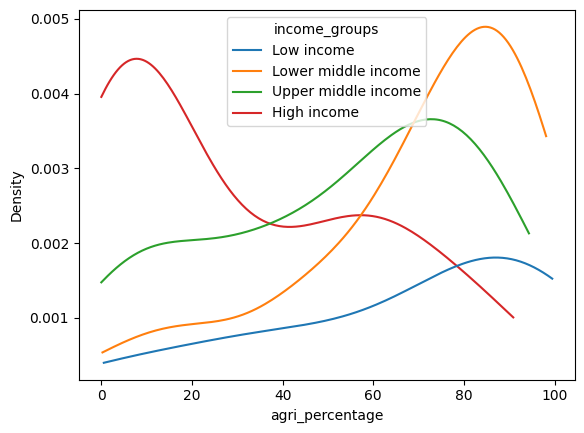

In [139]:
# Checking Normality in the data

sns.kdeplot(x="agri_percentage",
            hue="income_groups",
            data=water_withdrawals_economized,
            cut=0)

<Axes: xlabel='agri_percentage', ylabel='income_groups'>

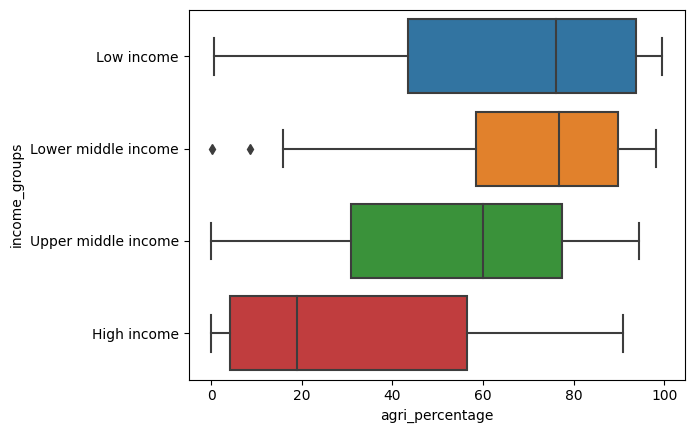

In [140]:
# There's a lot of non-normality in this data. Checking for outliers

sns.boxplot(x="agri_percentage",
            y="income_groups",
            data=water_withdrawals_economized)

<Axes: xlabel='agri_percentage', ylabel='income_groups'>

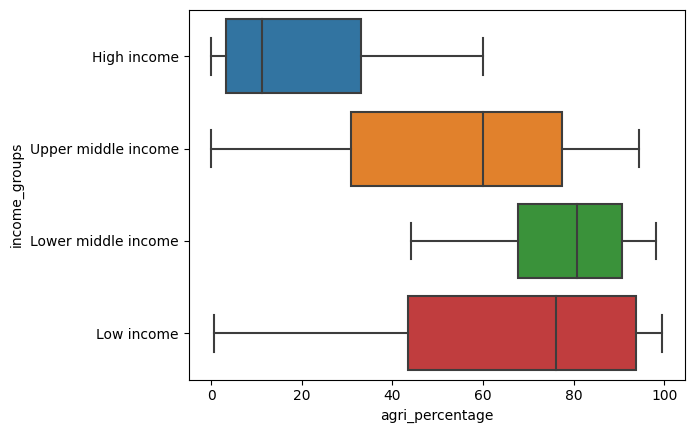

In [141]:
# Removing the outliers: 1. Separating the Income groups

withdrawals_low_income = water_withdrawals_economized[water_withdrawals_economized["income_groups"] == "Low income"]

withdrawals_lower_middle = water_withdrawals_economized[water_withdrawals_economized["income_groups"] == "Lower middle income"]

withdrawals_upper_middle = water_withdrawals_economized[water_withdrawals_economized["income_groups"] == "Upper middle income"]

withdrawals_high_income = water_withdrawals_economized[water_withdrawals_economized["income_groups"] == "High income"]



# Removing the outlier
withdrawals_lower_middle = withdrawals_lower_middle[withdrawals_lower_middle["agri_percentage"] > 40]

withdrawals_high_income = withdrawals_high_income[withdrawals_high_income["agri_percentage"] < 60]


# Piecing the table back together.
withdrawals_wout_outliers = pd.concat([withdrawals_high_income,
                                      withdrawals_upper_middle,
                                      withdrawals_lower_middle,
                                      withdrawals_low_income])



# Visualizing it now

sns.boxplot(data=withdrawals_wout_outliers,
            x="agri_percentage",
            y="income_groups")

[Text(0.5, 0, 'Percent of Per Capita Water Withdrawals For Agriculture')]

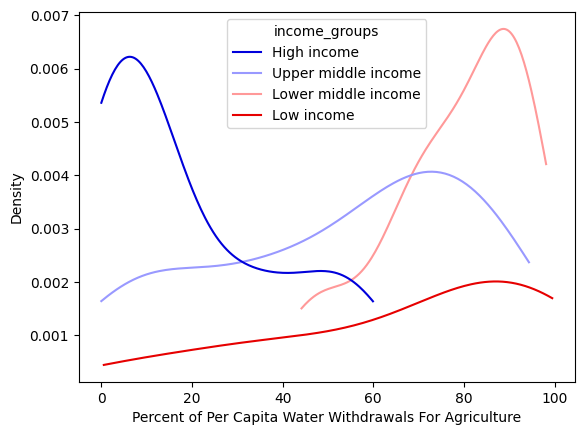

In [142]:
# Checking KDE distributions now

sns.kdeplot(data=withdrawals_wout_outliers,
            x="agri_percentage",
            hue="income_groups",
            cut=0,
            palette="seismic").set(xlabel="Percent of Per Capita Water Withdrawals For Agriculture")

In [143]:
# This is more tolerable: Moving on with ANOVA

# Checking number of countries in the dataset

withdrawals_counted = withdrawals_wout_outliers.groupby("income_groups").count()

withdrawals_counted

,agri_percentage
income_groups,
High income,38
Low income,22
Lower middle income,37
Upper middle income,46


In [144]:
# The number is tolerable. Modelling and fitting the ANOVA.

# Creating and fitting the linear model
model = ols("agri_percentage ~ C(income_groups)", data=withdrawals_wout_outliers).fit()

# Accessing ANOVA coefficients
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(income_groups),70045.049427,3.0,39.572726,1.499602e-18
Residual,82011.551056,139.0,NaN,NaN


In [145]:
# Moving on to check means and medians

withdrawals_grouped_by_means = withdrawals_wout_outliers.groupby("income_groups").mean()

withdrawals_grouped_by_medians = withdrawals_wout_outliers.groupby("income_groups").median()

display(withdrawals_grouped_by_means)
display(withdrawals_grouped_by_medians)

,agri_percentage
income_groups,
High income,19.587068
Low income,67.045932
Lower middle income,78.088346
Upper middle income,52.959919


,agri_percentage
income_groups,
High income,11.145601
Low income,76.105287
Lower middle income,80.635470
Upper middle income,59.994469


[Text(0.5, 0, 'Per Capita Water Withdrawals For Agriculture (%)'),
 Text(0, 0.5, 'Income groups')]

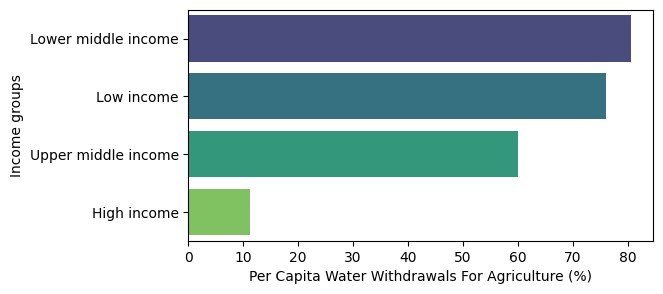

In [146]:
# Plotting the information above

df = withdrawals_grouped_by_medians.sort_values("agri_percentage", ascending=False)

fig, ax = plt.subplots()

fig.set_size_inches(6, 3)

sns.barplot(x="agri_percentage",
            y=df.index,
            data=df,
            palette="viridis").set(xlabel="Per Capita Water Withdrawals For Agriculture (%)",
                                   ylabel="Income groups")

### Indicator 4: Per Capita Non-Renewable Energy Use

In [147]:
# Importing the datasets

coal = pd.read_csv("materials_and_methods/Metric_2/energy_use/coal.csv")
display(coal.head(2))

natural_gas = pd.read_csv("materials_and_methods/Metric_2/energy_use/natural_gas.csv")
display(natural_gas.head(2))

petrol = pd.read_csv("materials_and_methods/Metric_2/energy_use/petroleum.csv")
display(petrol.head(2))

population_data = pd.read_csv("materials_and_methods/Metric_2/energy_use/population.csv")
display(population_data.head(2))


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,GPP,Emissions from pre and post agricultural produ...,3,Albania,723117,Energy Use (Coal),6506,Food Packaging,2006,2006,TJ,13.787690,E,Estimated value
1,GPP,Emissions from pre and post agricultural produ...,3,Albania,723117,Energy Use (Coal),6506,Food Packaging,2007,2007,TJ,36.750378,E,Estimated value


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,GPP,Emissions from pre and post agricultural produ...,3,Albania,723116,"Energy Use (Natural Gas, including LNG)",6507,Food Processing,2003,2003,TJ,11.306,E,Estimated value
1,GPP,Emissions from pre and post agricultural produ...,3,Albania,723116,"Energy Use (Natural Gas, including LNG)",6507,Food Processing,2004,2004,TJ,22.612,E,Estimated value


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,GPP,Emissions from pre and post agricultural produ...,2,Afghanistan,723115,Energy Use (Petroleum Products),6815,Food Transport,1990,1990,TJ,862.8965,E,Estimated value
1,GPP,Emissions from pre and post agricultural produ...,2,Afghanistan,723115,Energy Use (Petroleum Products),6815,Food Transport,1991,1991,TJ,835.8975,E,Estimated value


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,Food Balances (2010-),2,Afghanistan,511,Total Population - Both sexes,2501,Population,2010,2010,1000 No,29186.0,X,Figure from international organizations
1,FBS,Food Balances (2010-),2,Afghanistan,511,Total Population - Both sexes,2501,Population,2011,2011,1000 No,30117.0,X,Figure from international organizations


In [148]:
# Filtering for the needed year, removing unwanted columns, and putting a multiindex on columns

cleaned_coal = coal[coal["Year"] == 2019].iloc[:, [3, 7, 11]]

cleaned_coal.head()

coal_pivoted = cleaned_coal.pivot_table(index="Area",
                                      columns="Item",
                                      values="Value").iloc[:, [6]]


columns = pd.MultiIndex.from_product([["Coal"], list(coal_pivoted.columns.values)])

coal_pivoted.columns = columns

coal_pivoted.head()

,Coal
,Pre- and Post- Production
Area,
Africa,102513.444503
Albania,360.579824
Americas,109730.134306
Annex I countries,252413.938330
Argentina,2757.660000


In [149]:
cleaned_gas = natural_gas[natural_gas["Year"] == 2019].iloc[:, [3, 7, 11]]

cleaned_gas.head()

gas_pivoted = cleaned_gas.pivot_table(index="Area", columns="Item", values="Value").iloc[:, [6]]

columns = pd.MultiIndex.from_product([["natural_gas"], list(gas_pivoted.columns.values)])

gas_pivoted.columns = columns

gas_pivoted.head()

,natural_gas
,Pre- and Post- Production
Area,
Africa,4.571196e+05
Albania,3.486850e+02
Algeria,3.420178e+05
Americas,2.857067e+06
Annex I countries,5.961379e+06


In [150]:
cleaned_petrol = petrol[petrol["Year"] == 2019].iloc[:, [3, 7, 11]]

cleaned_petrol.head()

petrol_pivoted = cleaned_petrol.pivot_table(index="Area", columns="Item", values="Value").iloc[:, [6]]

columns = pd.MultiIndex.from_product([["petrol"], list(petrol_pivoted.columns.values)])

petrol_pivoted.columns = columns

petrol_pivoted.head()

,petrol
,Pre- and Post- Production
Area,
Afghanistan,2.851434e+04
Africa,1.020159e+06
Albania,8.194554e+03
Algeria,1.195479e+05
American Samoa,8.706640e+02


In [151]:
clean_population = population_data[(population_data["Year"] == 2019) \
                                   & \
                                   (population_data["Flag Description"] == "Figure from international organizations")].iloc[:, [3, 11]].set_index("Area")

clean_population.head()


# Putting the value in its correct notation
clean_population["Value"] = clean_population["Value"] * 1000


# Making two levels so that when the table is combined with other tables it doesn't create problems.
columns = pd.MultiIndex.from_product([["Total Population"], list(clean_population.columns.values)])

clean_population.columns = columns

clean_population

,Total Population
,Value
Area,
Afghanistan,3.804175e+07
Albania,2.880920e+06
Algeria,4.305305e+07
Angola,3.182529e+07
Antigua and Barbuda,9.712000e+04
...,...
Least Developed Countries,1.014437e+09
Land Locked Developing Countries,5.209727e+08


In [152]:
# Combining the 4 tables to get the total energy from Agriculture + Total population

coal_and_gas = pd.merge(coal_pivoted,
                        gas_pivoted,
                        how="outer",
                        left_on=coal_pivoted.index,
                        right_on=gas_pivoted.index)

coal_and_gas.head()

,key_0,Coal,natural_gas
,,Pre- and Post- Production,Pre- and Post- Production
0,Africa,102513.444503,4.571196e+05
1,Albania,360.579824,3.486850e+02
2,Americas,109730.134306,2.857067e+06
3,Annex I countries,252413.938330,5.961379e+06
4,Argentina,2757.660000,1.837088e+05


In [153]:

energy_total = pd.merge(coal_and_gas,
                        petrol_pivoted,
                        how="outer",
                        left_on= "key_0",
                        right_on=petrol_pivoted.index)

energy_total = energy_total.set_index("key_0").fillna(0)

In [154]:
# Putting a column of the total energy from these non-renewable sources as used in agriculture

total_energy_from_agri = energy_total["Coal"] + energy_total["natural_gas"] + energy_total["petrol"]

total_energy_from_agri.head()

,Pre- and Post- Production
key_0,
Africa,1.579792e+06
Albania,8.903819e+03
Americas,5.957400e+06
Annex I countries,1.056995e+07
Argentina,3.038986e+05


In [155]:
# Setting this table to have two levels and then merging it with the energy_total table

columns = pd.MultiIndex.from_product([["total_energy_used_from_agri"], ["value"]])

total_energy_from_agri.columns = columns

total_energy_from_agri.head(2)


# doing the merger

energies_summed = pd.merge(energy_total,
                           total_energy_from_agri,
                           left_index=True,
                           right_index=True)

energies_summed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261 entries, Africa to Yemen
Data columns (total 4 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   (Coal, Pre- and Post- Production)         261 non-null    float64
 1   (natural_gas, Pre- and Post- Production)  261 non-null    float64
 2   (petrol, Pre- and Post- Production)       261 non-null    float64
 3   (total_energy_used_from_agri, value)      261 non-null    float64
dtypes: float64(4)
memory usage: 18.3+ KB


In [156]:
# Combining the table above with the population table
energy_and_pop_size = pd.merge(energies_summed,
                               clean_population,
                               left_index=True,
                               right_index=True)

energy_and_pop_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, Africa to Yemen
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   (Coal, Pre- and Post- Production)         219 non-null    float64
 1   (natural_gas, Pre- and Post- Production)  219 non-null    float64
 2   (petrol, Pre- and Post- Production)       219 non-null    float64
 3   (total_energy_used_from_agri, value)      219 non-null    float64
 4   (Total Population, Value)                 219 non-null    float64
dtypes: float64(5)
memory usage: 10.3+ KB


In [157]:
# Calculating per capita energy use from these three energy sources

energy_per_capita = pd.DataFrame(list(energy_and_pop_size["total_energy_used_from_agri"].values / energy_and_pop_size["Total Population"].values), 
                                 columns=["energy_per_capita"],
                                 index=energy_and_pop_size.index)

energy_per_capita.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, Africa to Yemen
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy_per_capita  219 non-null    float64
dtypes: float64(1)
memory usage: 3.4+ KB


In [158]:
# Merging the previous table with the size_of_economy table

per_capita_energy_economized = pd.merge(size_of_economy,
                                        energy_per_capita,
                                        left_index=True,
                                        right_index=True).drop("Region", axis=1)

per_capita_energy_economized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, Afghanistan to Zimbabwe
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Income group       155 non-null    object 
 1   energy_per_capita  155 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.6+ KB


In [159]:
# Checking the sample size for different income groups

per_capita_energy_economized.groupby("Income group").count()

,energy_per_capita
Income group,
High income,45
Low income,21
Lower middle income,44
Upper middle income,45


In [160]:
# Rechecking the table again (It was a good job done above!!)

per_capita_energy_economized.head()

,Income group,energy_per_capita
Afghanistan,Low income,0.000750
Angola,Lower middle income,0.000967
Albania,Upper middle income,0.003091
United Arab Emirates,High income,0.006203
Argentina,Upper middle income,0.006786


In [161]:
# Renaming columns for ANOVA

per_capita_energy_economized.columns = ["income_group", "energy_per_capita"]

per_capita_energy_economized.head()

,income_group,energy_per_capita
Afghanistan,Low income,0.000750
Angola,Lower middle income,0.000967
Albania,Upper middle income,0.003091
United Arab Emirates,High income,0.006203
Argentina,Upper middle income,0.006786


In [162]:
# Separating the income groups so that we can scale the data.

low_income_per_capita_energy = per_capita_energy_economized[per_capita_energy_economized["income_group"] == "Low income"]

lower_middle_per_capita_energy = per_capita_energy_economized[per_capita_energy_economized["income_group"] == "Lower middle income"]

upper_middle_per_capita_energy = per_capita_energy_economized[per_capita_energy_economized["income_group"] == "Upper middle income"]

high_income_per_capita_energy = per_capita_energy_economized[per_capita_energy_economized["income_group"] == "High income"]



# Scaling the data

scaled_low_income_energy = scaler(low_income_per_capita_energy, "energy_per_capita")

scaled_lower_middle_energy = scaler(lower_middle_per_capita_energy, "energy_per_capita")

scaled_upper_middle_energy = scaler(upper_middle_per_capita_energy, "energy_per_capita")

scaled_high_income_energy = scaler(high_income_per_capita_energy, "energy_per_capita")

C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scaled Values"] = scaled_values
C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scaled Values"] = scaled_values
C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [163]:
# Combining the scaled data

scaled_per_capita_energy = pd.concat([scaled_low_income_energy,
                                      scaled_lower_middle_energy,
                                      scaled_upper_middle_energy,
                                      scaled_high_income_energy])


scaled_per_capita_energy.head()

,income_group,energy_per_capita,Scaled Values
Afghanistan,Low income,0.000750,6.519698
Burundi,Low income,0.000074,76.415264
Burkina Faso,Low income,0.000372,25.787524
Central African Republic,Low income,0.000082,74.150142
Ethiopia,Low income,0.000111,66.717542


In [164]:
# Renaming the dataset so that the new column can be used to calculate ANOVA

scaled_per_capita_energy.columns = ["income_group", "energy_per_capita", "scaled_values"]

scaled_per_capita_energy.head()

,income_group,energy_per_capita,scaled_values
Afghanistan,Low income,0.000750,6.519698
Burundi,Low income,0.000074,76.415264
Burkina Faso,Low income,0.000372,25.787524
Central African Republic,Low income,0.000082,74.150142
Ethiopia,Low income,0.000111,66.717542


<Axes: xlabel='scaled_values', ylabel='Density'>

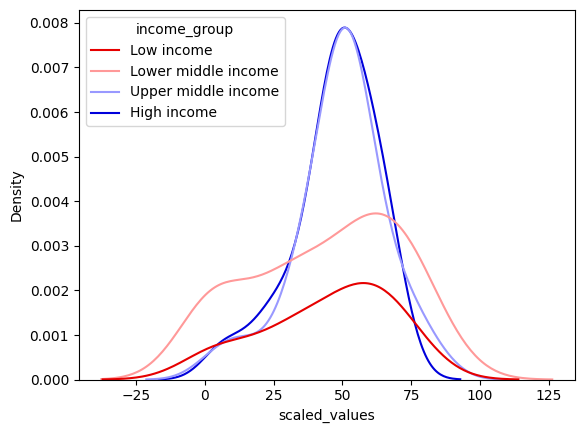

In [165]:
# Visualizing the dataset to check normality

sns.kdeplot(x="scaled_values",
            hue="income_group",
            data=scaled_per_capita_energy,
            palette="seismic_r")

<Axes: xlabel='scaled_values', ylabel='income_group'>

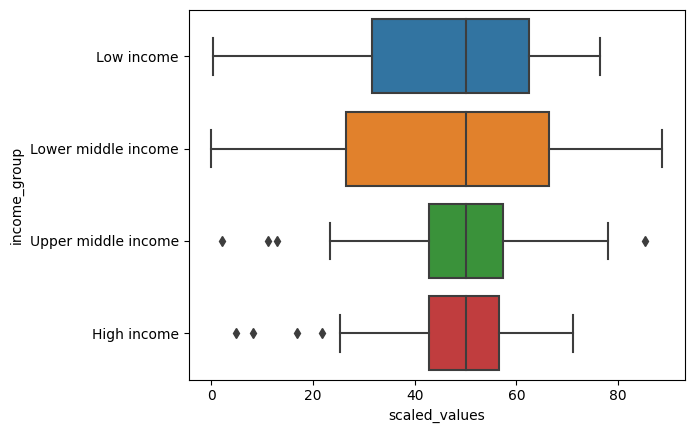

In [166]:
# There seems to be outliers. Fishing them out.

sns.boxplot(data=scaled_per_capita_energy,
            x="scaled_values",
            y="income_group")

In [167]:
# Removing the outliers

outliers_upper_middle_energy = scaled_per_capita_energy[(scaled_per_capita_energy["income_group"] == "Upper middle income") \
                                                       & \
                                                        (scaled_per_capita_energy["scaled_values"] < 20)].index.values

outliers_high_income_energy = scaled_per_capita_energy[(scaled_per_capita_energy["income_group"] == "High income") & \
                                                      (scaled_per_capita_energy["scaled_values"] < 23)].index.values

display(outliers_upper_middle_energy)
display(outliers_high_income_energy)

array(['Kazakhstan', 'Russian Federation', 'Turkmenistan'], dtype=object)

array(['Canada', 'Luxembourg', 'Oman', 'Qatar'], dtype=object)

In [168]:
# Removing the outliers

scaled_per_capita_energy = scaled_per_capita_energy.drop(['Kazakhstan', 'Russian Federation', 'Turkmenistan', 'Canada', 'Luxembourg', 'Oman', 'Qatar'])

Text(0.5, 0, 'Performance on Energy Per Capita From Agriculture (0=Worse, 100=Best)')

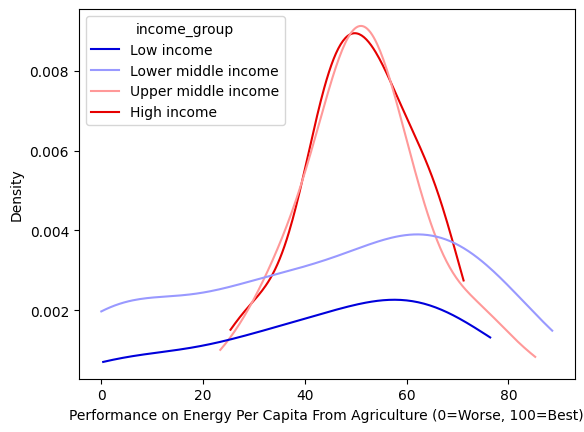

In [169]:
# Plotting the kdeplot again

sns.kdeplot(data=scaled_per_capita_energy,
            x="scaled_values",
            hue="income_group",
            palette="seismic",
            cut=0).set_xlabel("Performance on Energy Per Capita From Agriculture (0=Worse, 100=Best)")

In [170]:
# There is still a right skewing of the data. Applying a natural log to see if we can deal with that problem.

scaled_per_capita_energy.head()

scaled_per_capita_energy["log_scaled"] = np.log(scaled_per_capita_energy["energy_per_capita"])

scaled_per_capita_energy.head()

,income_group,energy_per_capita,scaled_values,log_scaled
Afghanistan,Low income,0.000750,6.519698,-7.196033
Burundi,Low income,0.000074,76.415264,-9.513549
Burkina Faso,Low income,0.000372,25.787524,-7.896452
Central African Republic,Low income,0.000082,74.150142,-9.407510
Ethiopia,Low income,0.000111,66.717542,-9.105063


<Axes: xlabel='energy_per_capita', ylabel='Density'>

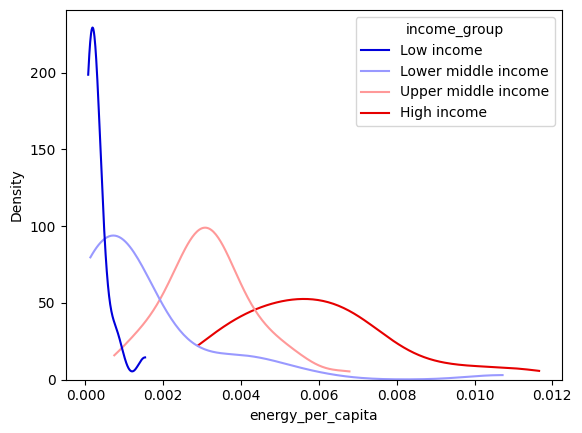

In [171]:
# Visualizing the log scaled values

sns.kdeplot(data= scaled_per_capita_energy,
            x= "energy_per_capita",
            hue= "income_group",
            palette="seismic",
            cut=0)

In [172]:
scaled_per_capita_energy["energy_per_capita"] = scaled_per_capita_energy["energy_per_capita"] * 1000000000000

In [173]:
# Using the scaled values for ANOVA

# The model

model = ols("energy_per_capita ~ C(income_group)", data=scaled_per_capita_energy).fit()

anova = sm.stats.anova_lm(model, typ=2)

anova

,sum_sq,df,F,PR(>F)
C(income_group),6.102573e+20,3.0,73.639562,6.313892e-29
Residual,3.977801e+20,144.0,NaN,NaN


In [174]:
# The log_scaled data showed better robustness. Trying to scale that into the 0-100 scale

# Separating income groups in order to scale them independently again
log_scaled_low_income_energy = scaled_per_capita_energy[scaled_per_capita_energy["income_group"] == "Low income"]

log_scaled_lower_middle_energy = scaled_per_capita_energy[scaled_per_capita_energy["income_group"] == "Lower middle income"]

log_scaled_upper_middle_energy = scaled_per_capita_energy[scaled_per_capita_energy["income_group"] == "Upper middle income"]

log_scaled_high_income_energy = scaled_per_capita_energy[scaled_per_capita_energy["income_group"] == "High income"]


# Scaling them
column = "log_scaled"

scaled_log_scaled_low_income = scaler(log_scaled_low_income_energy, column)

scaled_log_scaled_lower_middle = scaler(log_scaled_lower_middle_energy, column)

scaled_log_scaled_upper_middle = scaler(log_scaled_upper_middle_energy, column)

scaled_log_scaled_high_income = scaler(log_scaled_high_income_energy, column)


# Patching the 4 tables together
scaled_log_scaled_total = pd.concat([scaled_log_scaled_low_income,
                                     scaled_log_scaled_lower_middle,
                                     scaled_log_scaled_upper_middle,
                                     scaled_log_scaled_high_income])


# Checking the output table

scaled_log_scaled_total.head()

C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scaled Values"] = scaled_values
C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scaled Values"] = scaled_values
C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,income_group,energy_per_capita,scaled_values,log_scaled,Scaled Values
Afghanistan,Low income,7.495537e+08,6.519698,-7.196033,55.865371
Burundi,Low income,7.384450e+07,76.415264,-9.513549,46.313626
Burkina Faso,Low income,3.720613e+08,25.787524,-7.896452,52.787494
Central African Republic,Low income,8.210516e+07,74.150142,-9.407510,46.712686
Ethiopia,Low income,1.111019e+08,66.717542,-9.105063,47.869880


In [175]:
# It seems using the scaler on the log_scaled column brings false representation of the energy used. Working with the old scaled values

# Using median to group the dataset (Largely of the non-normality of some income groups)

per_capita_energy_by_median = scaled_log_scaled_total.groupby("income_group").median().sort_values("energy_per_capita", ascending=False)

# per_capita_energy_by_median["energy_per_capita"] = per_capita_energy_by_median["energy_per_capita"] * 1000000000000

# per_capita_energy_by_median

Text(0.5, 0, 'Energy Per Capita Used in Pre and Post Agriculture (in TJ)')

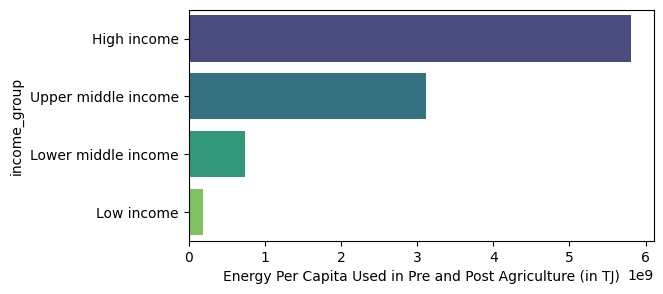

In [176]:
# It seems using medians from scaled_values gives a distorted picture. Using the actual data
fig, ax = plt.subplots()

fig.set_size_inches(6, 3)

sns.barplot(data=per_capita_energy_by_median,
            x="energy_per_capita",
            y=per_capita_energy_by_median.index,
            palette="viridis").set_xlabel("Energy Per Capita Used in Pre and Post Agriculture (in TJ)")

### Indicator 5: Per Capita Land Use

In [177]:
# Importing the dataset

land_use = pd.read_csv("materials_and_methods/Metric_2/indicator_5.csv")

land_use.head()

,Entity,Code,Year,Agricultural land | 00006610 || Area | 5110pc || hectares per capita
0,Afghanistan,AFG,1961,4.288897
1,Afghanistan,AFG,1962,4.210031
2,Afghanistan,AFG,1963,4.128873
3,Afghanistan,AFG,1964,4.048203
4,Afghanistan,AFG,1965,3.959685


In [179]:
# Selecting the relevant year

land_use_filtered = land_use[land_use["Year"] == 2019]

land_use_filtered.head()

,Entity,Code,Year,Agricultural land | 00006610 || Area | 5110pc || hectares per capita
58,Afghanistan,AFG,2019,1.006368
118,Africa,NaN,2019,0.845206
178,Albania,ALB,2019,0.408507
238,Algeria,DZA,2019,0.968469
298,American Samoa,ASM,2019,0.084705


In [180]:
# Removing columns that are not wanted.

land_use_cleaned = land_use_filtered.drop(["Code", "Year"], axis=1)

land_use_cleaned.head()

,Entity,Agricultural land | 00006610 || Area | 5110pc || hectares per capita
58,Afghanistan,1.006368
118,Africa,0.845206
178,Albania,0.408507
238,Algeria,0.968469
298,American Samoa,0.084705


In [181]:
# Re-indexing the dataframe

land_use_completely_cleaned = land_use_cleaned.set_index("Entity").rename_axis("Country")

land_use_completely_cleaned.head()

,Agricultural land | 00006610 || Area | 5110pc || hectares per capita
Country,
Afghanistan,1.006368
Africa,0.845206
Albania,0.408507
Algeria,0.968469
American Samoa,0.084705


In [182]:
# Joining the table with sizes of economies

land_use_economized = pd.merge(size_of_economy,
                               land_use_completely_cleaned,
                               left_index=True,
                               right_index=True).drop("Region", axis=1)

land_use_economized.head()

,Income group,Agricultural land | 00006610 || Area | 5110pc || hectares per capita
Country,,
Aruba,High income,0.018787
Afghanistan,Low income,1.006368
Angola,Lower middle income,1.760314
Albania,Upper middle income,0.408507
Andorra,High income,0.246199


In [183]:
# Renaming the columns for ANOVA
land_use_economized.columns = ["income_group", "hectares_per_capita"]

land_use_economized.head()

,income_group,hectares_per_capita
Country,,
Aruba,High income,0.018787
Afghanistan,Low income,1.006368
Angola,Lower middle income,1.760314
Albania,Upper middle income,0.408507
Andorra,High income,0.246199


<Axes: xlabel='hectares_per_capita', ylabel='Density'>

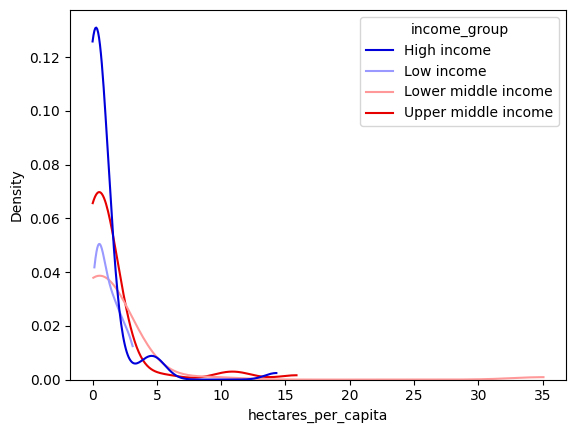

In [232]:
# Visualizing the data to check for normality

sns.kdeplot(data=land_use_economized,
            x="hectares_per_capita",
            hue="income_group",
            palette="seismic",
            cut=0)

<Axes: xlabel='hectares_per_capita', ylabel='income_group'>

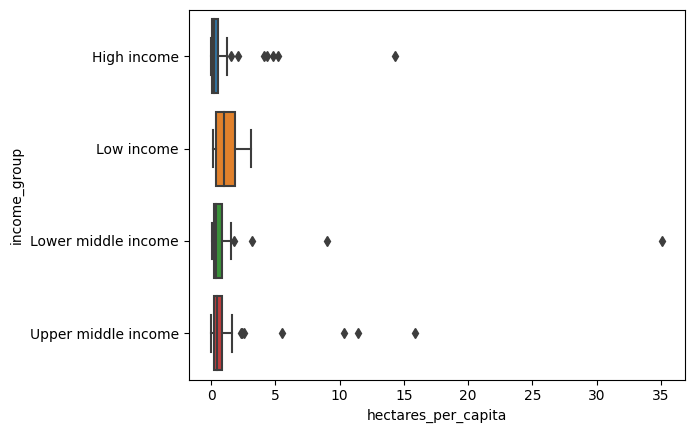

In [185]:
# It looks like we have some outliers lurking around. Checking to confirm.

sns.boxplot(data=land_use_economized,
            x="hectares_per_capita",
            y="income_group")

In [191]:
# Cleaning the outliers

high_income_land_use_wout_outliers = land_use_economized[(land_use_economized["income_group"] == "High income") & \
                                                         (land_use_economized["hectares_per_capita"] < 0.6)]

lower_middle_land_use_wout_outliers = land_use_economized[(land_use_economized["income_group"] == "Lower middle income") & \
                                                          (land_use_economized["hectares_per_capita"] < 1.6)]

upper_middle_land_use_wout_outliers = land_use_economized[(land_use_economized["income_group"] =="Upper middle income") & \
                                                          (land_use_economized["hectares_per_capita"] < 1.5)]

low_income_land_use = land_use_economized[land_use_economized["income_group"] == "Low income"]

# Combining the tables 

total_land_use_wout_outliers = pd.concat([low_income_land_use,
                                          high_income_land_use_wout_outliers,
                                          lower_middle_land_use_wout_outliers,
                                          upper_middle_land_use_wout_outliers])

total_land_use_wout_outliers.head()

,income_group,hectares_per_capita
Country,,
Afghanistan,Low income,1.006368
Burundi,Low income,0.171202
Burkina Faso,Low income,0.579573
Central African Republic,Low income,0.975174
Eritrea,Low income,2.169875


<Axes: xlabel='hectares_per_capita', ylabel='income_group'>

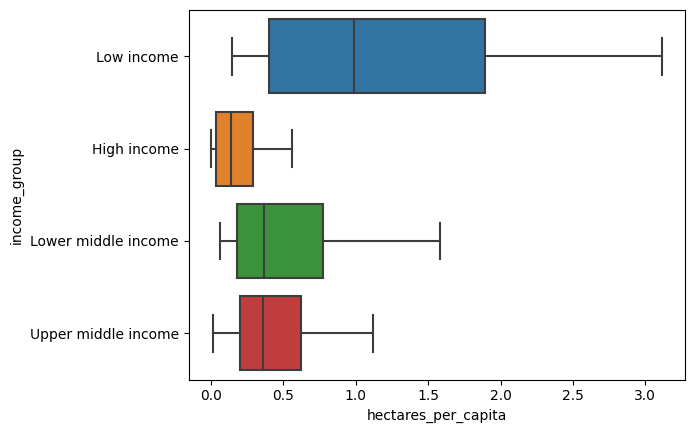

In [192]:
# Visualizing outliers again 

sns.boxplot(data=total_land_use_wout_outliers,
            x="hectares_per_capita",
            y="income_group")

In [195]:
# Creating and fitting the model
model = ols("hectares_per_capita ~ C(income_group)", data = total_land_use_wout_outliers).fit()

anova = sm.stats.anova_lm(model, typ=2)

anova

,sum_sq,df,F,PR(>F)
C(income_group),15.099662,3.0,26.814098,5.843391e-14
Residual,28.343908,151.0,NaN,NaN


In [200]:
# Scaling the data
column = "hectares_per_capita"

scaled_low_income_land_use = scaler(low_income_land_use, column)

scaled_high_income_land_use = scaler(high_income_land_use_wout_outliers, column)

scaled_lower_middle_land_use = scaler(lower_middle_land_use_wout_outliers, column)

scaled_upper_middle_land_use = scaler(upper_middle_land_use_wout_outliers, column)


total_land_use_scaled = pd.concat([scaled_low_income_land_use,
                                   scaled_high_income_land_use,
                                   scaled_lower_middle_land_use,
                                   scaled_upper_middle_land_use])

C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scaled Values"] = scaled_values
C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scaled Values"] = scaled_values
C:\Users\David\AppData\Local\Temp\ipykernel_16404\3034917137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [201]:
# Exploratory Data Analysis

land_use_grouped_mean = total_land_use_scaled.groupby("income_group").mean().sort_values("Scaled Values", ascending=False)

display(land_use_grouped_mean)

land_use_grouped_median = total_land_use_scaled.groupby("income_group").median().sort_values("Scaled Values", ascending=False)

display(land_use_grouped_median)

land_use_counted = total_land_use_scaled.groupby("income_group").count()

display(land_use_counted)

,hectares_per_capita,Scaled Values
income_group,,
Low income,1.178552,51.978920
High income,0.185994,51.494927
Upper middle income,0.426576,50.080823
Lower middle income,0.496264,47.318940


,hectares_per_capita,Scaled Values
income_group,,
Lower middle income,0.366406,50.012374
Upper middle income,0.360528,50.010411
Low income,0.990771,50.002977
High income,0.136883,50.000000


,hectares_per_capita,Scaled Values
income_group,,
High income,49,49
Low income,22,22
Lower middle income,42,42
Upper middle income,42,42


Text(0.5, 0, 'hectares per capita')

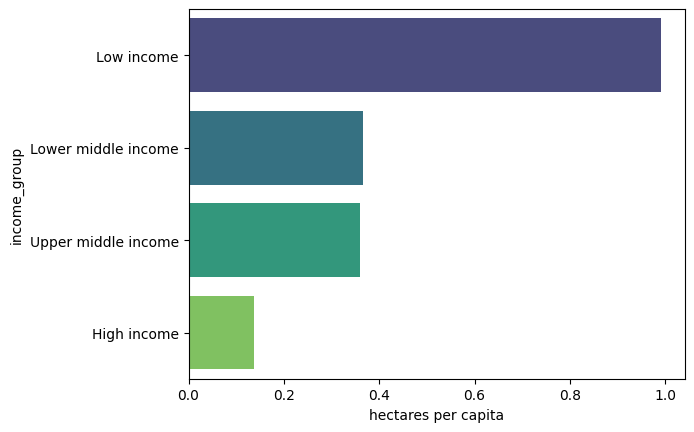

In [199]:
# Visualizing medians

sns.barplot(data=land_use_grouped_median,
            x="hectares_per_capita",
            y=land_use_grouped_median.index,
            palette="viridis").set_xlabel("hectares per capita")

## Metric 3: Food Affordability and Availability

### Indicator 1: Food Affordability

In [204]:
# Loading the dataset

affordability = pd.read_csv("materials_and_methods/Metric_3/indicator_1.csv", header=None)

affordability.head()

,0,1
0,Australia,93.3
1,Singapore,93.2
2,Netherlands,92.7
3,Belgium,92.6
4,Ireland,92.6


In [205]:
# Resetting the index and renaming columns

affordability_cleaned = affordability.rename(columns={0: "Countries", 1: "Affordability Scores"}).set_index("Countries")

affordability_cleaned

,Affordability Scores
Countries,
Australia,93.3
Singapore,93.2
Netherlands,92.7
Belgium,92.6
Ireland,92.6
...,...
Haiti,32.8
Burundi,32.5
Syria,32.0


In [218]:
# Attaching that table with size of economies

affordability_economized = pd.merge(size_of_economy,
                                    affordability_cleaned,
                                    left_index=True,
                                    right_index=True).drop("Region", axis=1)

affordability_economized

,Income group,Affordability Scores
Angola,Lower middle income,35.5
United Arab Emirates,High income,86.7
Argentina,Upper middle income,62.0
Australia,High income,93.3
Austria,High income,91.3
...,...,...
United States,High income,87.1
Uzbekistan,Lower middle income,52.7
Vietnam,Lower middle income,84.0
South Africa,Upper middle income,63.4


In [207]:
# Exploratory Data Analysis: Checking the sample size for each country group

affordability_income_groups_counted = affordability_economized.groupby("Income group").count()

display(affordability_income_groups_counted)

,Affordability Scores
Income group,
High income,34
Low income,15
Lower middle income,30
Upper middle income,23


In [238]:
# Exploratory Data Analysis: Mean and Median values in each country group

affordability_grouped_by_mean = affordability_economized.groupby("income_group").mean()

display(affordability_grouped_by_mean)

affordability_grouped_by_median = affordability_economized.groupby("income_group").median().sort_values("affordability_score", ascending=False)

display(affordability_grouped_by_median)

,affordability_score,transformed_values
income_group,,
High income,89.038235,4.488300
Low income,41.873333,3.721252
Lower middle income,58.263333,4.024861
Upper middle income,75.326087,4.314097


,affordability_score,transformed_values
income_group,,
High income,89.35,4.492560
Upper middle income,78.00,4.356709
Lower middle income,59.85,4.091841
Low income,42.60,3.751854


<Axes: xlabel='affordability_score', ylabel='income_group'>

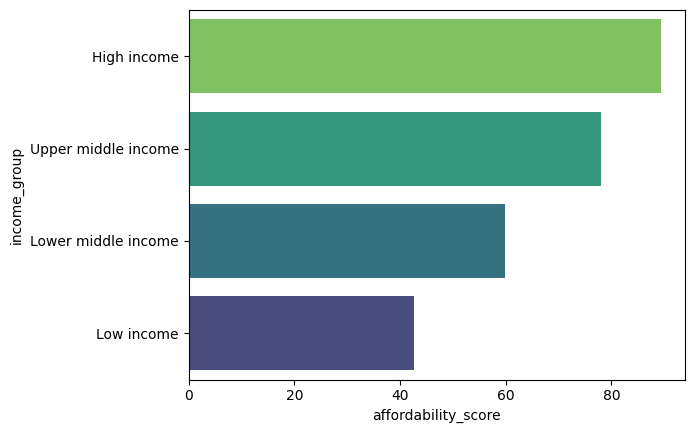

In [243]:
# Visualizing median values

df = affordability_grouped_by_median

sns.barplot(data= df,
            x = "affordability_score",
            y = df.index,
            palette= "viridis_r")

<Axes: xlabel='Affordability Scores', ylabel='Density'>

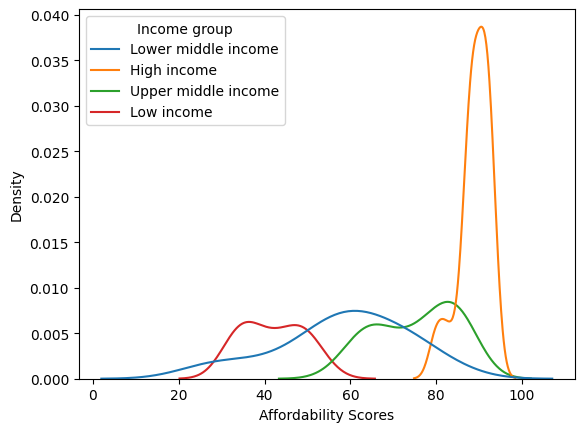

In [210]:
# Checking for normality

sns.kdeplot(data=affordability_economized,
            x="Affordability Scores",
            hue="Income group")

<Axes: xlabel='Affordability Scores', ylabel='Income group'>

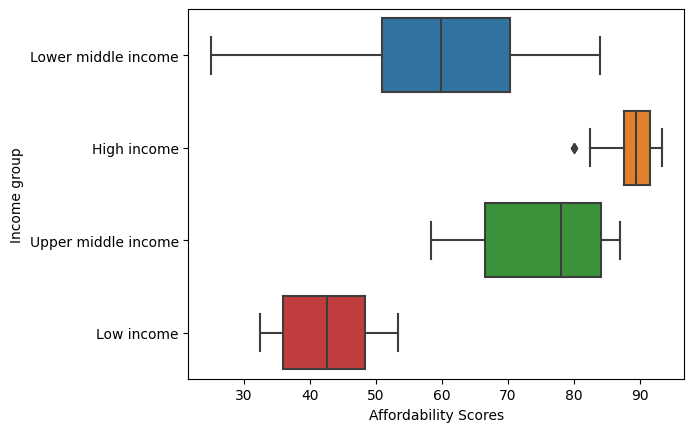

In [220]:
# Checking for outliers

sns.boxplot(data = affordability_economized,
            x = "Affordability Scores",
            y = "Income group")

<Axes: xlabel='Affordability Scores', ylabel='Income group'>

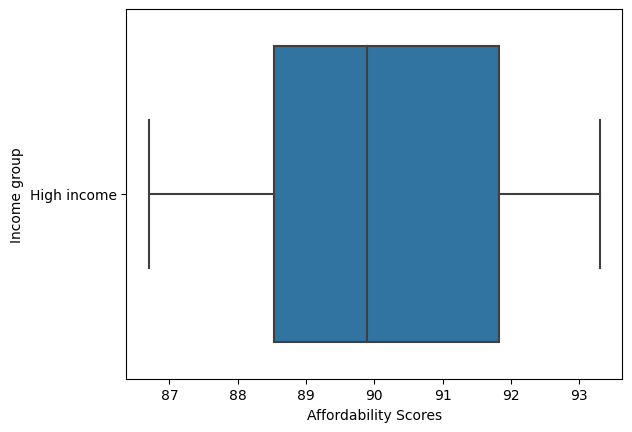

In [223]:
# Removing outliers

high_income_affordability_wout_outliers = affordability_economized[(affordability_economized["Income group"] == "High income") & \
                                                                   (affordability_economized["Affordability Scores"] > 84)]

sns.boxplot(data=high_income_affordability_wout_outliers,
            x="Affordability Scores",
            y="Income group")

In [226]:
# Creating a complete table wout outliers

low_income_affordability = affordability_economized[affordability_economized["Income group"] == "Low income"]

lower_middle_affordability = affordability_economized[affordability_economized["Income group"] == "Lower middle income"]

upper_middle_affordability = affordability_economized[affordability_economized["Income group"] == "Upper middle income"]


affordability_wout_outliers = pd.concat([low_income_affordability,
                                         lower_middle_affordability,
                                         upper_middle_affordability,
                                         high_income_affordability_wout_outliers])

<Axes: xlabel='Affordability Scores', ylabel='Density'>

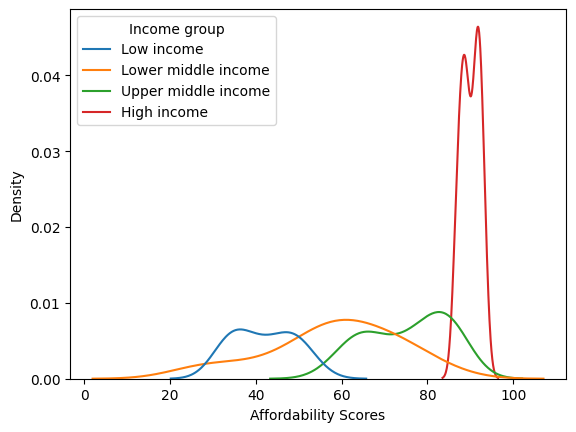

In [227]:
# Checking for normality again

sns.kdeplot(data = affordability_wout_outliers,
            x= "Affordability Scores",
            hue= "Income group")

In [228]:
# Transforming the data for normality

affordability_economized["transformed_values"] = np.log(affordability_economized["Affordability Scores"])

affordability_economized.head()

,Income group,Affordability Scores,transformed_values
Angola,Lower middle income,35.5,3.569533
United Arab Emirates,High income,86.7,4.462454
Argentina,Upper middle income,62.0,4.127134
Australia,High income,93.3,4.535820
Austria,High income,91.3,4.514151


<Axes: xlabel='transformed_values', ylabel='Density'>

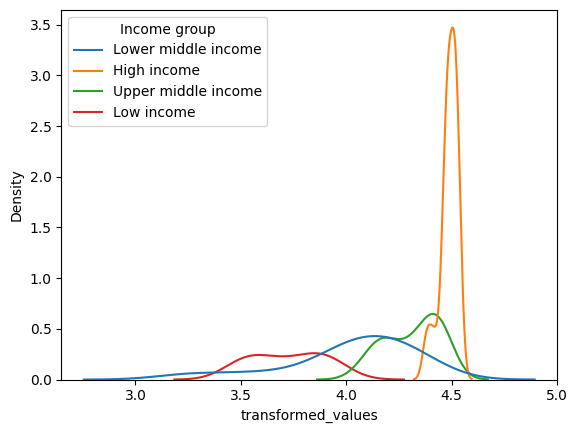

In [229]:
# Checking normality again 

sns.kdeplot(data=affordability_economized,
            x="transformed_values",
            hue="Income group")

In [230]:
# Renaming the columns for ANOVA

affordability_economized.columns = ["income_group", "affordability_score", "transformed_values"]

affordability_economized.head()

,income_group,affordability_score,transformed_values
Angola,Lower middle income,35.5,3.569533
United Arab Emirates,High income,86.7,4.462454
Argentina,Upper middle income,62.0,4.127134
Australia,High income,93.3,4.535820
Austria,High income,91.3,4.514151


In [235]:
# Running ANOVA 

# Creating and fitting the model

model = ols("affordability_score ~ C(income_group)", data = affordability_economized).fit()

anova = sm.stats.anova_lm(model, typ = 2)

anova

,sum_sq,df,F,PR(>F)
C(income_group),28974.843417,3.0,97.49967,2.631815e-29
Residual,9707.843642,98.0,NaN,NaN


### Indicator 2: Food Availability

In [71]:
# Loading the dataset:

food_availability = pd.read_csv("materials_and_methods/Metric_3/indicator_2.csv", header=None)

food_availability.head()

,0,1
0,Japan,81.2
1,China,79.2
2,Singapore,77.8
3,Portugal,77.0
4,Switzerland,76.8


In [72]:
# Renaming columns and resetting the index

availability_cleaned = food_availability.rename({0: "Countries", 1: "Availability Scores"}, axis="columns").set_index("Countries")

availability_cleaned.head()

,Availability Scores
Countries,
Japan,81.2
China,79.2
Singapore,77.8
Portugal,77.0
Switzerland,76.8


In [73]:
# Joining the dataset with the size_of_economy dataset

availability_economized = pd.merge(size_of_economy,
                                   availability_cleaned,
                                   right_index=True,
                                   left_index=True).drop("Region", axis=1)

availability_economized.head()

,Income group,Availability Scores
Angola,Lower middle income,43.5
United Arab Emirates,High income,73.8
Argentina,Upper middle income,63.4
Australia,High income,61.1
Austria,High income,67.1


In [74]:
# Exploratory Data Analysis: Checking the sample size from each income group

availability_group_count = availability_economized.groupby("Income group").count()

availability_group_count

,Availability Scores
Income group,
High income,34
Low income,15
Lower middle income,30
Upper middle income,23


In [75]:
# Exploratory Data Analysis: Checking the mean and median values from each income group

availability_groups_by_mean = availability_economized.groupby("Income group").mean()

display(availability_groups_by_mean)

availability_groups_by_median = availability_economized.groupby("Income group").median()

display(availability_groups_by_median)

,Availability Scores
Income group,
High income,68.079412
Low income,45.873333
Lower middle income,54.040000
Upper middle income,59.717391


,Availability Scores
Income group,
High income,67.45
Low income,48.20
Lower middle income,54.30
Upper middle income,59.80


### Indicator 3: Poverty Index

In [76]:
# Importing the data

poverty = pd.read_csv("materials_and_methods/Metric_3/indicator_3.csv")

poverty.head()

,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,Age,Location,Reporting Type,...,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51
0,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,2,Africa,ALLAGE,ALLAREA,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,8,Albania,ALLAGE,ALLAREA,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,19,Americas,ALLAGE,ALLAREA,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,32,Argentina,<15Y,ALLAREA,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,32,Argentina,15-64,ALLAREA,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# Cleaning the data: Removing unwanted columns (Opening the document in excel and checking columns there helps)

poverty_shortened = poverty.iloc[:, :13]

poverty_shortened

,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,Age,Location,Reporting Type,Sex,Units,2019
0,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,2,Africa,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,29.80000
1,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,8,Albania,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,0.00000
2,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,19,Americas,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,3.00000
3,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,32,Argentina,<15Y,ALLAREA,G,BOTHSEX,PERCENT,1.53763
4,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,32,Argentina,15-64,ALLAREA,G,BOTHSEX,PERCENT,0.68262
...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,716,Zimbabwe,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,39.80000
485,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,716,Zimbabwe,ALLAGE,ALLAREA,G,FEMALE,PERCENT,39.44854
486,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,716,Zimbabwe,ALLAGE,ALLAREA,G,MALE,PERCENT,40.08752
487,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,716,Zimbabwe,ALLAGE,RURAL,G,BOTHSEX,PERCENT,52.61327


In [78]:
# Taking only rows whose data in the "Sex" column is BOTHSEX, "Age" is ALLAGE, Location is ALLAREA

poverty_1 = poverty_shortened[poverty_shortened["Sex"] == "BOTHSEX"]

poverty_2 = poverty_1[poverty_1["Age"] == "ALLAGE"]

poverty_fully_filtered = poverty_2[poverty_2["Location"] == "ALLAREA"]

poverty_fully_filtered

,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,Age,Location,Reporting Type,Sex,Units,2019
0,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,2,Africa,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,29.8
1,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,8,Albania,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,0.0
2,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,19,Americas,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,3.0
6,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,32,Argentina,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,0.8
13,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,51,Armenia,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,548,Vanuatu,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,10.0
478,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,11,Western Africa,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,26.6
479,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,155,Western Europe,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,0.1
480,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,1,World,ALLAGE,ALLAREA,G,BOTHSEX,PERCENT,8.5


In [79]:
# Removing all other unwanted columns

poverty_cleaned = poverty_fully_filtered.iloc[:, [6, 12]].set_index("GeoAreaName")

poverty_cleaned

,2019
GeoAreaName,
Africa,29.8
Albania,0.0
Americas,3.0
Argentina,0.8
Armenia,1.0
...,...
Vanuatu,10.0
Western Africa,26.6
Western Europe,0.1


In [80]:
# Attaching it with the size of economy table

poverty_economized = pd.merge(size_of_economy,
                              poverty_cleaned,
                              left_index=True,
                              right_index=True).drop("Region", axis=1)

poverty_economized

,Income group,2019
Albania,Upper middle income,0.0
Argentina,Upper middle income,0.8
Armenia,Upper middle income,1.0
Austria,High income,0.6
Belgium,High income,0.1
Bulgaria,Upper middle income,0.9
Belarus,Upper middle income,0.0
Brazil,Upper middle income,5.4
China,Upper middle income,0.1
Colombia,Upper middle income,5.3


In [81]:
# Grouping to check the sample size

poverty_grouped_and_counted = poverty_economized.groupby("Income group").count()
display(poverty_grouped_and_counted)

,2019
Income group,
High income,24
Low income,2
Lower middle income,9
Upper middle income,23


In [82]:
# Rechecking the initial country names to see if we can salvage low income countries from the initial poverty table

included_names = list(poverty_economized.index.values)

excluded_names = ~poverty_cleaned.index.isin(included_names)

poverty_excluded_values = poverty_cleaned[excluded_names]

poverty_excluded_values

,2019
GeoAreaName,
Africa,29.8
Americas,3.0
Asia,5.0
Australia and New Zealand,0.5
Bolivia (Plurinational State of),1.9
Central America,3.6
Central and Southern Asia,8.5
Czechia,0.0
"Developed regions (Europe, Cyprus, Israel, Northern America, Japan, Australia & New Zealand)",0.5


In [83]:
# Checking the median values of low-income countries to see if they reflect the "Least Developed Countries" values given at the poverty table

poverty_grouped_medians = poverty_economized.groupby("Income group").median()

poverty_grouped_medians

,2019
Income group,
High income,0.20
Low income,56.15
Lower middle income,4.40
Upper middle income,1.00


In [84]:
# Some more digging on the size_of_economy dataset to look for countries with slight differences in names

size_of_economy

# display(size_of_economy.index.values)

size_of_economy.loc["Moldova"]

Income group      Upper middle income
Region          Europe & Central Asia
Name: Moldova, dtype: object

### Indicator 4: Income Inequality

In [85]:
# Loading the dataset

gini = pd.read_csv("materials_and_methods/Metric_3/indicator_4.csv")

gini

,Entity,Code,Year,Gini coefficient
0,Albania,ALB,1996,0.270103
1,Albania,ALB,2002,0.317390
2,Albania,ALB,2005,0.305957
3,Albania,ALB,2008,0.299847
4,Albania,ALB,2012,0.289605
...,...,...,...,...
2120,Zambia,ZMB,2010,0.556215
2121,Zambia,ZMB,2015,0.571361
2122,Zimbabwe,ZWE,2011,0.431536
2123,Zimbabwe,ZWE,2017,0.443371


In [86]:
# Filtering to get the year wanted

gini_filtered = gini[gini["Year"] == 2019]

gini_filtered

,Entity,Code,Year,Gini coefficient
10,Albania,ALB,2019,0.307717
47,Argentina - urban,NaN,2019,0.429059
69,Armenia,ARM,2019,0.298782
104,Austria,AUT,2019,0.302116
142,Belarus,BLR,2019,0.252778
...,...,...,...,...
1988,Ukraine,UKR,2019,0.266195
2051,United States,USA,2019,0.415356
2065,Uruguay,URY,2019,0.396765
2085,Vanuatu,VUT,2019,0.323176


In [87]:
# Attaching the table with sizes of economy

gini_economized = pd.merge(size_of_economy,
                           gini_filtered,
                           left_index=True,
                           right_on="Entity").drop(["Region", "Code", "Year"], axis=1).set_index("Entity")

gini_economized

,Income group,Gini coefficient
Entity,,
Albania,Upper middle income,0.307717
Armenia,Upper middle income,0.298782
Austria,High income,0.302116
Belgium,High income,0.272198
Bulgaria,Upper middle income,0.402714
Belarus,Upper middle income,0.252778
Bolivia,Lower middle income,0.416496
Brazil,Upper middle income,0.534858
China,Upper middle income,0.381683


In [88]:
# Grouping to see how much of a sample size we have in each group

gini_grouped_and_counted = gini_economized.groupby("Income group").count()

gini_grouped_and_counted

,Gini coefficient
Income group,
High income,22
Low income,2
Lower middle income,9
Upper middle income,22


In [89]:
included_names = list(gini_economized.index.values)

excluded_names = ~gini_filtered["Entity"].isin(included_names)

# excluded_names
gini_excluded_values = gini_filtered[excluded_names]

gini_excluded_values

,Entity,Code,Year,Gini coefficient
47,Argentina - urban,NaN,2019,0.429059
365,China - rural,NaN,2019,0.326749
385,China - urban,NaN,2019,0.370526
513,Czechia,CZE,2019,0.252622
906,India - rural,NaN,2019,0.308630
918,India - urban,NaN,2019,0.393656
974,Indonesia - rural,NaN,2019,0.316865
1003,Indonesia - urban,NaN,2019,0.392157
1019,Iran,IRN,2019,0.409360
1166,Kyrgyzstan,KGZ,2019,0.297012


In [90]:
# Checking if we can fetch some of the low-income countries from the size of economy table from the names left-out in the gini table

size_of_economy.loc["India"]

Income group    Lower middle income
Region                   South Asia
Name: India, dtype: object

## Metric 4: Sociocultural Wellbeing

### Indicator 1: Gender Equity

In [91]:
# Loading the dataset

gender_equity = pd.read_csv("materials_and_methods/Metric_4/indicator_1.csv", header=None)

gender_equity

,0,1
0,Iceland,0.877
1,Norway,0.842
2,Finland,0.832
3,Sweden,0.820
4,Nicaragua,0.804
...,...,...
148,"Congo, Dem. Rep.",0.578
149,Syria,0.567
150,Pakistan,0.564
151,Iraq,0.530


In [92]:
# Renaming columns

gender_equity_renamed = gender_equity.rename({0: "Country", 1: "Global Gender Gap Index"}, axis=1)

gender_equity_renamed

,Country,Global Gender Gap Index
0,Iceland,0.877
1,Norway,0.842
2,Finland,0.832
3,Sweden,0.820
4,Nicaragua,0.804
...,...,...
148,"Congo, Dem. Rep.",0.578
149,Syria,0.567
150,Pakistan,0.564
151,Iraq,0.530


In [93]:
# Resetting the index column and merging the data with the size of economy dataset

gender_equity_cleaned = gender_equity_renamed.set_index("Country")

display(gender_equity_cleaned.head())


gender_equity_economized = pd.merge(size_of_economy,
                                    gender_equity_cleaned,
                                    left_index=True,
                                    right_index=True).drop("Region", axis=1)

gender_equity_economized

,Global Gender Gap Index
Country,
Iceland,0.877
Norway,0.842
Finland,0.832
Sweden,0.820
Nicaragua,0.804


,Income group,Global Gender Gap Index
Country,,
Angola,Lower middle income,0.660
Albania,Upper middle income,0.769
United Arab Emirates,High income,0.655
Argentina,Upper middle income,0.746
Armenia,Upper middle income,0.684
...,...,...
Uruguay,High income,0.737
United States,High income,0.724
Vanuatu,Lower middle income,0.638


In [94]:
# Grouping countries according to the size of economy and checking for sample sizes, mean, and median values.

gender_equity_grouped_and_counted = gender_equity_economized.groupby("Income group").count()

gender_equity_means = gender_equity_economized.groupby("Income group").mean()

gender_equity_median = gender_equity_economized.groupby("Income group").median()

display(gender_equity_grouped_and_counted)
display(gender_equity_means)
display(gender_equity_median)

,Global Gender Gap Index
Income group,
High income,48
Low income,15
Lower middle income,38
Upper middle income,39


,Global Gender Gap Index
Income group,
High income,0.732083
Low income,0.673600
Lower middle income,0.681711
Upper middle income,0.703744


,Global Gender Gap Index
Income group,
High income,0.736
Low income,0.668
Lower middle income,0.682
Upper middle income,0.709


### Indicator 2: Instances of Child Labor

In [95]:
# Loading the dataset

child_labor = pd.read_csv("materials_and_methods/Metric_4/indicator_2.csv")

child_labor.head()

,ref_area.label,indicator.label,source.label,sex.label,classif1.label,classif2.label,time,obs_value,obs_status.label,note_source.label
0,Afghanistan,"Children in employment by sex, age and economi...",HIES - Households Living Conditions Survey,Sex: Total,Age (Child labour bands): '5-17,Economic activity (Broad sector): Total,2014,3261.161,NaN,Repository: ILO-STATISTICS - Micro data proces...
1,Afghanistan,"Children in employment by sex, age and economi...",HIES - Households Living Conditions Survey,Sex: Total,Age (Child labour bands): '5-17,Economic activity (Broad sector): Agriculture,2014,380.369,NaN,Repository: ILO-STATISTICS - Micro data proces...
2,Afghanistan,"Children in employment by sex, age and economi...",HIES - Households Living Conditions Survey,Sex: Total,Age (Child labour bands): '5-17,Economic activity (Broad sector): Industry,2014,130.488,NaN,Repository: ILO-STATISTICS - Micro data proces...
3,Afghanistan,"Children in employment by sex, age and economi...",HIES - Households Living Conditions Survey,Sex: Total,Age (Child labour bands): '5-17,Economic activity (Broad sector): Services,2014,84.046,NaN,Repository: ILO-STATISTICS - Micro data proces...
4,Afghanistan,"Children in employment by sex, age and economi...",HIES - Households Living Conditions Survey,Sex: Total,Age (Child labour bands): '5-17,Economic activity (Broad sector): Not classified,2014,2666.258,NaN,Repository: ILO-STATISTICS - Micro data proces...


In [548]:
# Filtering the dataset according to year 2019, Age-band 5-17, in the agricultural sector, and both sexes.

child_labor_2019 = child_labor[child_labor["time"] == 2019]

child_labor_5years = child_labor_2019[child_labor_2019["classif1.label"] == "Age (Child labour bands): '5-17"]

child_labor_in_agriculture = child_labor_5years[child_labor_5years["classif2.label"] == "Economic activity (Broad sector): Agriculture"]

child_labor_agriculture_both_sexes = child_labor_in_agriculture[child_labor_in_agriculture["sex.label"] == "Sex: Total"][["ref_area.label", 
                                                                                                                          "sex.label", 
                                                                                                                          "classif1.label",
                                                                                                                          "classif2.label",
                                                                                                                          "obs_value"]]

child_labor_agriculture_both_sexes

,ref_area.label,sex.label,classif1.label,classif2.label,obs_value
329,Colombia,Sex: Total,Age (Child labour bands): '5-17,Economic activity (Broad sector): Agriculture,243.775
435,Ecuador,Sex: Total,Age (Child labour bands): '5-17,Economic activity (Broad sector): Agriculture,429.444
661,Honduras,Sex: Total,Age (Child labour bands): '5-17,Economic activity (Broad sector): Agriculture,185.550
1118,Mexico,Sex: Total,Age (Child labour bands): '5-17,Economic activity (Broad sector): Agriculture,589.248


### Indicator 3: Respect For Community Rights

In [565]:
# Loading the dataframe

community_rights = pd.read_csv("materials_and_methods/Metric_4/indicator_3.csv")

community_rights.head()

,Last updated:,Unnamed: 1,9/2/2015,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Notes:,Click an arrow on any column to sort the results. Clicking A-->Z will sort from smallest to largest score and Z-->A will sort largest to smallest,...,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190
0,Country,Region,Income level,Income level normalized (5=High Income:OECD; 1...,Aarhus,OGP,Federal/unitary,1.1,1.2,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Country,NaN,NaN,NaN,Progress,NaN,NaN,To what extent does the law mandate access to ...,To what extent does the law provide for natura...,To what extent does the law make access to env...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lithuania,Europe,High income: OECD,5,Aarhus,OGP,Unitary,3,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Latvia,Europe,High income: OECD,5,Aarhus,OGP,Unitary,3,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States,North America,High income: OECD,5,NaN,OGP,Federal,3,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [567]:
# Removing Unwanted columns and rows, and resetting the index

community_rights_cleaned = community_rights.iloc[:, [0, 132]].rename(columns={"Last updated:" : "Country", "Unnamed: 132" : "Overall Score"}).drop([0, 1]).set_index("Country")

community_rights_cleaned.head()

,Overall Score
Country,
Lithuania,2.39
Latvia,2.31
United States,2.16
South Africa,2.16
United Kingdom,2.14


In [568]:
# Joining the sizes of economies

community_rights_economized = pd.merge(size_of_economy,
                                       community_rights_cleaned,
                                       left_index=True,
                                       right_index=True).drop("Region", axis=1)

community_rights_economized.head()

,Income group,Overall Score
Country,,
Argentina,Upper middle income,1.63
Australia,High income,1.42
Bangladesh,Lower middle income,1.10
Belize,Lower middle income,0.82
Benin,Lower middle income,0.84


## Metric 5: Resilience

### Indicator 1: ND-GAIN

In [97]:
# Loading the dataset

nd_gain = pd.read_csv("materials_and_methods/Metric_5/gain.csv")

nd_gain.head()

,ISO3,Name,1995,1996,1997,1998,1999,2000,2001,2002,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AFG,Afghanistan,34.540527,34.532318,34.610292,34.802520,34.818479,34.836746,35.259062,35.686449,...,31.923583,31.756797,32.709698,32.901910,33.170649,32.419421,32.228588,32.844426,32.566627,32.797710
1,ALB,Albania,44.985055,44.973357,44.904180,44.543379,44.084588,44.140112,44.394205,44.868712,...,48.742192,49.279484,50.696344,51.248574,50.854689,50.684835,51.184690,50.780027,50.630988,50.758476
2,DZA,Algeria,45.013035,45.103616,45.012953,45.024701,45.369850,45.658923,45.845773,46.005927,...,44.960241,45.680764,45.601550,45.862860,46.348301,47.413017,47.416751,47.478285,47.614827,47.853701
3,AND,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGO,Angola,34.700633,34.682550,34.622045,34.560876,34.592635,34.620471,34.896140,35.385018,...,35.009971,35.346728,35.496522,35.545056,36.831118,36.841935,37.225241,37.401906,37.537551,37.909703


In [98]:
# Selecting the relevant year

nd_gain_filtered = nd_gain.loc[:, ["Name", "2019"]]

nd_gain_filtered.head()

,Name,2019
0,Afghanistan,32.844426
1,Albania,50.780027
2,Algeria,47.478285
3,Andorra,NaN
4,Angola,37.401906


In [99]:
# Resetting the index for the dataset

nd_gain_cleaned = nd_gain_filtered.set_index("Name")

nd_gain_cleaned.head()

,2019
Name,
Afghanistan,32.844426
Albania,50.780027
Algeria,47.478285
Andorra,NaN
Angola,37.401906


In [100]:
# Joining the table with sizes of economy

nd_gain_economized = pd.merge(size_of_economy,
                              nd_gain_cleaned,
                              left_index=True,
                              right_index=True).drop("Region", axis=1)

nd_gain_economized.head()

,Income group,2019
Afghanistan,Low income,32.844426
Angola,Lower middle income,37.401906
Albania,Upper middle income,50.780027
Andorra,High income,NaN
United Arab Emirates,High income,60.504101


In [569]:
# Exploratory Data Analysis

nd_gain_grouped_mean = nd_gain_economized.groupby("Income group").mean()

display(nd_gain_grouped_mean)

nd_gain_grouped_median = nd_gain_economized.groupby("Income group").median()

display(nd_gain_grouped_median)

nd_gain_counted = nd_gain_economized.groupby("Income group").count()

nd_gain_counted

,2019
Income group,
High income,62.044251
Low income,35.379523
Lower middle income,42.854906
Upper middle income,50.146962


,2019
Income group,
High income,61.695109
Low income,35.291224
Lower middle income,41.918914
Upper middle income,49.758989


,2019
Income group,
High income,50
Low income,22
Lower middle income,42
Upper middle income,47


### Indicator 2: Food Production Diversity

In [102]:
# Importing Data for crops
raw_crops = pd.read_csv("materials_and_methods/Metric_5/indicator_2/raw_crops.csv")

raw_crops.head(3)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1371.0,"Almonds, in shell",2019,2019,t,38205.00,A,Official figure
1,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2019,2019,t,18903.37,I,Imputed value
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1341.0,Apples,2019,2019,t,250324.00,A,Official figure


In [103]:
# Removing columns not wanted
raw_crops_filtered = raw_crops.drop(["Domain Code", 
                                    "Domain", 
                                    "Area Code (M49)", 
                                    "Element", 
                                    "Element Code", 
                                    "Item Code (CPC)",
                                    "Year Code",
                                    "Year",
                                    "Unit",
                                    "Flag",
                                    "Flag Description"], axis=1)


raw_crops_filtered.head()

,Area,Item,Value
0,Afghanistan,"Almonds, in shell",38205.00
1,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",18903.37
2,Afghanistan,Apples,250324.00
3,Afghanistan,Apricots,129363.00
4,Afghanistan,Barley,123576.00


In [570]:
income_groups = size_of_economy.groupby("Income group").count()

income_groups

,Region
Income group,
High income,79
Low income,27
Lower middle income,55
Upper middle income,55


In [104]:
# Transposing the table so that each country has only one row
raw_crops_refined = raw_crops_filtered.pivot_table(index="Area",
                                                   columns="Item",
                                                   values="Value")

raw_crops_refined.head(10)

Item,"Abaca, manila hemp, raw","Agave fibres, raw, n.e.c.","Almonds, in shell","Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,...,"True hemp, raw or retted",Tung nuts,Unmanufactured tobacco,"Vanilla, raw",Vetches,"Walnuts, in shell",Watermelons,Wheat,Yams,Yautia
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,38205.00,18903.37,250324.0,129363.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14690.00,846990.00,4890000.00,NaN,NaN
Albania,NaN,NaN,NaN,NaN,107713.0,4875.00,NaN,NaN,NaN,NaN,...,NaN,NaN,1403.00,NaN,1910.47,NaN,259697.00,233218.00,NaN,NaN
Algeria,NaN,NaN,72412.00,NaN,558830.0,209204.00,NaN,119636.0,NaN,NaN,...,NaN,NaN,15164.00,NaN,74.30,NaN,2206866.00,3876876.00,NaN,NaN
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2893.18,NaN,NaN,NaN,NaN,2945.33,NaN,NaN
Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.74,NaN
Argentina,NaN,NaN,692.51,5936.82,547846.0,27029.07,NaN,35000.0,10344.55,4127.25,...,NaN,5522.7,106245.10,NaN,NaN,18610.49,126266.02,19459727.00,NaN,NaN
Armenia,NaN,NaN,0.00,NaN,81674.0,68113.00,NaN,NaN,NaN,NaN,...,NaN,NaN,947.00,NaN,0.00,3432.90,127962.00,112621.00,NaN,NaN
Australia,NaN,NaN,212000.00,1157.60,265150.0,8377.00,NaN,NaN,8176.66,79533.00,...,NaN,NaN,2565.90,NaN,7880.50,4511.08,167284.77,17597560.79,NaN,NaN
Austria,NaN,NaN,NaN,NaN,239210.0,11510.00,NaN,NaN,3320.00,0.00,...,8920.0,NaN,NaN,NaN,NaN,3090.00,1390.00,1596880.00,NaN,NaN


In [105]:
# Calculating the Shannon index
shannon_raw_crops = Shannon_diversity(raw_crops_refined)

shannon_raw_crops

,Production Diversity Indeces
Area,
Afghanistan,2.133909
Albania,3.112096
Algeria,2.900503
Angola,1.899805
Antigua and Barbuda,1.578415
...,...
Venezuela (Bolivarian Republic of),2.920425
Viet Nam,2.160689
Yemen,3.169278


In [106]:
# Matching country groups with their sizes of economy

shannon_raw_crops_country_groups = pd.merge(size_of_economy,
                                            shannon_raw_crops,
                                            left_index=True,
                                            right_index=True).drop("Region", axis=1)

shannon_raw_crops_sorted = shannon_raw_crops_country_groups.sort_values("Production Diversity Indeces", ascending=False)


# Saving the dataframe above
# shannon_raw_crops_sorted.to_csv("01. Clean Datasets/Metric_5/shannon_raw_crops.csv")

shannon_raw_crops_sorted

,Income group,Production Diversity Indeces
Israel,High income,3.368086
China,Upper middle income,3.290967
Spain,High income,3.251324
Albania,Upper middle income,3.112096
Grenada,Upper middle income,3.074635
...,...,...
Kiribati,Lower middle income,0.412736
Malaysia,Upper middle income,0.375506
Eswatini,Lower middle income,0.343989
Mauritius,Upper middle income,0.221635


In [107]:
# Importing the raw animal products production data

raw_animal = pd.read_csv("materials_and_methods/Metric_5/indicator_2/raw_animal.csv")

raw_animal.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,4,Afghanistan,5510,Production,21512.00,"Cattle fat, unrendered",2019,2019,t,2377.48,I,Imputed value
1,QCL,Crops and livestock products,4,Afghanistan,5510,Production,21151.00,"Edible offal of cattle, fresh, chilled or frozen",2019,2019,t,17008.16,I,Imputed value
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,21156.00,"Edible offal of goat, fresh, chilled or frozen",2019,2019,t,9145.38,I,Imputed value
3,QCL,Crops and livestock products,4,Afghanistan,5510,Production,21155.00,"Edible offal of sheep, fresh, chilled or frozen",2019,2019,t,15615.85,I,Imputed value
4,QCL,Crops and livestock products,4,Afghanistan,5510,Production,21159.02,"Edible offals of camels and other camelids, fr...",2019,2019,t,549.05,I,Imputed value


In [108]:
# Selecting only the columns that are wanted

raw_animal_filtered = raw_animal.iloc[:, [3, 7, 11]]

raw_animal_filtered.head()

,Area,Item,Value
0,Afghanistan,"Cattle fat, unrendered",2377.48
1,Afghanistan,"Edible offal of cattle, fresh, chilled or frozen",17008.16
2,Afghanistan,"Edible offal of goat, fresh, chilled or frozen",9145.38
3,Afghanistan,"Edible offal of sheep, fresh, chilled or frozen",15615.85
4,Afghanistan,"Edible offals of camels and other camelids, fr...",549.05


In [255]:
# Transposing the data

raw_animal_refined = raw_animal_filtered.pivot_table(index="Area", columns="Item", values="Value")

raw_animal_refined.head()

Item,Beeswax,"Buffalo fat, unrendered","Cattle fat, unrendered","Edible offal of buffalo, fresh, chilled or frozen","Edible offal of cattle, fresh, chilled or frozen","Edible offal of goat, fresh, chilled or frozen","Edible offal of pigs, fresh, chilled or frozen","Edible offal of sheep, fresh, chilled or frozen","Edible offals of camels and other camelids, fresh, chilled or frozen","Edible offals of horses and other equines, fresh, chilled or frozen",...,Raw hides and skins of sheep or lambs,Raw milk of buffalo,Raw milk of camel,Raw milk of cattle,Raw milk of goats,Raw milk of sheep,"Sheep fat, unrendered","Shorn wool, greasy, including fleece-washed shorn wool",Silk-worm cocoons suitable for reeling,"Snails, fresh, chilled, frozen, dried, salted or in brine, except sea snails"
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,2377.48,NaN,17008.16,9145.38,NaN,15615.85,549.05,NaN,...,12110.25,NaN,6863.59,1811627.98,117531.69,203661.6,4302.33,14535.54,500.0,NaN
Albania,NaN,0.0,1593.05,0.0,4571.35,2592.64,682.11,5211.85,0.00,0.00,...,4864.39,12.7,NaN,946561.00,83966.00,81669.0,972.88,3182.00,NaN,NaN
Algeria,NaN,NaN,2915.19,NaN,22738.50,3704.69,10.98,41639.96,941.45,37.38,...,51714.14,NaN,14568.63,2478117.00,326481.00,524222.0,8059.35,35089.00,NaN,NaN
Angola,2314.66,NaN,3652.58,NaN,17188.59,2427.06,4688.46,617.70,NaN,NaN,...,617.70,NaN,NaN,218704.34,NaN,NaN,121.52,NaN,NaN,NaN
Antigua and Barbuda,NaN,NaN,1.46,NaN,7.07,0.78,2.23,1.13,NaN,NaN,...,0.96,NaN,NaN,3055.56,NaN,NaN,0.17,NaN,NaN,NaN


In [ ]:
# APPENDIX CODE


# 1. Visualizing distributions of the data

# fig, ((ax1, ax2), 
#       (ax3, ax4), 
#       (ax5, ax6), 
#       (ax7, ax8), 
#       (ax9, ax10), 
#       (ax11, ax12), 
#       (ax13, ax14)) = plt.subplots(7, 2, sharey=True, sharex=False, figsize=(7, 13))

# def distributions(df, x, y, ax) :
    
#     """Plots Boxplots for income groups"""
    
#     g = sns.boxplot(data=df,
#                     ax= ax,
#                     x=x,
#                     palette='tab10',
#                     y=y).set(xlabel='',
#                              ylabel='',
#                              title=x)
    
#     ax.set_title(x, fontsize=8)
    
#     ax.tick_params(axis='both', which='major', labelsize=7)
    
#     return g

# plt.suptitle('Distribution of Values among Different Food Groups', y= 0.95, fontsize=10)
# plt.subplots_adjust(hspace= 0.7)
# #plt.savefig('Distribution_of_Daily_Kcal_Intakes.png')


# Refer to this code for finer customizations of Seaborn plots.